# Quora Question Pair Similarity

## Installs, Imports and Downloads

In [ ]:
# Installing libraries
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install Distance
!pip install -U sentence-transformers
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.2.5/en_core_web_lg-2.2.5.tar.gz
!pip install en_core_web_lg

     |████████████████████████████████| 50 kB 5.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149863 sha256=c39200c6a50ce58f3f3e1532403fb0e064b667ad2e7285fae6afd39b8acf7279
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
     |████████████████████████████████| 180 kB 15.4 MB/s 
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=f5093a82ed3663f5e7dd7660ccb8747d3db3c3dfd1a909ed9e7e52f7a2866cb3
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built Distance
     |████████████████████████████████| 78 kB 5.0 MB/s 
     |████████████████████████████████| 3.1 MB 37.5 MB/s 
     |████████████████████████████████| 3.3 MB 32.4 MB/s 
     |████████████████████████████████| 1.2 MB 67.1 MB/s 
     |█████████████████████████████

In [ ]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

import re
import os
import spacy
import distance
import numpy as np
import pandas as pd
import en_core_web_lg
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from prettytable import PrettyTable
from scipy.spatial.distance import cosine
from scipy.sparse import save_npz, load_npz, hstack
from sentence_transformers import SentenceTransformer

import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
colors = sns.color_palette()

In [ ]:
# Downloading necessary files
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Reading Data

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/train.csv')
data.head()

id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]

## Splitting into train and test sets

In [ ]:
# Storing labels in array
labels = data['is_duplicate'].values

# Dropping labels column from data
data = data.drop(['is_duplicate'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.3)

## Checking sizes

In [ ]:
print('Train shape: {}'.format(train_data.shape))
print('Test shape: {}'.format(test_data.shape))

Train shape: (283003, 5)
Test shape: (121287, 5)


## Data cleaning and preprocessing

First, lets preprocess the data. After that, we can extract some basic and advanced features and visualize them.

In the preprocess step we will:
- Convert to lower case
- Remove punctuations
- Replace some numerical values with strings
- Remove HTML tags
- Replace some special characters with they string equivalent (Ex: $ = dollar)
- Decontract words (Eg: don't = do not)

We will be handling stop words later since we will be extracting some features form stop words. Stemming (We will try this whole thing again with lemmatization to see which works better) will be done after handling stop words

In [ ]:
# This function accepts a question and preprocesses it. Returns cleaned question.
def preprocess(q):
  # Firstly, we convert to lowercase and remove trailing and leading spaces
  q = str(q).lower().strip()

  # Replace certain special characters with their string equivalents
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar ')
  q = q.replace('₹', ' rupee ')
  q = q.replace('€', ' euro ')
  q = q.replace('@', ' at ')

  # The pattern '[math]' appears around 900 times in the whole dataset.
  q = q.replace('[math]', '')

  # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
  q = q.replace(',000,000,000 ', 'b ')
  q = q.replace(',000,000 ', 'm ')
  q = q.replace(',000 ', 'k ')
  q = re.sub(r'([0-9]+)000000000', r'\1b', q)
  q = re.sub(r'([0-9]+)000000', r'\1m', q)
  q = re.sub(r'([0-9]+)000', r'\1k', q)

  # Decontracting words
  # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
  # https://stackoverflow.com/a/19794953
  contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
  }

  q_decontracted = []

  for word in q.split():
    if word in contractions:
      word = contractions[word]
  
    q_decontracted.append(word)

  q = ' '.join(q_decontracted)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")

  # Removing HTML tags
  q = BeautifulSoup(q)
  q = q.get_text()

  # Remove punctuations
  pattern = re.compile('\W')
  q = re.sub(pattern, ' ', q).strip()

  return q

## Extracting features
We will extract following features:
- **Token features**
  1. **q1_len**: Number of characters in question 1
  1. **q2_len**: Number of characters in question 2
  1. **q1_words**: Number of words in question 1
  1. **q2_words**: Number of words in question 2
  1. **words_total**: Sum of **q1_words** and **q2_words**
  1. **words_common**: Number of words which occur in question 1 and two, reapeated occurances are not counted
  1. **words_shared**: Fraction of **words_common** to **words_total**
  1. **cwc_min**: This is the ratio of the number of common words to the length of the smaller question
  1. **cwc_max**: This is the ratio of the number of common words to the length of the larger question
  1. **csc_min**: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
  1. **csc_max**: This is the ratio of the number of common stop words to the larger stop word count among the two questions
  1. **ctc_min**: This is the ratio of the number of common tokens to the smaller token count among the two questions
  1. **ctc_max**: This is the ratio of the number of common tokens to the larger token count among the two questions
  1. **last_word_eq**: 1 if the last word in the two questions is same, 0 otherwise
  1. **first_word_eq**: 1 if the first word in the two questions is same, 0 otherwise
  1. **num_common_adj**: This is the number of common adjectives in question1 and question2
  1. **num_common_prn**: This is the number of common proper nouns in question1 and question2
  1. **num_common_n**: This is the number of nouns (non-proper) common in question1 and question2

- **Fuzzy features**

  1. **fuzz_ratio**: fuzz_ratio score from fuzzywuzzy
  1. **fuzz_partial_ratio**: fuzz_partial_ratio from fuzzywuzzy
  1. **token_sort_ratio**: token_sort_ratio from fuzzywuzzy
  1. **token_set_ratio**: token_set_ratio from fuzzywuzzy



- **Length features**
  1. **mean_len**: Mean of the length of the two questions (number of words)
  1. **abs_len_diff**: Absolute difference between the length of the two questions (number of words)
  1. **longest_substr_ratio**: Ratio of the length of the longest substring among the two questions to the length of the smaller question

### Defining functions to extract features

In [ ]:
# Receives question1 and question2 from one row in DataFrame
# Computes token features, removes stopwords and performs stemming
# Returns an array of shape (num_features,)
def get_token_features(q1, q2):
  # Safe div to avoid division by 0 exception
  safe_div = 0.0001

  # Getting NLTK  stop words set
  stop_words = stopwords.words('english')
  
  # Adding these after word cloud inspection
  stop_words.append('difference')
  stop_words.append('different')
  stop_words.append('best')

  # Initializing stemmer
  stemmer = PorterStemmer()

  # Initializing feature array
  token_features = [0.0] * 18

  # Tokenizing
  q1 = q1.split()
  q2 = q2.split()

  # Stop words in q1 and q2
  q1_stops = set([word for word in q1 if word in stop_words])
  q2_stops = set([word for word in q2 if word in stop_words])
  common_stops = q1_stops & q2_stops

  # Removing stop words
  q1 = [word for word in q1 if word not in stop_words]
  q2 = [word for word in q2 if word not in stop_words]

  # Stem
  # Is redundant but this design change was made much later and 
  # I don't feel like changing the entire function for it.
  # For now, computationally inefficient though it may be, it will do.
  q1_stemmed = ' '.join([word for word in q1])
  q2_stemmed = ' '.join([word for word in q2])

  if len(q1) == 0 or len(q2) == 0:
    return (token_features, q1_stemmed, q2_stemmed)

  # PoS features
  # Uses off the shelf NLTK tag set

  q1_tagged = nltk.pos_tag(q1)
  q2_tagged = nltk.pos_tag(q2)

  # We are looking for:
  # 1) JJ/JJR/JJS: Adjectives
  # 2) NNP/NNPS: Proper nouns
  # 3) NN/NNS: Nouns (non-proper)

  q1_adj = set()
  q2_adj = set()
  q1_prn = set()
  q2_prn = set()
  q1_n = set()
  q2_n = set()

  # Compute question1 PoS features
  for word in q1_tagged:
    if word[1] == 'JJ' or word[1] == 'JJR' or word[1] == 'JJS':
      q1_adj.add(word[0])
    elif word[1] == 'NNP' or word[1] == 'NNPS':
      q1_prn.add(word[0])
    elif word[1] == 'NN' or word[1] == 'NNS':
      q1_n.add(word[0])

  # Compute question2 PoS features
  for word in q2_tagged:
    if word[1] == 'JJ' or word[1] == 'JJR' or word[1] == 'JJS':
      q2_adj.add(word[0])
    elif word[1] == 'NNP' or word[1] == 'NNPS':
      q2_prn.add(word[0])
    elif word[1] == 'NN' or word[1] == 'NNS':
      q2_n.add(word[0])
      
  # num_common_adj
  token_features[15] = len(q1_adj & q2_adj)

  # num_common_prn
  token_features[16] = len(q1_prn & q2_prn)

  # num_common_n
  token_features[17] = len(q1_n & q2_n)

  # We do this here because converting to set looses order of words
  # last_word_eq
  token_features[13] = int(q1[-1] == q2[-1])

  # first_word_eq
  token_features[14] = int(q1[0] == q2[0])

  # Now we convert the questions into sets, this looses order but removes duplicate words
  q1 = set(q1)
  q2 = set(q2)
  common_tokens = q1 & q2

  # Sets are still iterables, order of words won't change the number of characters
  # q1_len
  token_features[0] = len(q1_stemmed) * 1.0

  # q2_len
  token_features[1] = len(q2_stemmed) * 1.0

  # q1_words
  token_features[2] = len(q1) * 1.0

  # q2_words
  token_features[3] = len(q2) * 1.0

  # words_total
  token_features[4] = token_features[2] + token_features[3]

  # Common words
  q1_words = set(q1)
  q2_words = set(q2)
  common_words = q1_words & q2_words
  
  # words_common
  token_features[5] = len(common_words) * 1.0

  # words_shared
  token_features[6] = token_features[5] / (token_features[4] + safe_div)

  # cwc_min
  token_features[7] = token_features[5] / (min(token_features[2], token_features[3]) + eps)

  # cwc_max
  token_features[8] = token_features[5] / (max(token_features[2], token_features[3]) + eps)

  # csc_min
  token_features[9] = (len(common_stops) * 1.0) / (min(len(q1_stops), len(q2_stops)) + eps)

  # csc_max
  token_features[10] = (len(common_stops) * 1.0) / (max(len(q1_stops), len(q2_stops)) + eps)

  # ctc_min
  token_features[11] = (len(common_tokens) * 1.0) / (min(len(q1), len(q2)) + eps)

  # ctc_max
  token_features[12] = (len(common_tokens) * 1.0) / (max(len(q1), len(q2)) + eps) 

  return (token_features, q1_stemmed, q2_stemmed)


# Computes fuzzy features
# Returns an array of shape (n_features,)
def get_fuzzy_features(q1, q2):
  # Initilzing feature array
  fuzzy_features = [0.0] * 4

  # fuzz_ratio
  fuzzy_features[0] = fuzz.QRatio(q1, q2)

  # fuzz_partial_ratio
  fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

  # token_sort_ratio
  fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

  # token_set_ratio
  fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

  return fuzzy_features


# Computes length features
# Returns an array of shape (n_features,)
def get_length_features(q1, q2):
  # Safe div to avoid division by 0 exception
  safe_div = 0.0001

  # Initialzing feature array
  length_features = [0.0] * 3

  q1_list = q1.strip(' ')
  q2_list = q2.strip(' ')

  # mean_len
  length_features[0] = (len(q1_list) + len(q2_list)) / 2

  # abs_len_diff
  length_features[1] = abs(len(q1_list) - len(q2_list))

  # Get substring length
  substr_len = distance.lcsubstrings(q1, q2, positions=True)[0]

  # longest_substr_ratio
  if substr_len == 0:
    length_features[2] = 0
  else:
    length_features[2] = substr_len / (min(len(q1_list), len(q2_list)) + safe_div)

  return length_features


# Receives data set and performs cleaning, feature extractions
# Transforms data set by adding feature columns
# Returns transformed DataFrame
def extract_features(data):
  # First, lets call the preprocess function on question1 and question2
  data['question1'] = data['question1'].apply(preprocess)
  data['question2'] = data['question2'].apply(preprocess)

  # Get token features, token_features is an array of shape (n_rows, data)
  # where data is a tuple of containing (n_features, q1_stemmed, q2_stemmed)
  # token_features, q1_stemmed, q2_stemmed = data.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)
  token_features = data.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)
  
  q1_stemmed = list(map(lambda x: x[1], token_features))
  q2_stemmed = list(map(lambda x: x[2], token_features))
  token_features = list(map(lambda x: x[0], token_features))

  data['question1'] = q1_stemmed
  data['question2'] = q2_stemmed

  # Creating new feature columns for token features
  data['q1_len'] = list(map(lambda x: x[0], token_features))
  data['q2_len'] = list(map(lambda x: x[1], token_features))
  data['q1_words'] = list(map(lambda x: x[2], token_features))
  data['q2_words'] = list(map(lambda x: x[3], token_features))
  data['words_total'] = list(map(lambda x: x[4], token_features))
  data['words_common'] = list(map(lambda x: x[5], token_features))
  data['words_shared'] = list(map(lambda x: x[6], token_features)) 
  data['cwc_min'] = list(map(lambda x: x[7], token_features))
  data['cwc_max'] = list(map(lambda x: x[8], token_features))
  data['csc_min'] = list(map(lambda x: x[9], token_features))
  data['csc_max'] = list(map(lambda x: x[10], token_features))
  data['ctc_min'] = list(map(lambda x: x[11], token_features))
  data['ctc_max'] = list(map(lambda x: x[12], token_features))
  data['last_word_eq'] = list(map(lambda x: x[13], token_features))
  data['first_word_eq'] = list(map(lambda x: x[14], token_features))
  data['num_common_adj'] = list(map(lambda x: x[15], token_features))
  data['num_common_prn'] = list(map(lambda x: x[16], token_features))
  data['num_common_n'] = list(map(lambda x: x[17], token_features))

  # Get fuzzy features, fuzzy_features is an array of shape (n_rows, n_features)
  fuzzy_features = data.apply(lambda x: get_fuzzy_features(x['question1'], x['question2']), axis=1)

  # Creating new feature columns for fuzzy features
  data['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
  data['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
  data['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
  data['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

  # Get length features, length_features is an array of shape (n_rows, n_features)
  length_features = data.apply(lambda x: get_length_features(x['question1'], x['question2']), axis=1)

  # Creating new feature columns for length features
  data['mean_len'] = list(map(lambda x: x[0], length_features))
  data['abs_len_diff'] = list(map(lambda x: x[1], length_features))
  data['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

  return data

In [ ]:
# To avoid doing preprocessing again and again, we will store the result
if os.path.isfile('/content/drive/My Drive/QuoraQuestionPairSimilarity/cleaned_featurized_train.csv'):
  train_data = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/cleaned_featurized_train.csv')
  train_labels = np.load('/content/drive/My Drive/QuoraQuestionPairSimilarity/train_labels.npy')
 
  test_data = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/cleaned_featurized_test.csv')
  test_labels = np.load('/content/drive/My Drive/QuoraQuestionPairSimilarity/test_labels.npy')
else:
  # x = extract_features(train_data)
  train_data = extract_features(train_data)
  train_data.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/cleaned_featurized_train.csv', index=False)
  np.save('/content/drive/My Drive/QuoraQuestionPairSimilarity/train_labels.npy', train_labels)


  test_data = extract_features(test_data)
  test_data.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/cleaned_featurized_test.csv', index=False)
  np.save('/content/drive/My Drive/QuoraQuestionPairSimilarity/test_labels.npy', test_labels)

In [ ]:
train_data.head()

id    qid1    qid2  ... mean_len abs_len_diff  longest_substr_ratio
0  223376   11069  240809  ...     37.0            4              0.257142
1    3424    6787    6788  ...     27.0            2              0.807689
2  103225  170658  170659  ...     28.5            7              0.719997
3  227557  336441  336442  ...     19.0            0              0.999995
4  299469   51302  226085  ...     21.0            2              0.699997

[5 rows x 30 columns]

For convenience, let is append the is_duplicate column again. We will remove it again later.

In [ ]:
train_data = train_data.assign(is_duplicate=train_labels)

## Visualizing features
Now that we have some features, before we construct word vectors and word vector based features, let us see which of our features are important. Can we drop some of them to reduce dimensionality? Let's find out.

### Feature: q1_len

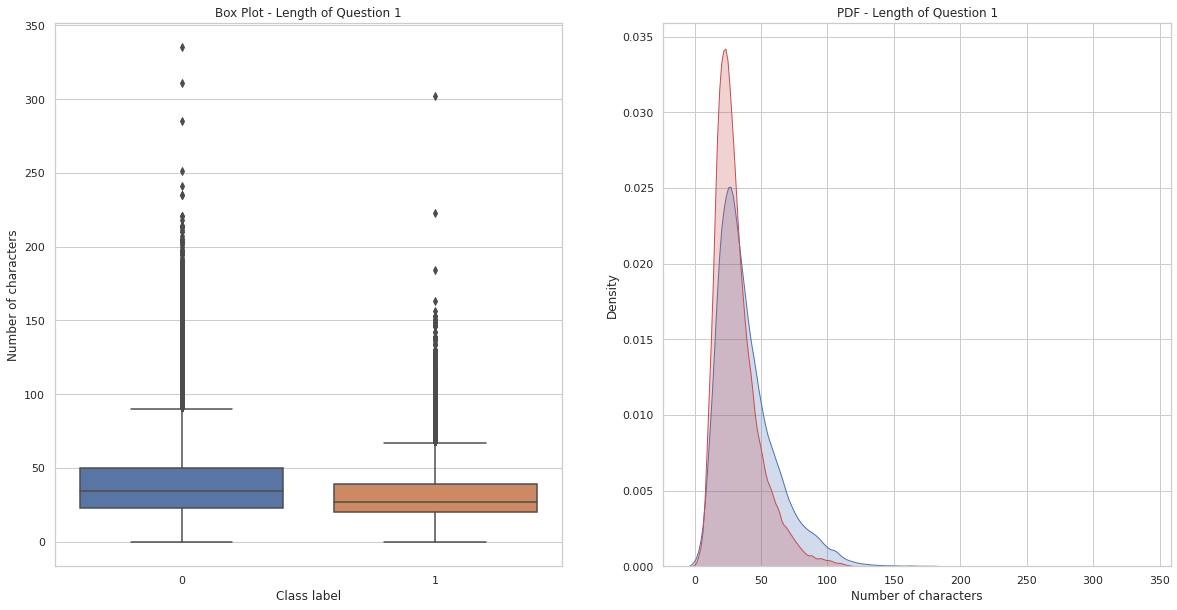

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='q1_len', data=train_data)
plt.title('Box Plot - Length of Question 1')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['q1_len'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['q1_len'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Length of Question 1')
plt.xlabel('Number of characters')

plt.show()

### Feature: q2_len

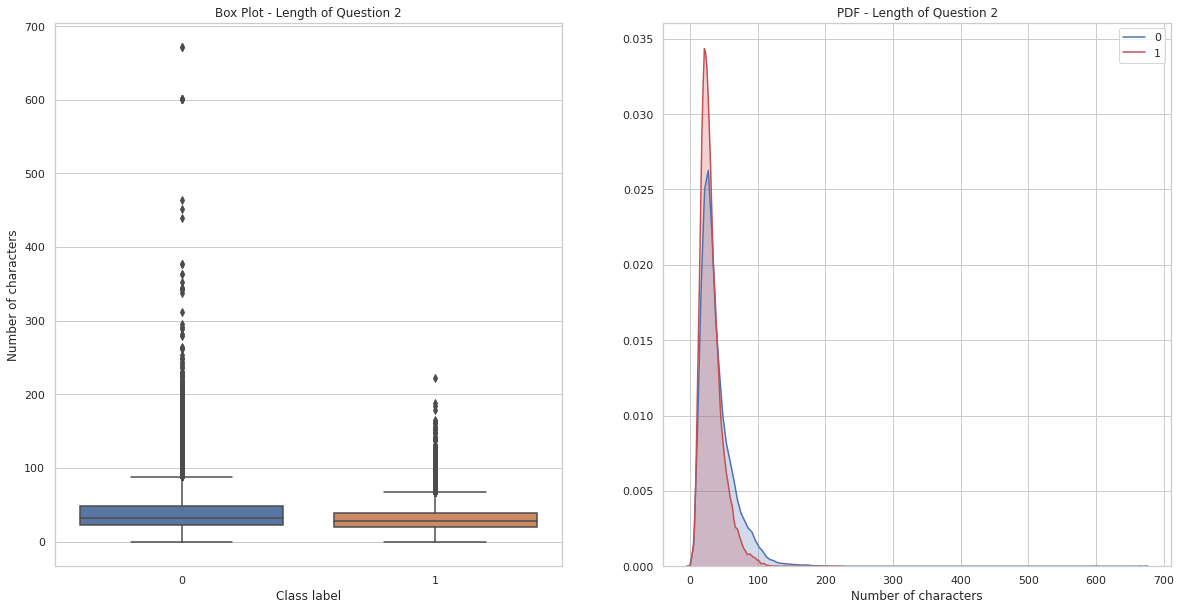

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='q2_len', data=train_data)
plt.title('Box Plot - Length of Question 2')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['q2_len'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['q2_len'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Length of Question 2')
plt.xlabel('Number of characters')

plt.show()

### Feature: q1_words

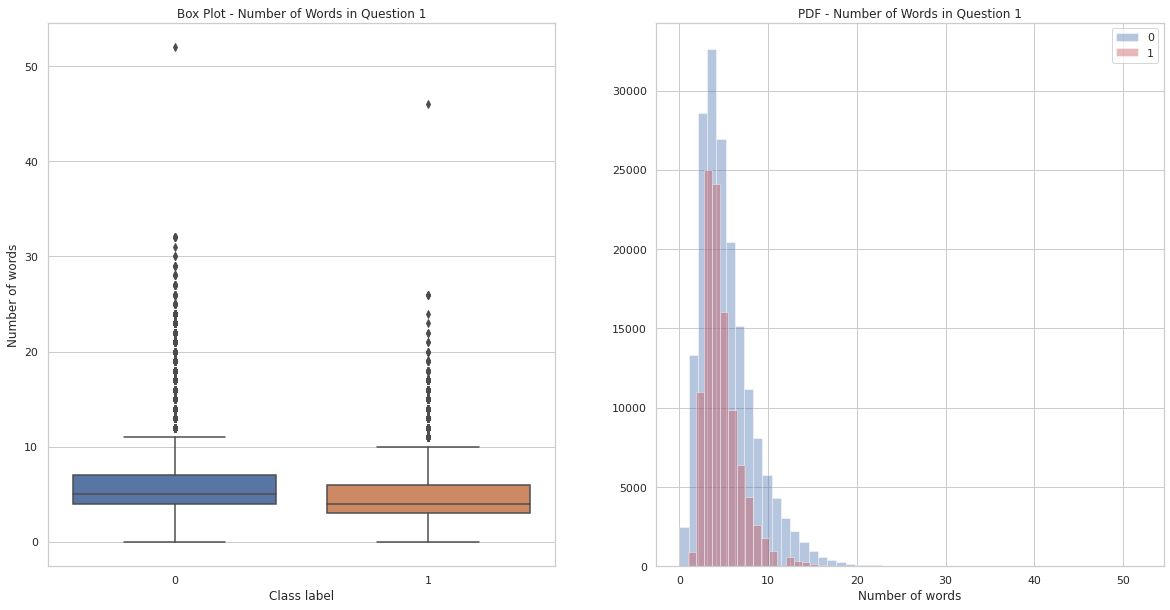

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='q1_words', data=train_data)
plt.title('Box Plot - Number of Words in Question 1')
plt.xlabel('Class label')
plt.ylabel('Number of words')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['q1_words'], hist=True, kde=False, label='0', color=colors[0])
sns.distplot(train_data[train_data['is_duplicate']==1]['q1_words'], hist=True, kde=False, label='1', color=colors[3])
plt.title('PDF - Number of Words in Question 1')
plt.xlabel('Number of words')
plt.legend()

plt.show()

### Feature: q2_words

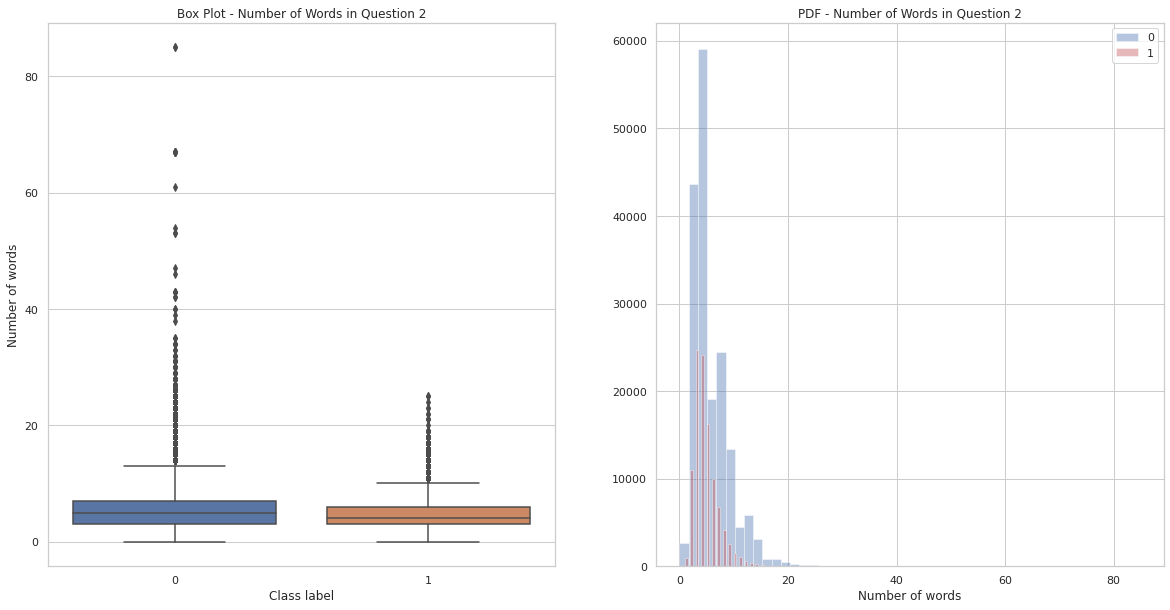

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='q2_words', data=train_data)
plt.title('Box Plot - Number of Words in Question 2')
plt.xlabel('Class label')
plt.ylabel('Number of words')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['q2_words'], hist=True, kde=False, label='0', color=colors[0])
sns.distplot(train_data[train_data['is_duplicate']==1]['q2_words'], hist=True, kde=False, label='1', color=colors[3])
plt.title('PDF - Number of Words in Question 2')
plt.xlabel('Number of words')
plt.legend()

plt.show()

### Feature: words_total

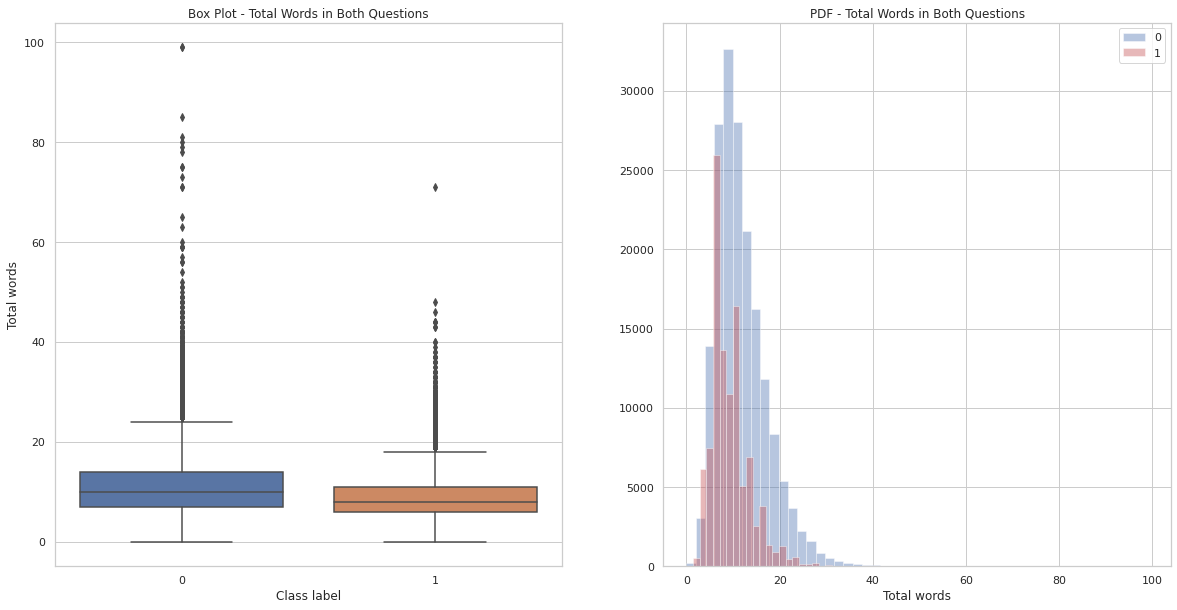

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='words_total', data=train_data)
plt.title('Box Plot - Total Words in Both Questions')
plt.xlabel('Class label')
plt.ylabel('Total words')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['words_total'], hist=True, kde=False, label='0', color=colors[0])
sns.distplot(train_data[train_data['is_duplicate']==1]['words_total'], hist=True, kde=False, label='1', color=colors[3])
plt.title('PDF - Total Words in Both Questions')
plt.xlabel('Total words')
plt.legend()

plt.show()

### Feature: words_common

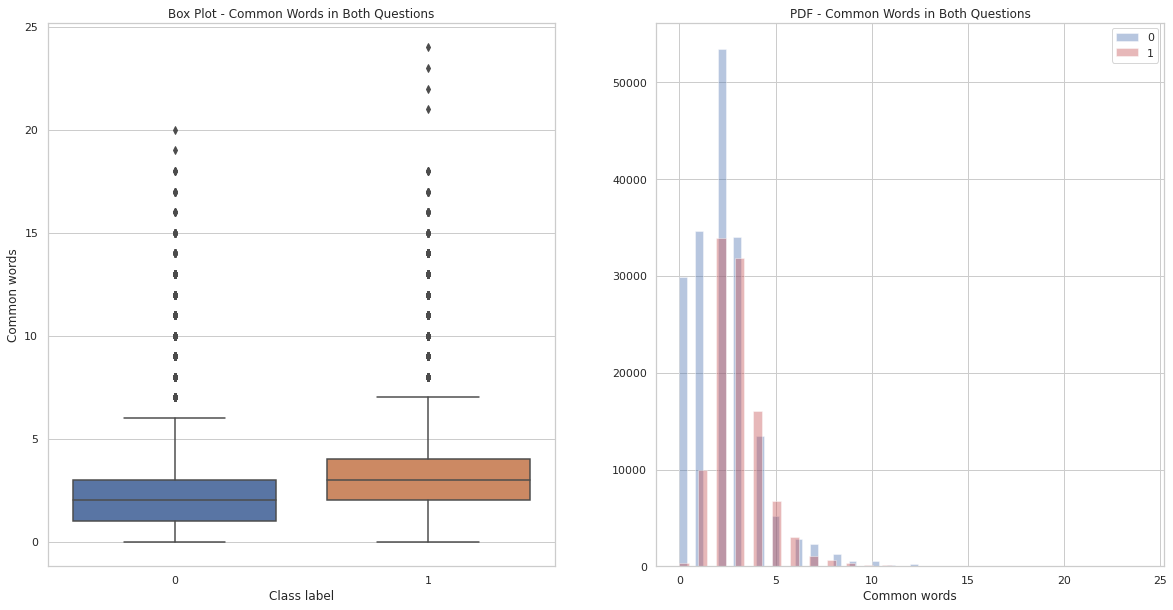

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='words_common', data=train_data)
plt.title('Box Plot - Common Words in Both Questions')
plt.xlabel('Class label')
plt.ylabel('Common words')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['words_common'], hist=True, kde=False, label='0', color=colors[0])
sns.distplot(train_data[train_data['is_duplicate']==1]['words_common'], hist=True, kde=False, label='1', color=colors[3])
plt.title('PDF - Common Words in Both Questions')
plt.xlabel('Common words')
plt.legend()

plt.show()

### Feature: words_shared

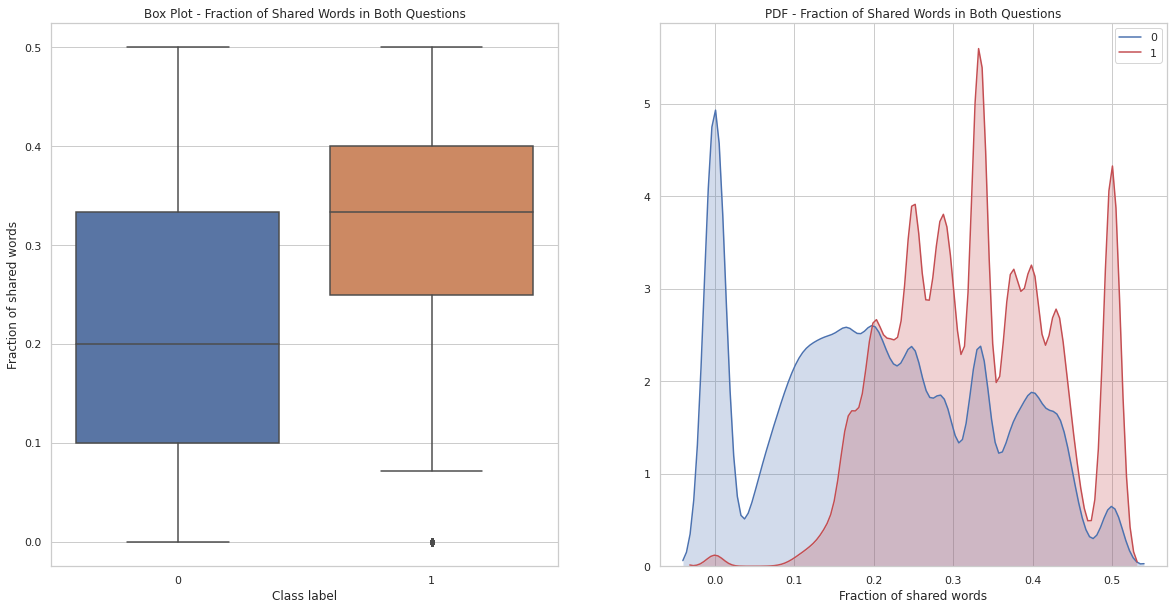

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='words_shared', data=train_data)
plt.title('Box Plot - Fraction of Shared Words in Both Questions')
plt.xlabel('Class label')
plt.ylabel('Fraction of shared words')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['words_shared'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['words_shared'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Fraction of Shared Words in Both Questions')
plt.xlabel('Fraction of shared words')

plt.show()

### Feature: cwc_min

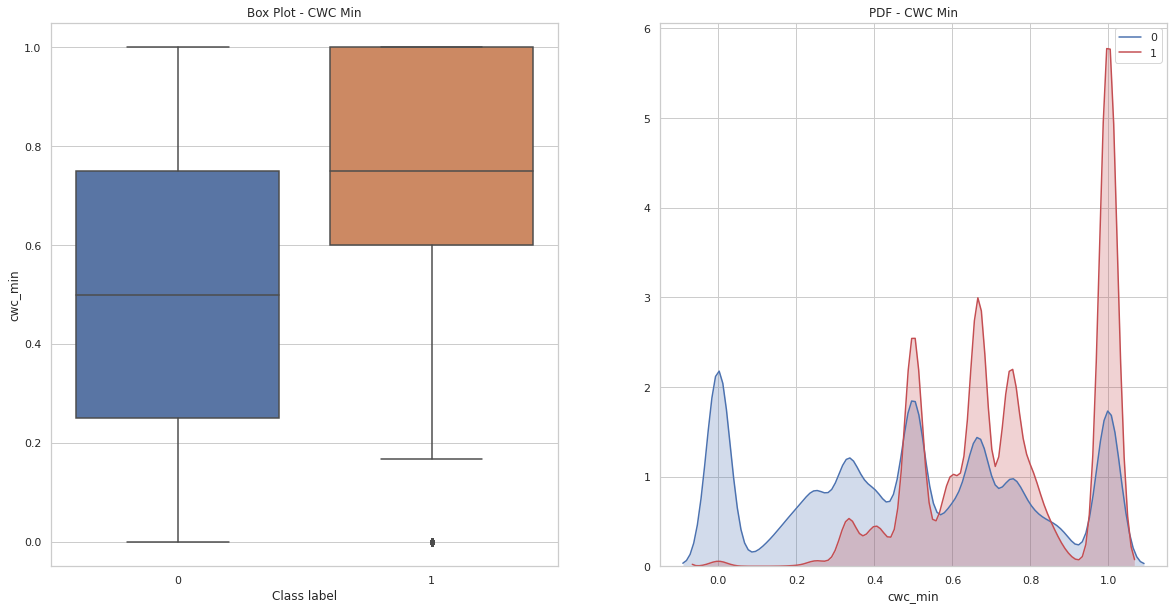

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='cwc_min', data=train_data)
plt.title('Box Plot - CWC Min')
plt.xlabel('Class label')
plt.ylabel('cwc_min')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['cwc_min'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['cwc_min'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - CWC Min')
plt.xlabel('cwc_min')

plt.show()

### Feature: cwc_max

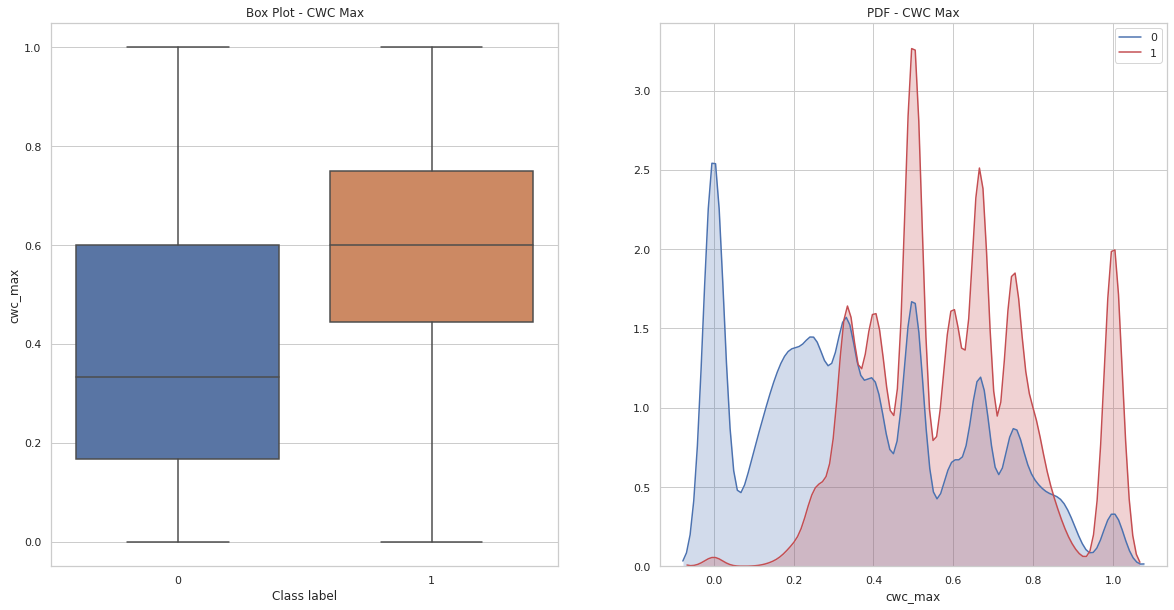

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='cwc_max', data=train_data)
plt.title('Box Plot - CWC Max')
plt.xlabel('Class label')
plt.ylabel('cwc_max')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['cwc_max'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['cwc_max'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - CWC Max')
plt.xlabel('cwc_max')

plt.show()

### Feature: csc_min

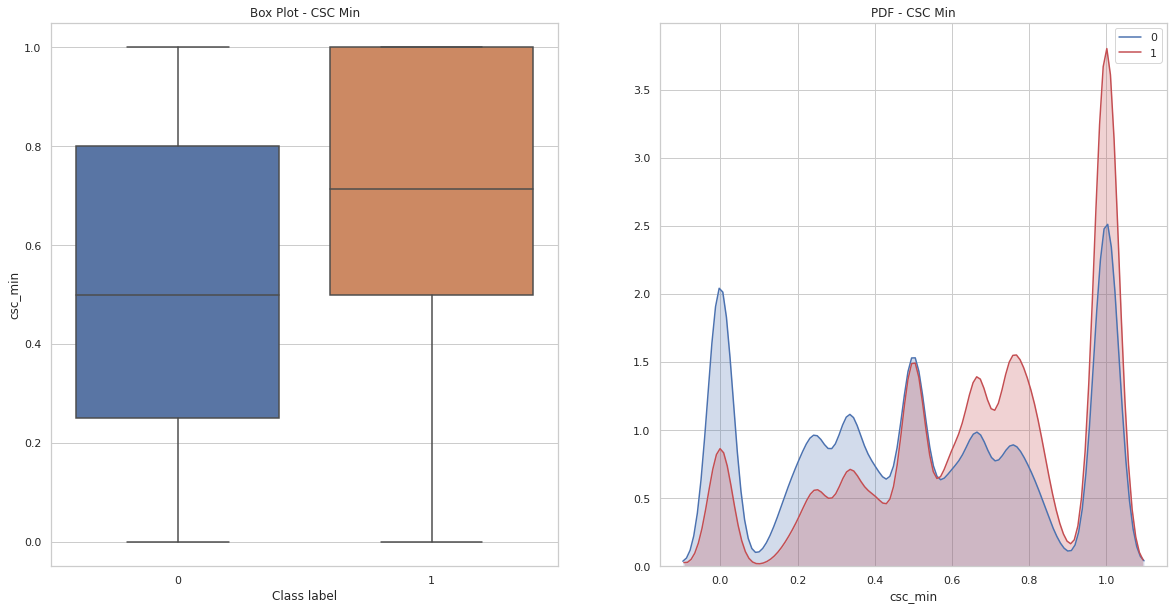

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='csc_min', data=train_data)
plt.title('Box Plot - CSC Min')
plt.xlabel('Class label')
plt.ylabel('csc_min')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['csc_min'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['csc_min'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - CSC Min')
plt.xlabel('csc_min')

plt.show()

### Feature: csc_max

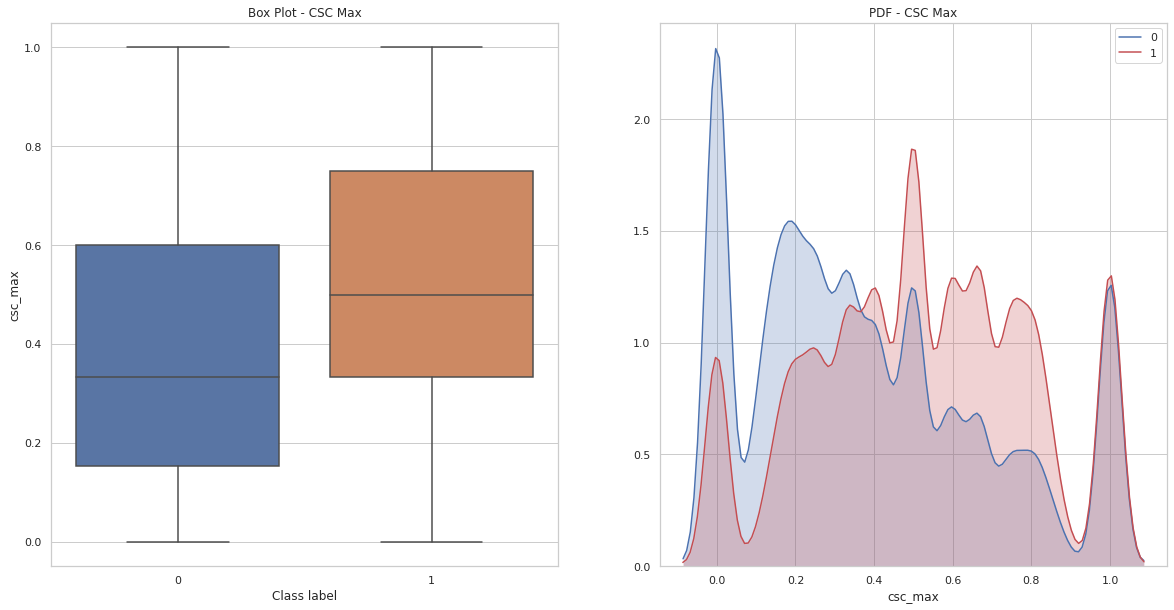

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='csc_max', data=train_data)
plt.title('Box Plot - CSC Max')
plt.xlabel('Class label')
plt.ylabel('csc_max')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['csc_max'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['csc_max'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - CSC Max')
plt.xlabel('csc_max')

plt.show()

### Feature: ctc_min

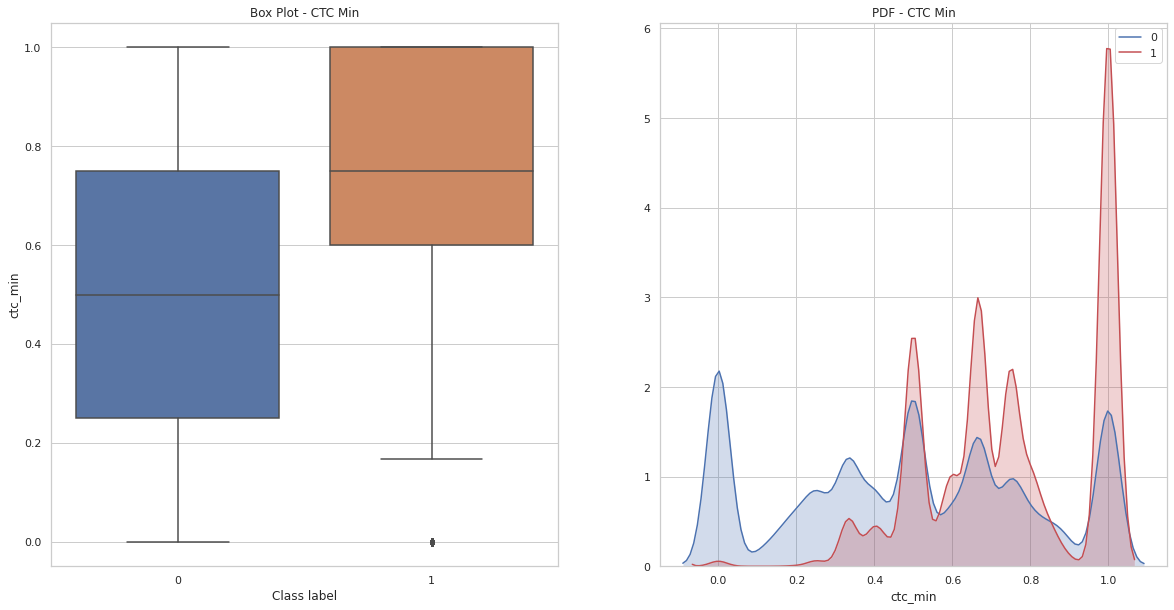

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='ctc_min', data=train_data)
plt.title('Box Plot - CTC Min')
plt.xlabel('Class label')
plt.ylabel('ctc_min')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['ctc_min'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['ctc_min'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - CTC Min')
plt.xlabel('ctc_min')

plt.show()

### Feature: ctc_max

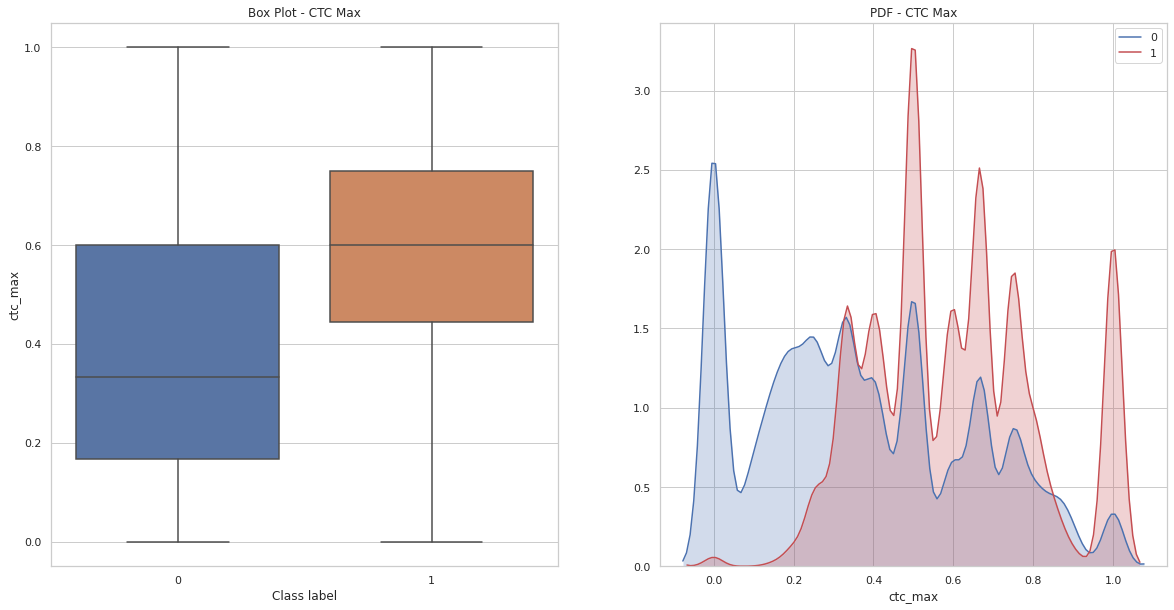

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='ctc_max', data=train_data)
plt.title('Box Plot - CTC Max')
plt.xlabel('Class label')
plt.ylabel('ctc_max')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['ctc_max'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['ctc_max'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - CTC Max')
plt.xlabel('ctc_max')

plt.show()

### Feature: last_word_eq

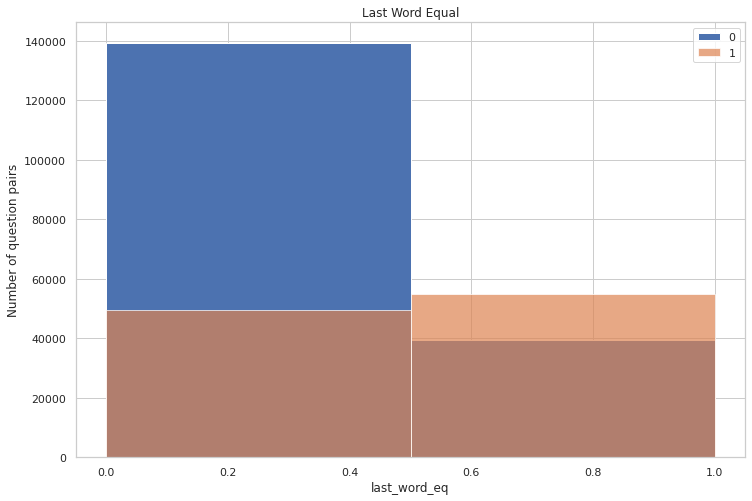

In [ ]:
plt.figure(figsize=(12, 8))

# Histogram
plt.hist(train_data[train_data['is_duplicate']==0]['last_word_eq'], bins=2, label='0')
plt.hist(train_data[train_data['is_duplicate']==1]['last_word_eq'], bins=2, label='1', alpha=0.7)
plt.title('Last Word Equal')
plt.xlabel('last_word_eq')
plt.ylabel('Number of question pairs')
plt.legend()

plt.show()

### Feature: first_word_eq

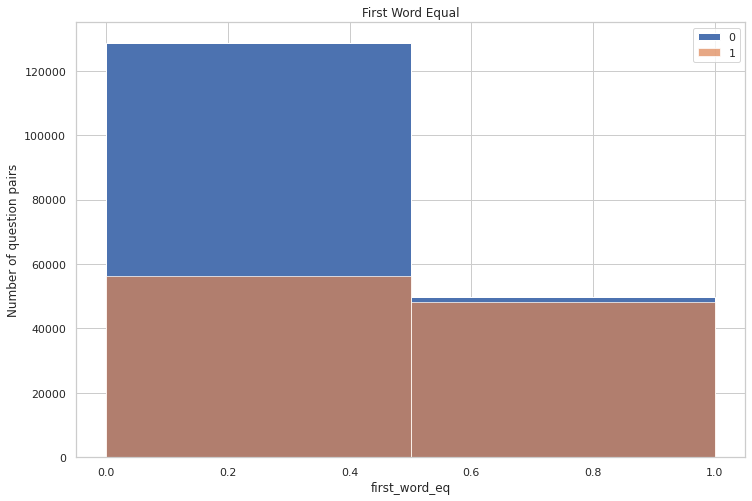

In [ ]:
plt.figure(figsize=(12, 8))

# Histogram
plt.hist(train_data[train_data['is_duplicate']==0]['first_word_eq'], bins=2, label='0')
plt.hist(train_data[train_data['is_duplicate']==1]['first_word_eq'], bins=2, label='1', alpha=0.7)
plt.title('First Word Equal')
plt.xlabel('first_word_eq')
plt.ylabel('Number of question pairs')
plt.legend()

plt.show()

### Feature: num_common_adj

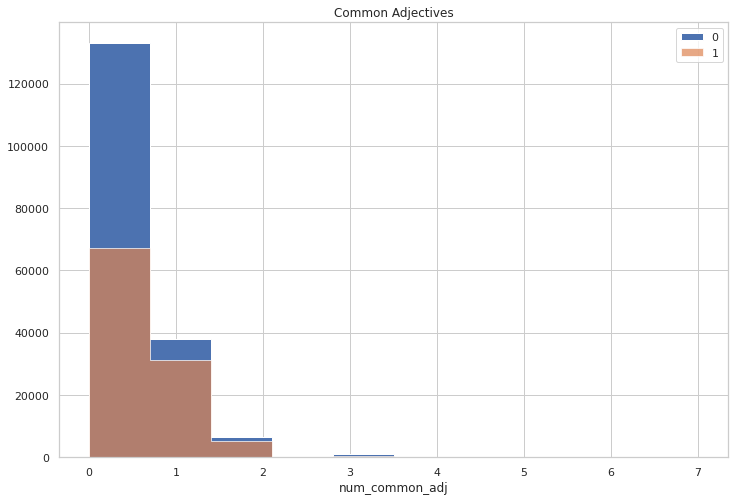

In [ ]:
plt.figure(figsize=(12, 8))

# Histogram
plt.hist(train_data[train_data['is_duplicate']==0]['num_common_adj'], bins=None, label='0', histtype='stepfilled')
plt.hist(train_data[train_data['is_duplicate']==1]['num_common_adj'], bins=None, label='1', alpha=0.7, histtype='stepfilled')
plt.title('Common Adjectives')
plt.xlabel('num_common_adj')
plt.legend()

plt.show()

### Feature: num_common_prn

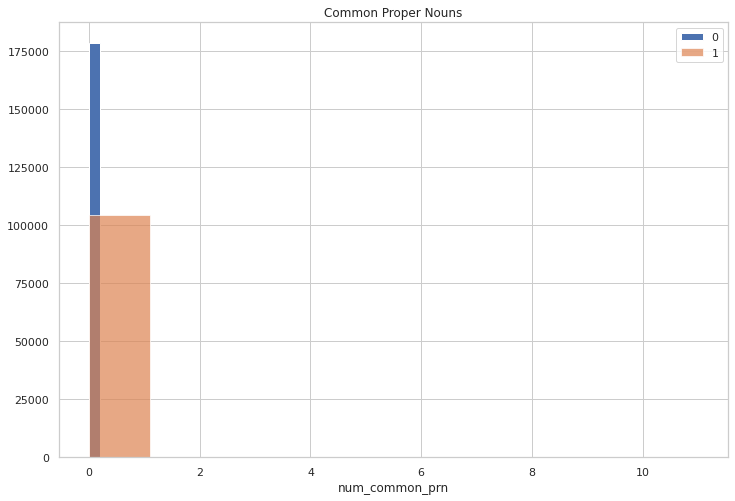

In [ ]:
plt.figure(figsize=(12, 8))

# Histogram
plt.hist(train_data[train_data['is_duplicate']==0]['num_common_prn'], bins=None, label='0', histtype='stepfilled')
plt.hist(train_data[train_data['is_duplicate']==1]['num_common_prn'], bins=None, label='1', alpha=0.7, histtype='stepfilled')

plt.title('Common Proper Nouns')
plt.xlabel('num_common_prn')
plt.legend()

plt.show()

### Feature: num_common_n

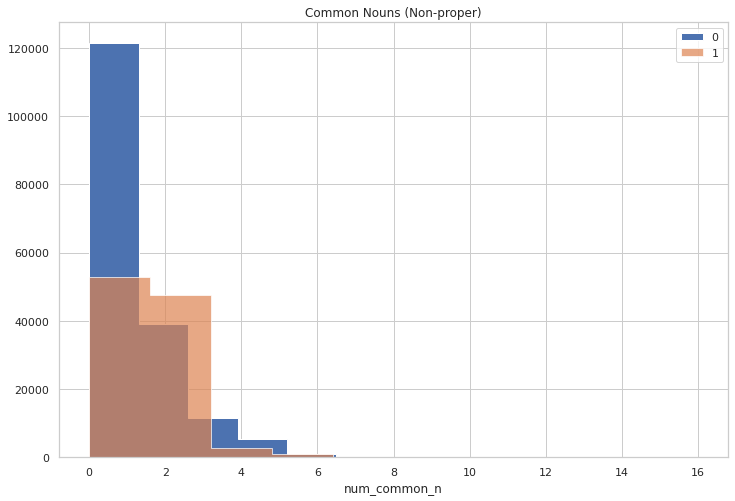

In [ ]:
plt.figure(figsize=(12, 8))

# Histogram
plt.hist(train_data[train_data['is_duplicate']==0]['num_common_n'], bins=None, label='0', histtype='stepfilled')
plt.hist(train_data[train_data['is_duplicate']==1]['num_common_n'], bins=None, label='1', alpha=0.7, histtype='stepfilled')

plt.title('Common Nouns (Non-proper)')
plt.xlabel('num_common_n')
plt.legend()

plt.show()

### Feature: fuzz_ratio

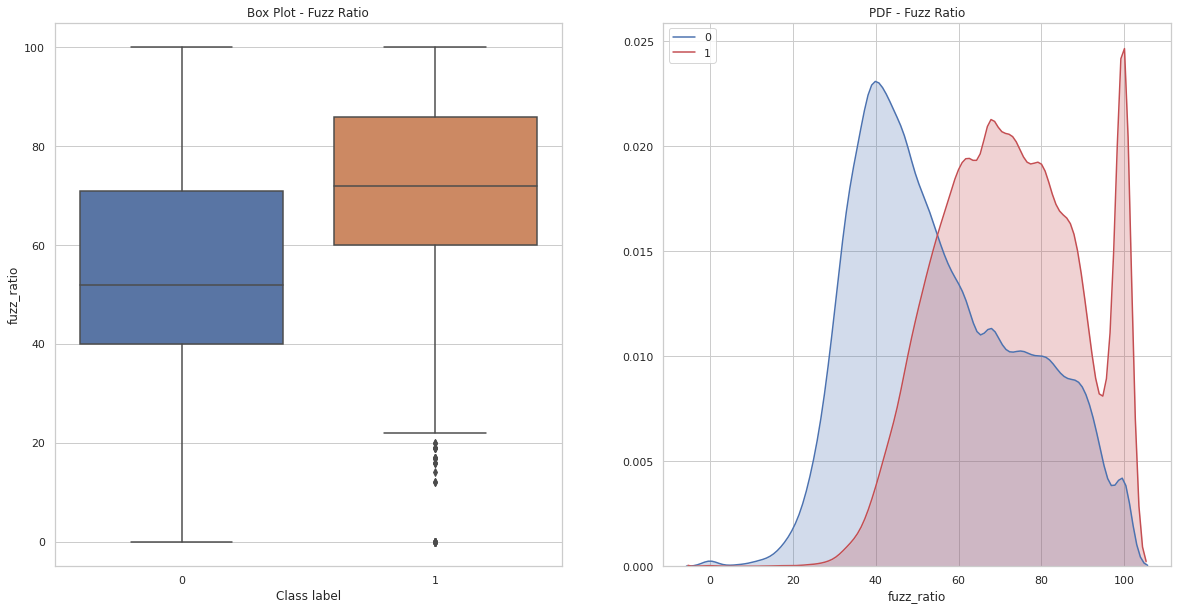

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='fuzz_ratio', data=train_data)
plt.title('Box Plot - Fuzz Ratio')
plt.xlabel('Class label')
plt.ylabel('fuzz_ratio')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['fuzz_ratio'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['fuzz_ratio'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Fuzz Ratio')
plt.xlabel('fuzz_ratio')

plt.show()

### Feature: fuzz_partial_ratio

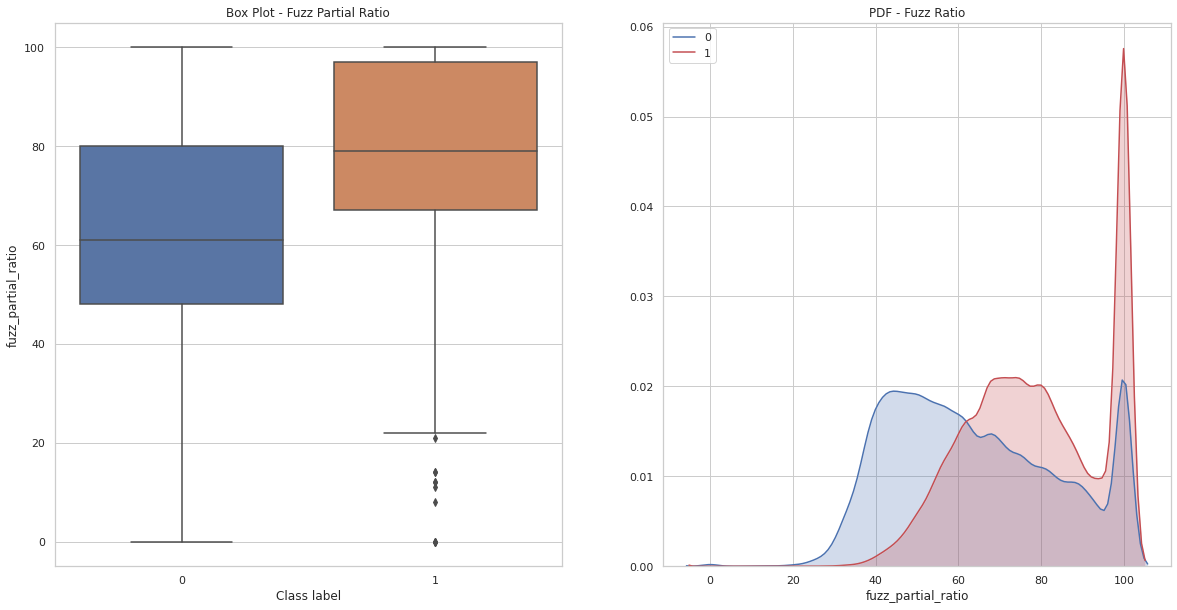

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='fuzz_partial_ratio', data=train_data)
plt.title('Box Plot - Fuzz Partial Ratio')
plt.xlabel('Class label')
plt.ylabel('fuzz_partial_ratio')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['fuzz_partial_ratio'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['fuzz_partial_ratio'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Fuzz Ratio')
plt.xlabel('fuzz_partial_ratio')

plt.show()

### Feature: token_sort_ratio

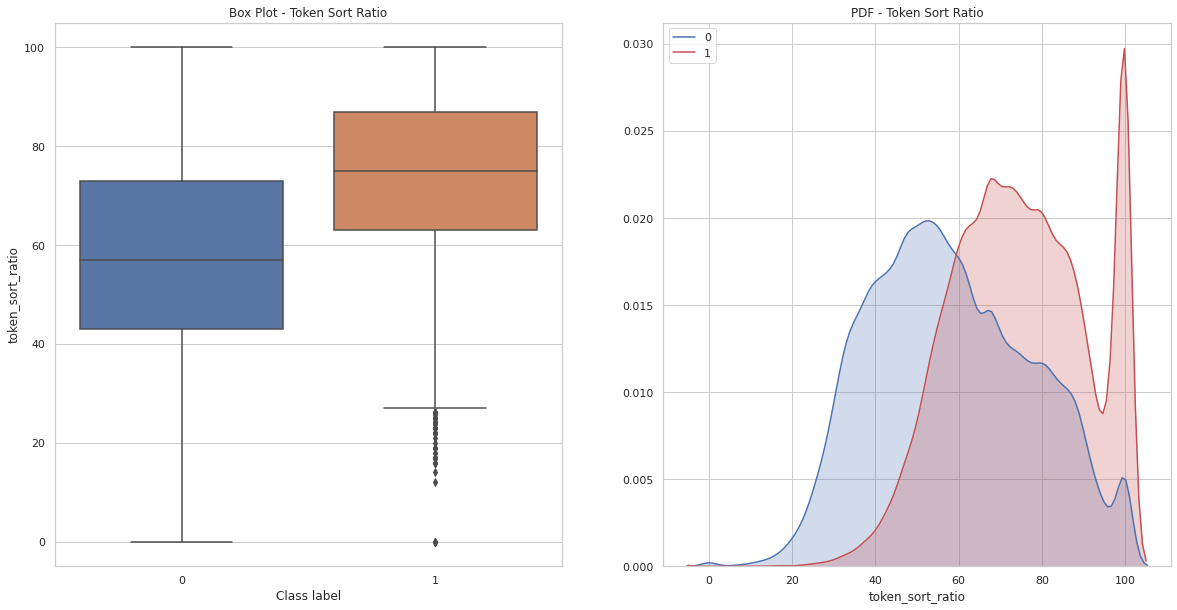

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='token_sort_ratio', data=train_data)
plt.title('Box Plot - Token Sort Ratio')
plt.xlabel('Class label')
plt.ylabel('token_sort_ratio')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['token_sort_ratio'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['token_sort_ratio'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Token Sort Ratio')
plt.xlabel('token_sort_ratio')

plt.show()

### Feature: token_set_ratio

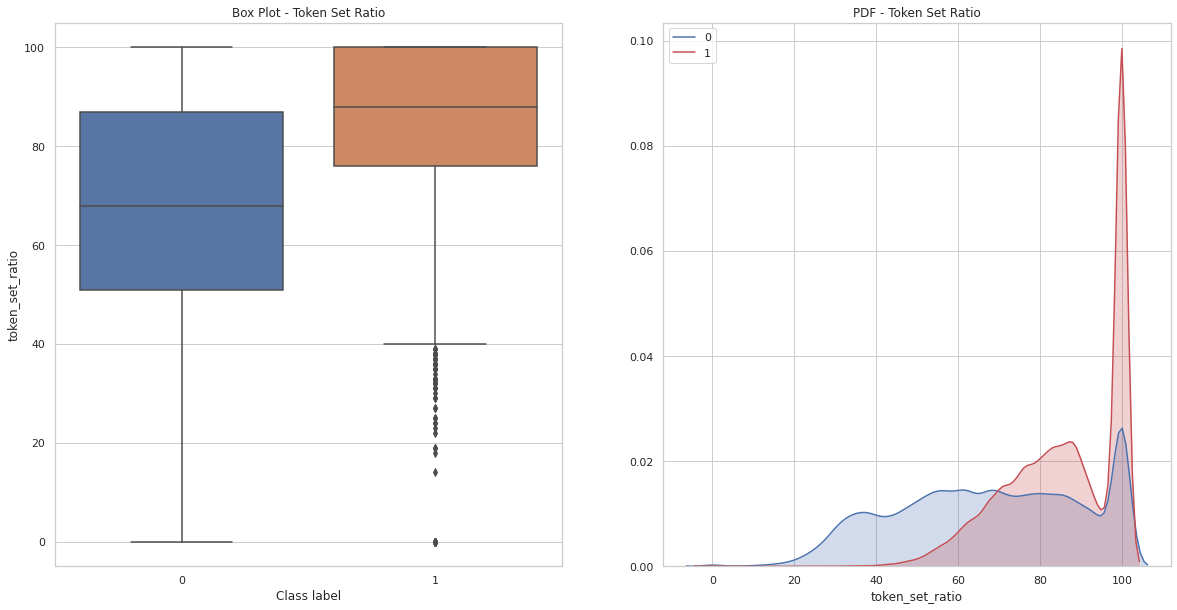

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='token_set_ratio', data=train_data)
plt.title('Box Plot - Token Set Ratio')
plt.xlabel('Class label')
plt.ylabel('token_set_ratio')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['token_set_ratio'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['token_set_ratio'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Token Set Ratio')
plt.xlabel('token_set_ratio')

plt.show()

### Feature: mean_len

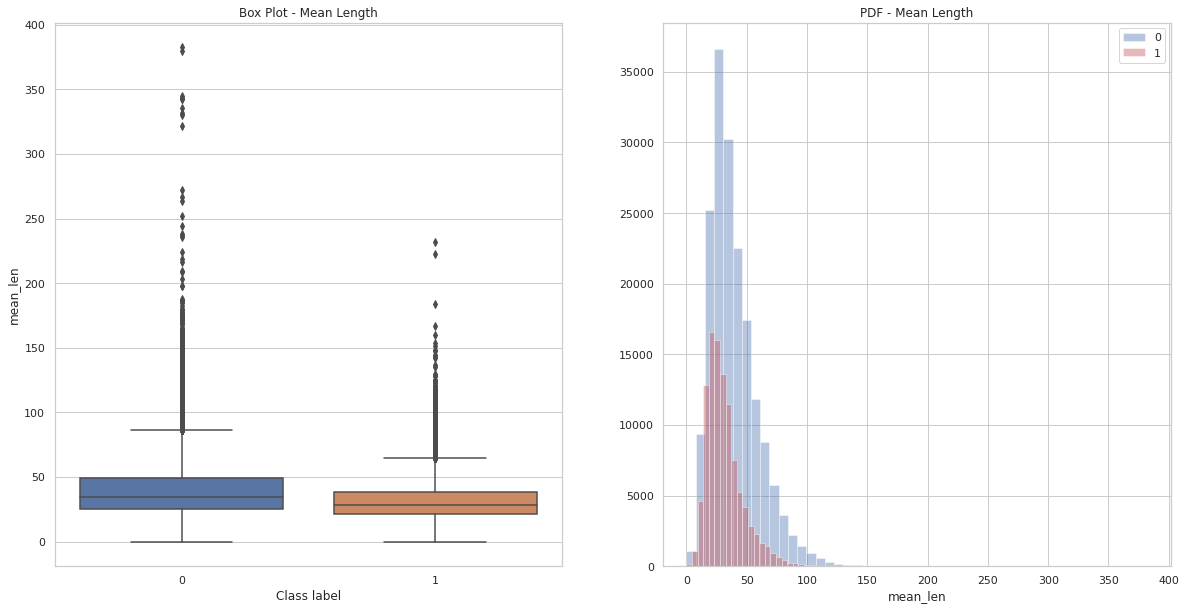

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='mean_len', data=train_data)
plt.title('Box Plot - Mean Length')
plt.xlabel('Class label')
plt.ylabel('mean_len')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['mean_len'], hist=True, kde=False, label='0', color=colors[0])
sns.distplot(train_data[train_data['is_duplicate']==1]['mean_len'], hist=True, kde=False, label='1', color=colors[3])
plt.title('PDF - Mean Length')
plt.xlabel('mean_len')
plt.legend()

plt.show()

### Feature: abs_len_diff

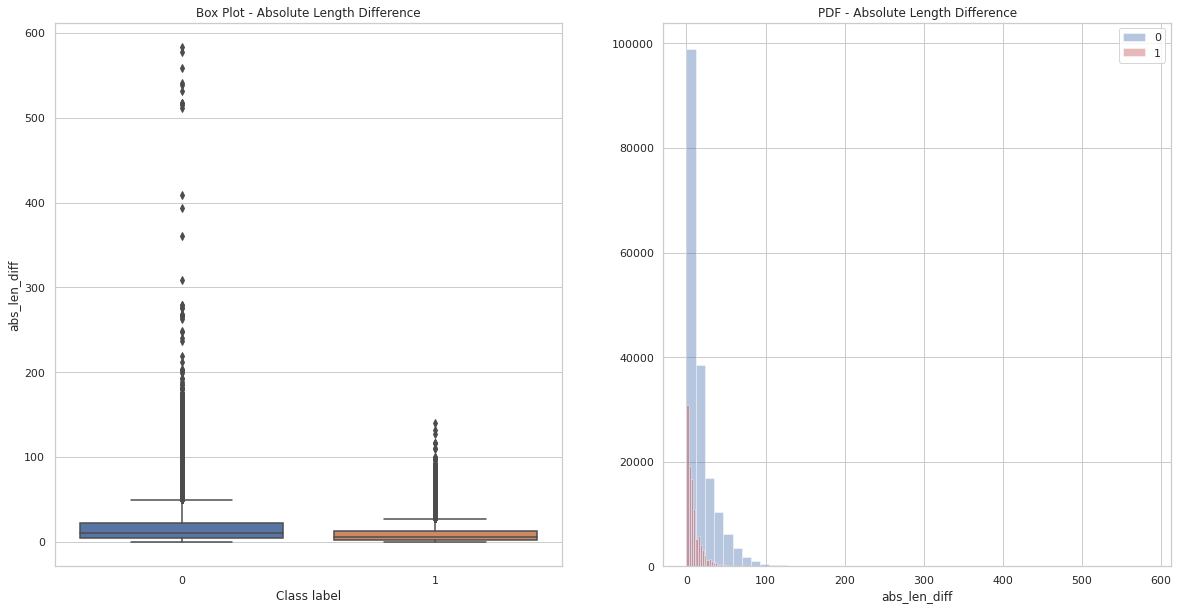

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='abs_len_diff', data=train_data)
plt.title('Box Plot - Absolute Length Difference')
plt.xlabel('Class label')
plt.ylabel('abs_len_diff')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['abs_len_diff'], hist=True, kde=False, label='0', color=colors[0])
sns.distplot(train_data[train_data['is_duplicate']==1]['abs_len_diff'], hist=True, kde=False, label='1', color=colors[3])
plt.title('PDF - Absolute Length Difference')
plt.xlabel('abs_len_diff')
plt.legend()

plt.show()

### Feature: longest_substr_ratio

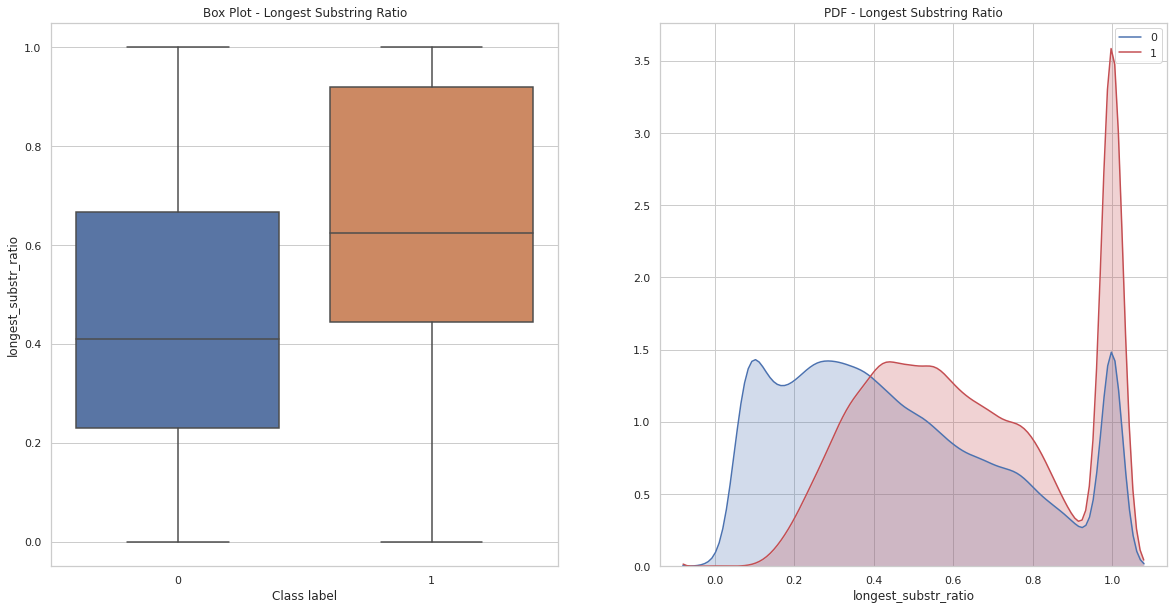

In [ ]:
plt.figure(figsize=(20, 10))

# Box plot
plt.subplot(1, 2, 1)

sns.boxplot(x=train_labels, y='longest_substr_ratio', data=train_data)
plt.title('Box Plot - Longest Substring Ratio')
plt.xlabel('Class label')
plt.ylabel('longest_substr_ratio')

# PDF
plt.subplot(1, 2, 2)

sns.distplot(train_data[train_data['is_duplicate']==0]['longest_substr_ratio'], hist=False, label='0', color=colors[0], kde_kws={'shade': True})
sns.distplot(train_data[train_data['is_duplicate']==1]['longest_substr_ratio'], hist=False, label='1', color=colors[3], kde_kws={'shade': True})
plt.title('PDF - Longest Substring Ratio')
plt.xlabel('longest_substr_ratio')

plt.show()

I was a little skeptical about having both min and max features but they did end up providing different distributions, that's good news. However, the ctc features have the same distribution as the cwc features. I'll be dropping ctc features because of this. Also, fuzz_ratio and token_sort_ratio are also very similar to each other. Since token_sort_ratio is conidered to be somewhat more powerful than fuzz_ratio, I'll be dropping fuzz_ratio. Apart from these features, all other features do provide some degree of separation of the classes. Some of these features may interact to provide richer features, like q1_len and q2_len. Let's see how they interact with each other.

###Pair Plots

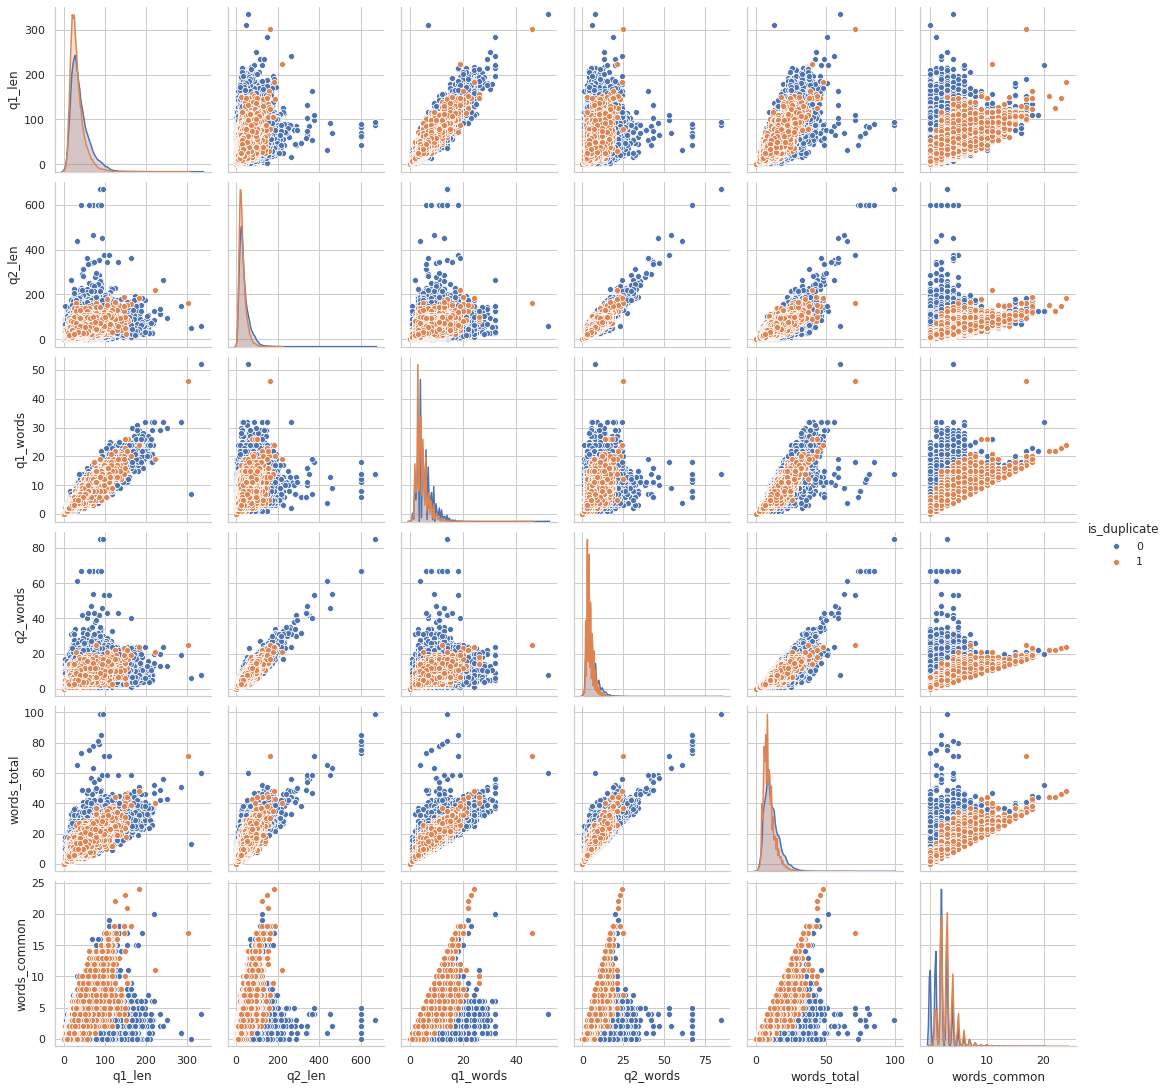

In [ ]:
# Pair plot
sns.pairplot(data=train_data, hue='is_duplicate', vars=['q1_len', 'q2_len', 'q1_words', 'q2_words', 'words_total', 'words_common'])

plt.show()

The above graphs looks good. All feature interactions show good separability. Seeing how all this is without even leveraging word vectors, I'm quite happy with the results.

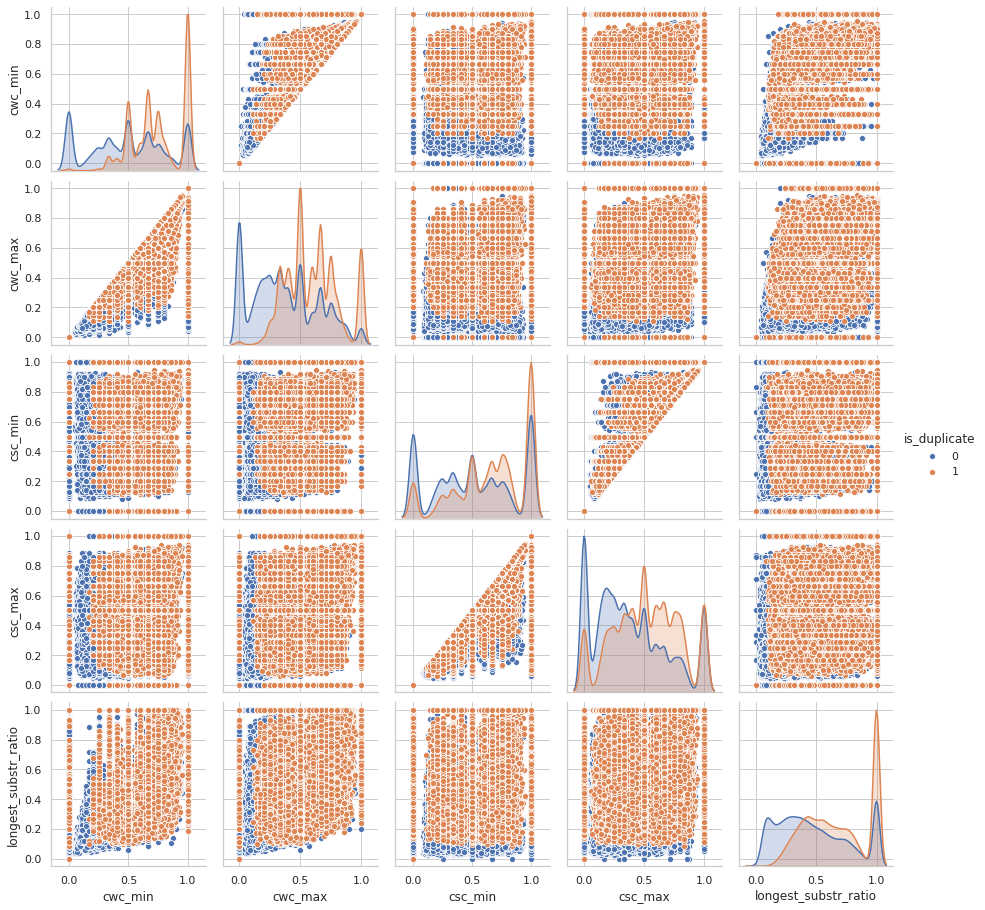

In [ ]:
# Pair plot
sns.pairplot(data=train_data, hue='is_duplicate', vars=['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'longest_substr_ratio'])

plt.show()

However, these features don't seem to interact in any interesting ways. However they are still worth keeping as on their own, they do a good job of separating the classes.

Looks like the words 'differ' and 'best' seem to appear quite often in both duplicate and non duplicate pairs. You know what this means, let's add them to our stop words set and run the preprocessing module again. Now it is important to note that these are stemmed words. We would have to add their unstemmed versions in our stop words set.

### Word clouds for duplicate and non duplicate pairs

In [ ]:
# Splitting using class label
dup = train_data[train_data['is_duplicate']==1]
non_dup = train_data[train_data['is_duplicate']==0]

# Flattening to get 1D array
dup = np.array([dup['question1'], dup['question2']]).flatten()
non_dup = np.array([non_dup['question1'], non_dup['question2']]).flatten()

# Converting into one single string for word cloud
dup_str = ' '.join(dup)
non_dup_str = ' '.join(non_dup)

# Creating stopwords set, we use the same set we did while preprocessing
# Technically, this shouldnt change anything as we have already filtered the sentences
stop_words = set(stopwords.words('english'))

Word cloud for duplicate pairs


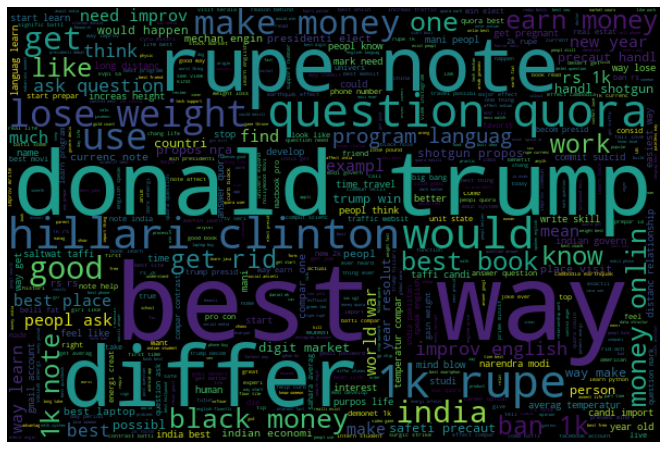

In [ ]:
# Generate duplicate pair word cloud
word_cloud = WordCloud(background_color='black', max_words=len(dup_str), stopwords=stop_words, width=600, height=400)
word_cloud.generate(dup_str)

print('Word cloud for duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Word cloud for non duplicate pairs


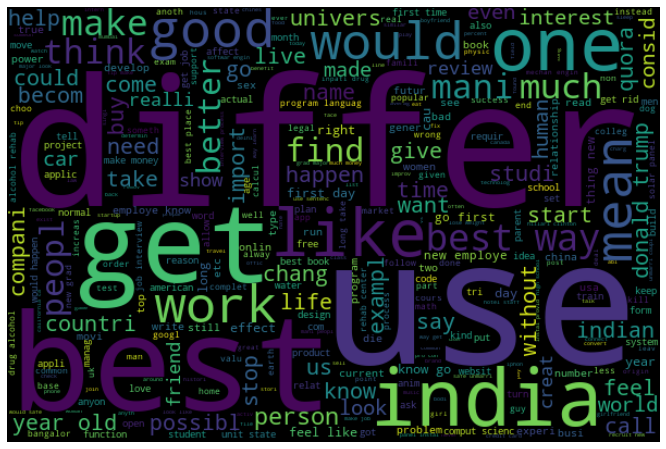

In [ ]:
# Generate non duplicate pair word cloud
word_cloud = WordCloud(background_color='black', max_words=len(non_dup_str), stopwords=stop_words, width=600, height=400)
word_cloud.generate(non_dup_str)

print('Word cloud for non duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

### Word clouds for duplicate and non duplicate pairs (after adding stopwords from previous word cloud)

In [ ]:
# Splitting using class label
dup = train_data[train_data['is_duplicate']==1]
non_dup = train_data[train_data['is_duplicate']==0]

# Flattening to get 1D array
dup = np.array([dup['question1'], dup['question2']]).flatten()
dup = [str(word) for word in dup]

non_dup = np.array([non_dup['question1'], non_dup['question2']]).flatten()
non_dup = [str(word) for word in non_dup]


# Converting into one single string for word cloud
dup_str = ' '.join(dup)
non_dup_str = ' '.join(non_dup)

# Creating stopwords set, we use the same set we did while preprocessing
# Technically, this shouldnt change anything as we have already filtered the sentences
stop_words = set(stopwords.words('english'))

Word cloud for duplicate pairs


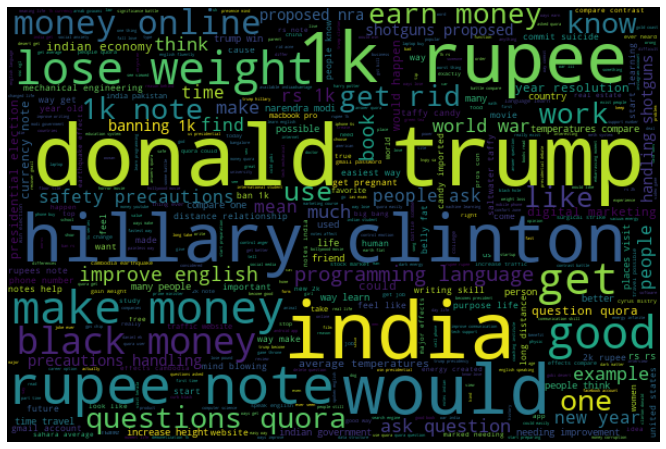

In [ ]:
# Generate duplicate pair word cloud
word_cloud = WordCloud(background_color='black', max_words=len(dup_str), stopwords=stop_words, width=600, height=400)
word_cloud.generate(dup_str)

print('Word cloud for duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Word cloud for non duplicate pairs


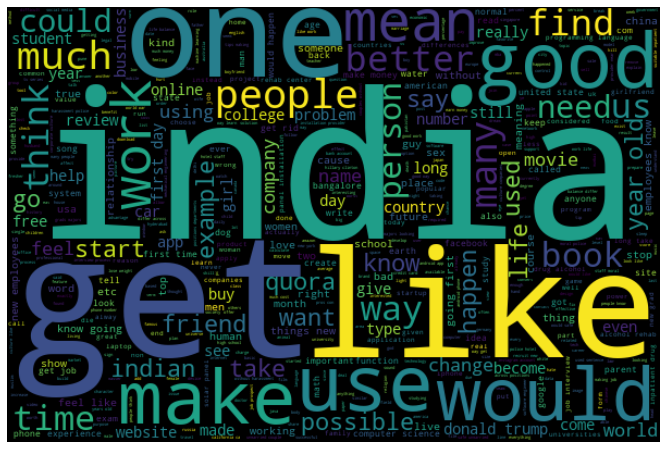

In [ ]:
# Generate non duplicate pair word cloud
word_cloud = WordCloud(background_color='black', max_words=len(non_dup_str), stopwords=stop_words, width=600, height=400)
word_cloud.generate(non_dup_str)

print('Word cloud for non duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

## Creating Word Vectors

### Dropping features


In [ ]:
# Dropping features
train_data = train_data.drop(columns=['ctc_min', 'ctc_max', 'fuzz_ratio'])
test_data = test_data.drop(columns=['ctc_min', 'ctc_max', 'fuzz_ratio'])

# Encoding questions as unicode
train_data['question1'] = train_data['question1'].apply(lambda x: str(x))
train_data['question2'] = train_data['question2'].apply(lambda x: str(x))

test_data['question1'] = test_data['question1'].apply(lambda x: str(x))
test_data['question2'] = test_data['question2'].apply(lambda x: str(x))

### TF - IDF embedding
Let's try simple TF-IDF vectors without any contraints. I'm expecting enormous dimensionality but this gives us a benchmark. Then any complex vectorization we perform should definetly perform better than this.

In [ ]:
# Initialize vectorizer
vectorizer = TfidfVectorizer(lowercase=False)

# Put all questions (1 and 2) into one list
questions = list(list(train_data['question1']) + list(train_data['question2']))

# Fit the vectorizer
print('Fitting')
vectorizer.fit(questions)

# Vectorizing question1
print('Vectorizing question1')
q1_vecs_tfidf_train = vectorizer.transform(train_data['question1'].values)
q1_vecs_tfidf_test = vectorizer.transform(test_data['question1'].values)

# Vectorizing question2
print('Vectorizing question2')
q2_vecs_tfidf_train = vectorizer.transform(train_data['question2'].values)
q2_vecs_tfidf_test = vectorizer.transform(test_data['question2'].values)

# Mapping terms to their IDF values
print('Mapping terms to their IDF values')
idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

print('Converting to DataFrames')
q1_tfidf_train = pd.DataFrame.sparse.from_spmatrix(q1_vecs_tfidf_train)
q2_tfidf_train = pd.DataFrame.sparse.from_spmatrix(q2_vecs_tfidf_train)

q1_tfidf_test = pd.DataFrame.sparse.from_spmatrix(q1_vecs_tfidf_test)
q2_tfidf_test = pd.DataFrame.sparse.from_spmatrix(q2_vecs_tfidf_test)

Fitting
Vectorizing question1
Vectorizing question2
Mapping terms to their IDF values
Converting to DataFrames


### IDF weighted average Word2Vec

In [ ]:
nlp = en_core_web_lg.load()
type(nlp)

spacy.lang.en.English

In [ ]:
# Initializing pre-trained vectors
print('Loading pre-trained word vectors model')
nlp = en_core_web_lg.load()

# Initialize list to store question vectors
q1_train_vecs = []
q2_train_vecs = []
q1_test_vecs = []
q2_test_vecs = []


# Iterate over all questions in TRAIN question1 column
print('Processing train question1')
for q in tqdm(list(train_data['question1'])):
  # Get vectors for all words in question
  doc = nlp(q)

  # This is where we store the averaged vector, each is of length 300
  mean_vec = np.zeros((len(doc[0].vector)))

  # Iterate over all words in question
  for word in doc:
    # Get word vector
    vector = word.vector

    # If word in IDF vocabulary
    if str(word) in idf:
      idf_weight = idf[str(word)]
    else:
      idf_weight = 0
    
    # Add IDF weighted vector to mean vector
    mean_vec += vector * idf_weight
  
  # Divide mean vector by number of words in question (averaged vector)
  mean_vec /= len(doc)

  # Append mean vector to list of mean vectors
  q1_train_vecs.append(mean_vec)


# Iterate over all questions in TRAIN question2 column
print('Processing train question2')
for q in tqdm(list(train_data['question2'])):
  # Get vectors for all words in question
  doc = nlp(q)

  # This is where we store the averaged vector, each is of length 300
  mean_vec = np.zeros((len(doc[0].vector)))

  # Iterate over all words in question
  for word in doc:
    # Get word vector
    vector = word.vector

    # If word in IDF vocabulary
    if str(word) in idf:
      idf_weight = idf[str(word)]
    else:
      idf_weight = 0
    
    # Add IDF weighted vector to mean vector
    mean_vec += vector * idf_weight
  
  # Divide mean vector by number of words in question (averaged vector)
  mean_vec /= len(doc)

  # Append mean vector to list of mean vectors
  q2_train_vecs.append(mean_vec) 


# Iterate over all questions in TEST question1 column
print('Processing test question1')
for q in tqdm(list(test_data['question1'])):
  # Get vectors for all words in question
  doc = nlp(q)

  # This is where we store the averaged vector, each is of length 300
  mean_vec = np.zeros((len(doc[0].vector)))

  # Iterate over all words in question
  for word in doc:
    # Get word vector
    vector = word.vector

    # If word in IDF vocabulary
    if str(word) in idf:
      idf_weight = idf[str(word)]
    else:
      idf_weight = 0
    
    # Add IDF weighted vector to mean vector
    mean_vec += vector * idf_weight
  
  # Divide mean vector by number of words in question (averaged vector)
  mean_vec /= len(doc)

  # Append mean vector to list of mean vectors
  q1_test_vecs.append(mean_vec)

# Iterate over all questions in TEST question2 column
print('Processing test question2')
for q in tqdm(list(test_data['question2'])):
  # Get vectors for all words in question
  doc = nlp(q)

  # This is where we store the averaged vector, each is of length 300
  mean_vec = np.zeros((len(doc[0].vector)))

  # Iterate over all words in question
  for word in doc:
    # Get word vector
    vector = word.vector

    # If word in IDF vocabulary
    if str(word) in idf:
      idf_weight = idf[str(word)]
    else:
      idf_weight = 0
    
    # Add IDF weighted vector to mean vector
    mean_vec += vector * idf_weight
  
  # Divide mean vector by number of words in question (averaged vector)
  mean_vec /= len(doc)

  # Append mean vector to list of mean vectors
  q2_test_vecs.append(mean_vec)

# Creating DataFrames for these, (we can merge them with our main DataFrame later)
print('Converting to DataFrames')
q1_w2v_train = pd.DataFrame(q1_train_vecs, index=train_data.index)
q2_w2v_train = pd.DataFrame(q2_train_vecs, index=train_data.index)

q1_w2v_test = pd.DataFrame(q1_test_vecs, index=test_data.index)
q2_w2v_test = pd.DataFrame(q2_test_vecs, index=test_data.index)

# Save to disk
print('Saving DataFrames as .csv to disk')
print('Saving train question1')
q1_w2v_train.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_w2v_train.csv')

print('Saving train question2')
q2_w2v_train.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_w2v_train.csv')

print('Saving test question1')
q1_w2v_test.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_w2v_test.csv')

print('Saving test question2')
q2_w2v_test.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_w2v_test.csv')

#### Load from disk

In [ ]:
# Reading from disk
print('Reading .csv files from disk')
q1_w2v_train = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_w2v_train.csv')
q2_w2v_train = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_w2v_train.csv')

q1_w2v_train = q1_w2v_train.drop(columns=['Unnamed: 0'])
q2_w2v_train = q2_w2v_train.drop(columns=['Unnamed: 0'])

q1_w2v_test = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_w2v_test.csv')
q2_w2v_test = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_w2v_test.csv')

q1_w2v_test = q1_w2v_test.drop(columns=['Unnamed: 0'])
q2_w2v_test = q2_w2v_test.drop(columns=['Unnamed: 0'])

Reading .csv files from disk


### ~~Roberta embedding~~

In [ ]:
# if os.path.isfile('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_roberta_train.csv'):
#   # Reading from disk
#   print('Reading .csv file from disk')
#   q1_roberta_train = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_roberta_train.csv')
#   q2_roberta_train = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_roberta_train.csv')
  
#   q1_roberta_train = q1_roberta_train.drop(columns=['Unnamed: 0'])
#   q2_roberta_train = q2_roberta_train.drop(columns=['Unnamed: 0'])

#   q1_roberta_test = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_roberta_test.csv')
#   q2_roberta_test = pd.read_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_roberta_test.csv')
  
#   q1_roberta_test = q1_roberta_test.drop(columns=['Unnamed: 0'])
#   q2_roberta_test = q2_roberta_test.drop(columns=['Unnamed: 0'])
# else:
#   # Initializing pre-trained Roberta vectorizer
#   vectorizer = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

#   # Vectorizing question1
#   print('Vectorizing question1')
#   q1_vecs_roberta_train = vectorizer.encode(train_data['question1'].values)
#   q1_vecs_roberta_test = vectorizer.encode(test_data['question1'].values)

#   # vectorizing question2
#   print('Vectorizing question2')
#   q2_vecs_roberta_train = vectorizer.encode(train_data['question2'].values)
#   q2_vecs_roberta_test = vectorizer.encode(test_data['question2'].values)

#   # Creating DataFrames for these, (we can merge them with our main DataFrame later)
#   print('Converting to DataFrames')
#   q1_roberta_train = pd.DataFrame(q1_vecs_roberta_train, index=train_data.index)
#   q2_roberta_train = pd.DataFrame(q2_vecs_roberta_train, index=train_data.index)

#   q1_roberta_test = pd.DataFrame(q1_vecs_roberta_test, index=test_data.index)
#   q2_roberta_test = pd.DataFrame(q2_vecs_roberta_test, index=test_data.index)

#   # Save to disk
#   print('Saving DataFrames as .csv to disk')
#   q1_roberta_train.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_roberta_train.csv')
#   q2_roberta_train.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_roberta_train.csv')

#   q1_roberta_test.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q1_roberta_test.csv')
#   q2_roberta_test.to_csv('/content/drive/My Drive/QuoraQuestionPairSimilarity/q2_roberta_test.csv')

Reading .csv file from disk


Now that we have created word vectors, we can drop the question columns from our data. We can also drop the 'is_duplicate', 'qid1' and 'qid2' columns.

In [ ]:
# Dropping columns
train_data = train_data.drop(columns=['question1', 'question2', 'qid1', 'qid2', 'is_duplicate', 'id'])
test_data = test_data.drop(columns=['question1', 'question2', 'qid1', 'qid2', 'id'])

## So much data..
We have quite a few DataFrames now. Let's see how many and what they are.

**Training data**
- **train_data**: This set contains features we etracted from the tokens such as count, shared tokens etc. It contains no word vector related features.
- **q1_tfidf_train**: This set contains the TF-IDF vectorizations for question1 from the train set.
- **q2_tfidf_train**: This set contains the TF-IDF vectorizations for question2 from the train set.
- **q1_w2v_train**: This set contains the W2V vectorizations for question1 from the train set. 
- **q2_w2v_train**: This set contains the W2V vectorizations for question2 from the train set.

**Test data**
- **test_data**: This set contains features we etracted from the tokens such as count, shared tokens etc. It contains no word vector related features.
- **q1_tfidf_test**: This set contains the TF-IDF vectorizations for question1 from the test set.
- **q2_tfidf_test**: This set contains the TF-IDF vectorizations for question2 from the test set.
- **q1_w2v_test**: This set contains the W2V vectorizations for question1 from the test set. 
- **q2_w2v_test**: This set contains the W2V vectorizations for question2 from the test set.

## Model approaches
Here is how I will proceed with the meachine learning part of this assignment.
First thing is to create our data matrices.

I want to try out the following data matrices:
1. Only token features, no word vector features. Very low dimensionality but limited semantic information.
1. Token features along with cosine similarity of word vectors (RoBERTa only). Very low dimensionality and incorporates some semantic information as well.
1. Word vectors. Just the word vectors themselves. High dimensionality,  incorporates a lot of semantic information but no token information.
1. Token information along with W2V vectors and cosine similarity. This really is all the information we have, put together and fed into a model.
1. Token information along with TF - IDF vectors. Since the number of dimensions are enormous, we won't be considering GBDT for this model.


### Defining function to print confusion matrices

In [ ]:
def plot_confusion_matrices(true, pred):
  # Normal confusion matrix
  conf = confusion_matrix(true, pred)
  
  # Precision matrix
  # Precision: Out of all the points predicted of class 'A', how many are actually class 'A'
  # A column in the confusion matrix represents the data points predicted as the same class
  # So we divide all data points by the sum of points in their respective columns
  precision = (conf.T / conf.sum(axis=1)).T

  # Recall matrix
  # Recall: Out of all the points which are of class 'A', how many were predicted to be of class 'A'
  # A row in the confusion matrix represents the data points of the same class
  # So we divide all data points by the sum of points in their respective rows
  recall = (conf / conf.sum(axis=0))

  # Plotting the matrices
  plt.figure(figsize=(24,6))

  # Set axes labels
  labels = ['0', '1']

  # Set colourmap
  cmap = sns.light_palette('purple')

  # Plot normal confusion matrix
  plt.subplot(1, 3, 1)
  sns.heatmap(conf, cmap=cmap, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Plot precision confusion matrix
  plt.subplot(1, 3, 2)
  sns.heatmap(precision, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Precision Matrix')

  # Plot recall confusion matrix
  plt.subplot(1, 3, 3)
  sns.heatmap(recall, cmap=cmap, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Recall Matrix')

  plt.show()

## Model 1: Only token features

### Creating data matrices

In [ ]:
# First, let's standardize our features. We won't be standardizing the 'last_word_eq' and 'first_word_eq'
# as these are more like a yes/no indicator
# I am not standardizing the main dataframe itself as I want to preserve the actual values if I need them later

# Initialize StandardScaler
scaler = StandardScaler()

# Train data
# Getting all columns except the two specified ones
scaled = train_data.loc[:, (train_data.columns != 'last_word_eq') & (train_data.columns != 'first_word_eq')]
scaled = scaler.fit_transform(scaled)

model_1_train = np.column_stack((scaled, train_data['last_word_eq'], train_data['first_word_eq']))

# Test data
scaled = test_data.loc[:, (test_data.columns != 'last_word_eq') & (test_data.columns != 'first_word_eq')]
scaled = scaler.transform(scaled)
model_1_test = np.column_stack((scaled, test_data['last_word_eq'], test_data['first_word_eq']))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88652



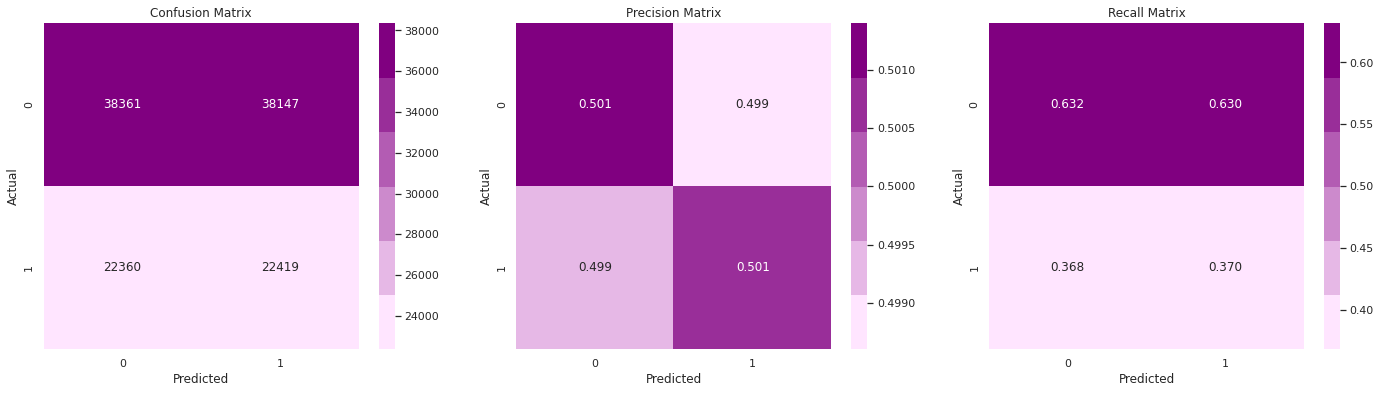

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.532795615642587
Regularization: L1	alpha = 0.0001	loss: 0.5322627908495117
Regularization: L1	alpha = 0.001	loss: 0.5332076326248403
Regularization: L1	alpha = 0.01	loss: 0.5432876534547216
Regularization: L1	alpha = 0.1	loss: 0.5539014658730984
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322701

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5330802599150539
Regularization: L2	alpha = 0.0001	loss: 0.5328962711462873
Regularization: L2	alpha = 0.001	loss: 0.5324474662918846
Regularization: L2	alpha = 0.01	loss: 0.5342869967121313
Regularization: L2	alpha = 0.1	loss: 0.5445149454889329
Regularization: L2	alpha = 1	loss: 0.5543093396461531
Regularization: L2	alpha = 10	loss: 0.5567289400253889

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5341933171402932
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5320688942908218
Regulariza

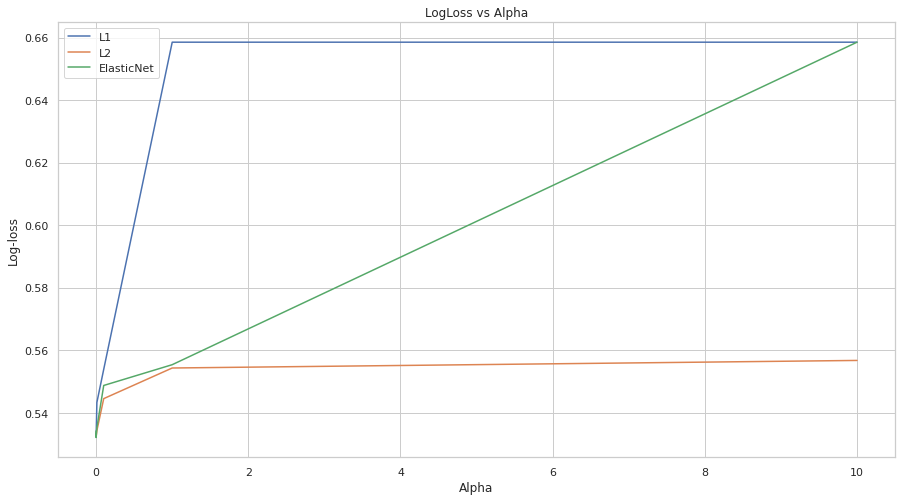

In [ ]:
# Note: Hyperparamter tuning is easier with GridSearchCV/RandomSearchCV but its more fun this way
# and is it even worth it if you're not having fun :)

# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from ElasticNet with a loss of 0.5320. In this case, we will go with the model which gives a lower loss and therefore proceed with the ElasticNet model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.5319232649436386
Log loss for best alpha on test data: 0.5309010639123872




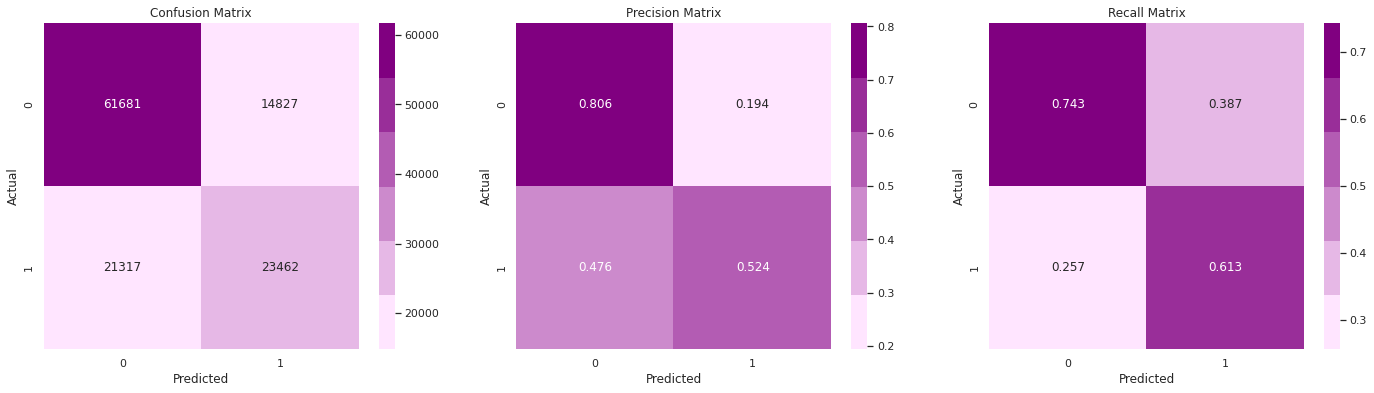

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_1_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_1_train)
predict_test = cal_clf.predict_proba(model_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Linear SVM

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5397831807135964
Regularization: L1	alpha = 0.0001	loss: 0.5453595618945147
Regularization: L1	alpha = 0.001	loss: 0.6017080103536302
Regularization: L1	alpha = 0.01	loss: 0.6094228861612258
Regularization: L1	alpha = 0.1	loss: 0.5698995998026197
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322702

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5441009043907772
Regularization: L2	alpha = 0.0001	loss: 0.5428704010971529
Regularization: L2	alpha = 0.001	loss: 0.5607518324396472
Regularization: L2	alpha = 0.01	loss: 0.5433363330887154
Regularization: L2	alpha = 0.1	loss: 0.5397181900129505
Regularization: L2	alpha = 1	loss: 0.55171567595225
Regularization: L2	alpha = 10	loss: 0.5553164641815539

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5375877800477399
Regularization: ElasticNet	alpha = 0.0001	loss: 0.544574911483359
Regularizati

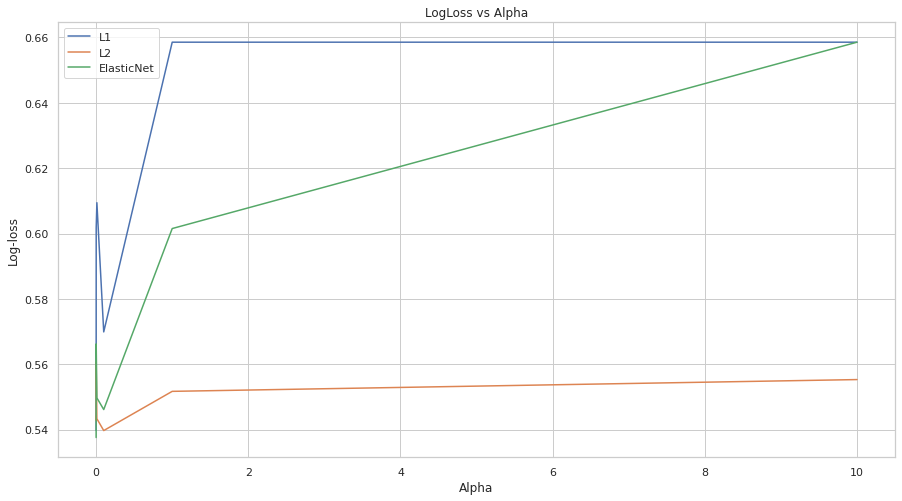

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from ElasticNet with a loss of 0.537. In this case, we will go with the model which gives a lower loss and therefore proceed with the ElasticNet model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.538607064467072
Log loss for best alpha on test data: 0.5375877800477399




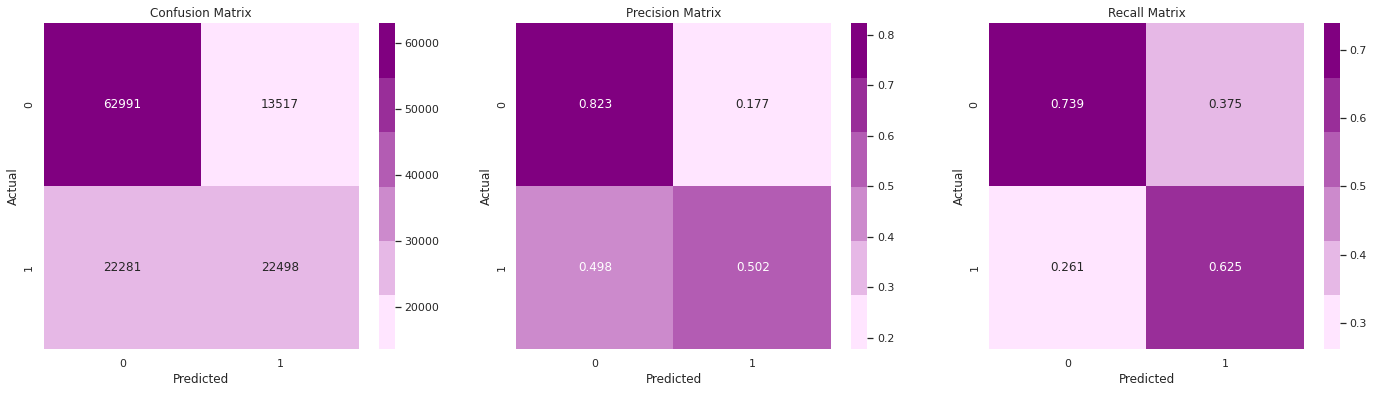

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_1_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_1_train)
predict_test = cal_clf.predict_proba(model_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### GDBT: XgBoost

#### Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_1_train, train_labels)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_1_train, train_labels)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_1_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

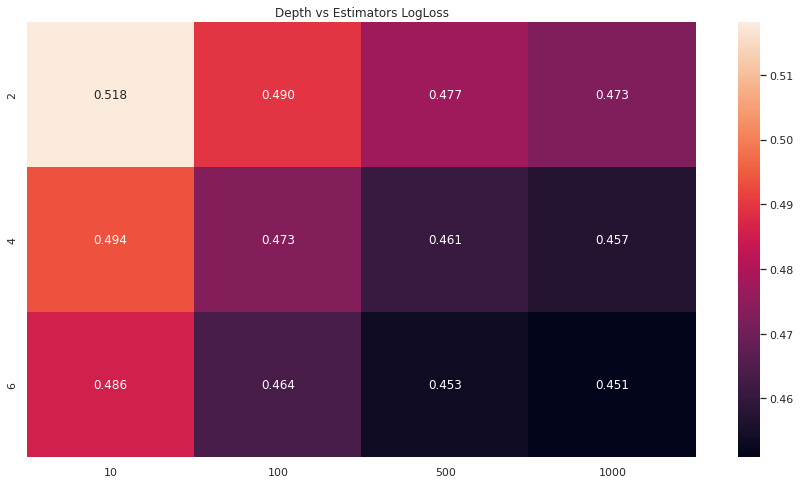

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4710096729895519
Log loss for best alpha on test data: 0.4725249934377647




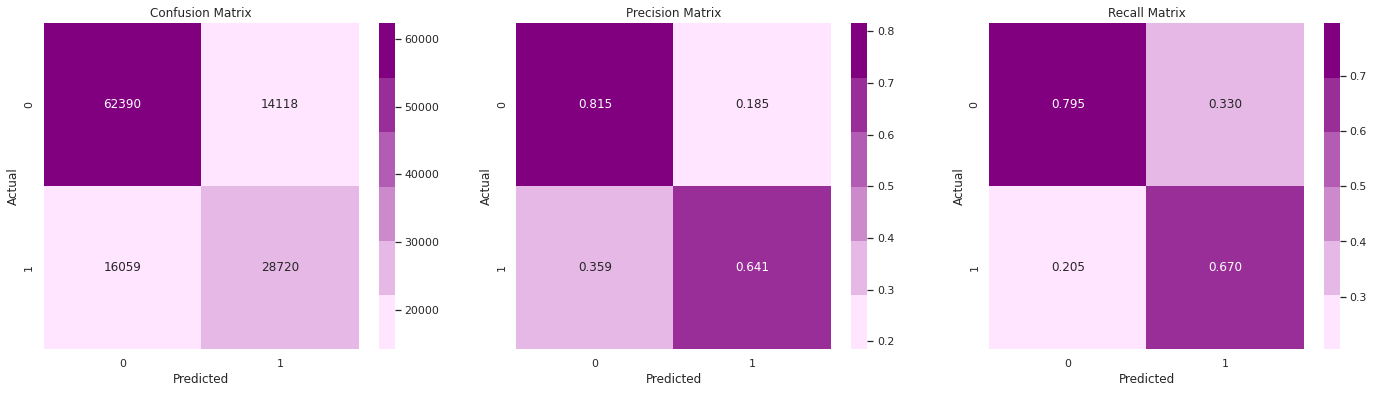

In [ ]:
# Setting best hyperparameters
n_estimators=1000
max_depth=2 # Best is depth 6, use later for better results

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_1_train, train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_1_train)
predict_test = cal_clf.predict_proba(model_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Model 2: Token features with cosine similarity

### Creating data matrices

First, we calculate the cosine similarity between each pair of questions.

In [ ]:
# Initialize arrays to store cosine values
train_cosine = np.zeros(len(train_labels))
test_cosine = np.zeros(len(test_labels))

# Set iteration counter
i = 0

# Iterating over each pair of training data questions
for q1, q2 in zip(q1_w2v_train.values, q2_w2v_train.values):
  # Computing and storing cosine similarity
  train_cosine[i] = cosine(q1, q2)
  i += 1

# Set iteration counter
i = 0

# Iterating over each pair of test data questions
for q1, q2 in zip(q1_w2v_test.values, q2_w2v_test.values):
  # Computing and storing cosine similarity
  test_cosine[i] = cosine(q1, q2)
  i += 1

# There may be some NaN values in our cosine similarities. This happens when the denominator is 0
# We replace NaN values with 0, indicating no relationship between vectors
train_cosine = np.where(np.isnan(train_cosine), 0, train_cosine)
test_cosine = np.where(np.isnan(test_cosine), 0, test_cosine)

In [ ]:
# First, let's standardize our features. We won't be standardizing the 'last_word_eq' and 'first_word_eq'
# as these are more like a yes/no indicator
# I am not standardizing the main dataframe itself as I want to preserve the actual values if I need them later

# Initialize StandardScaler
scaler = StandardScaler()

# Train data
# Getting all columns except the two specified ones
scaled = train_data.loc[:, (train_data.columns != 'last_word_eq') & (train_data.columns != 'first_word_eq')]
scaled = scaler.fit_transform(scaled)

# We horizontally stack our standardized features, 'last_word_eq', 'first_word_eq' and cosine similarity of train_data
model_2_train = np.column_stack((scaled, train_data['last_word_eq'], train_data['first_word_eq'], train_cosine))

# Test data
scaled = test_data.loc[:, (test_data.columns != 'last_word_eq') & (test_data.columns != 'first_word_eq')]
scaled = scaler.transform(scaled)

# We horizontally stack our standardized features, 'last_word_eq', 'first_word_eq' and cosine similarity of test_data
model_2_test = np.column_stack((scaled, test_data['last_word_eq'], test_data['first_word_eq'], test_cosine))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88754



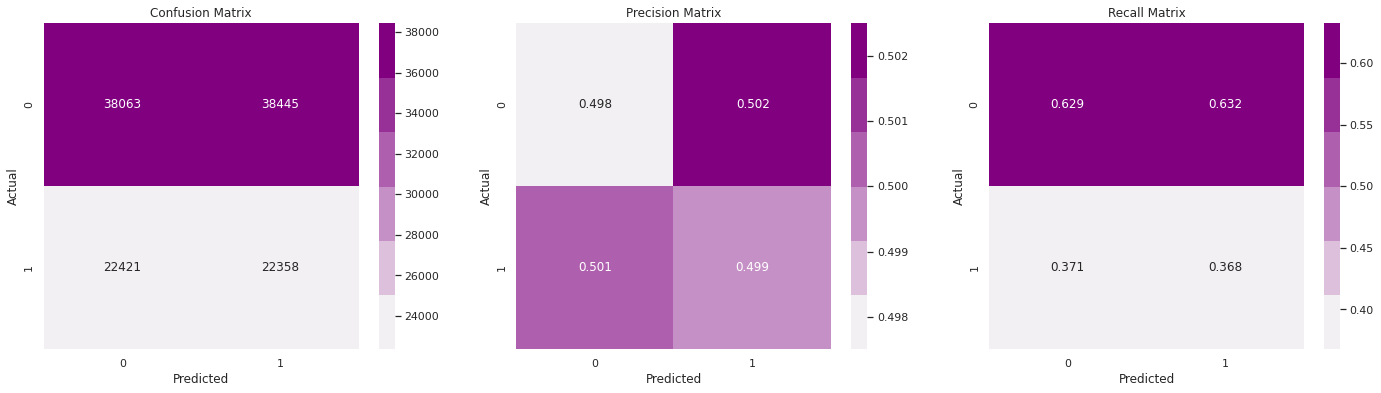

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5269288932794591
Regularization: L1	alpha = 0.0001	loss: 0.5257353420612236
Regularization: L1	alpha = 0.001	loss: 0.526983514609792
Regularization: L1	alpha = 0.01	loss: 0.5432807051122837
Regularization: L1	alpha = 0.1	loss: 0.5539014658730984
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322701

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5273082651763324
Regularization: L2	alpha = 0.0001	loss: 0.5275484012264375
Regularization: L2	alpha = 0.001	loss: 0.52717704081704
Regularization: L2	alpha = 0.01	loss: 0.5326105471547732
Regularization: L2	alpha = 0.1	loss: 0.5441575785064394
Regularization: L2	alpha = 1	loss: 0.5541215210007572
Regularization: L2	alpha = 10	loss: 0.5564920221337166

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5279260584003993
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5256847962995281
Regularizati

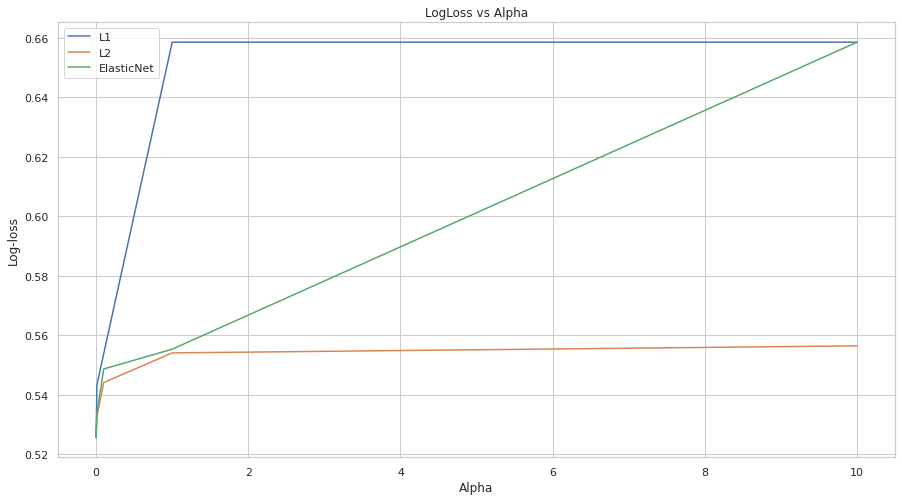

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from ElasticNet with a loss of 0.5256. In this case, we will go with the model which gives a lower loss and therefore proceed with the ElasticNet model. These results are slightly better as compared to resuls with only token features.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.5254231078573164
Log loss for best alpha on test data: 0.5256847962995281




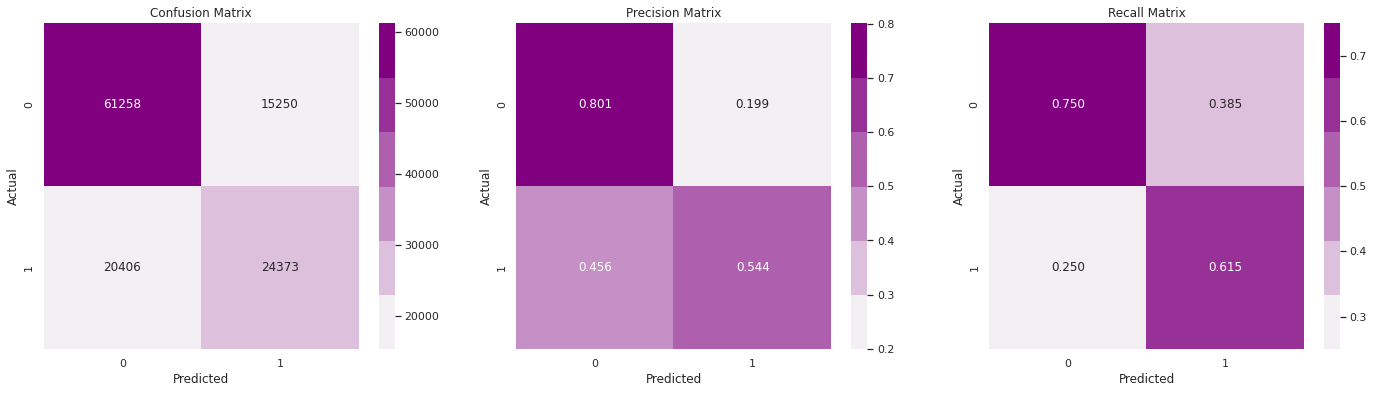

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_2_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_2_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_2_train)
predict_test = cal_clf.predict_proba(model_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Linear SVM

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5313079518232315
Regularization: L1	alpha = 0.0001	loss: 0.5372172165482104
Regularization: L1	alpha = 0.001	loss: 0.5684352492478009
Regularization: L1	alpha = 0.01	loss: 0.6094266090935081
Regularization: L1	alpha = 0.1	loss: 0.5821155616734853
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322702

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.532134001035378
Regularization: L2	alpha = 0.0001	loss: 0.5352897883961963
Regularization: L2	alpha = 0.001	loss: 0.5436128564874385
Regularization: L2	alpha = 0.01	loss: 0.5425509147308589
Regularization: L2	alpha = 0.1	loss: 0.540312390779112
Regularization: L2	alpha = 1	loss: 0.5530938706386668
Regularization: L2	alpha = 10	loss: 0.5565614878455003

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5303525111587792
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5373690451416062
Regularizat

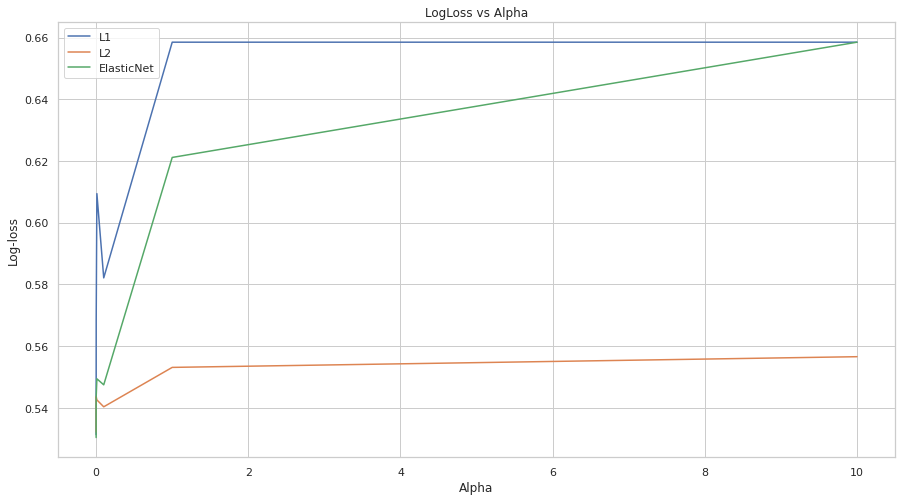

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from ElasticNet with a loss of 0.530. In this case, we will go with the model which gives a lower loss and therefore proceed with the ElasticNet model. The results are better than linear SVM on token features but worse than logistic regression on token + cosine features.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.5302392456921333
Log loss for best alpha on test data: 0.5303525111587792




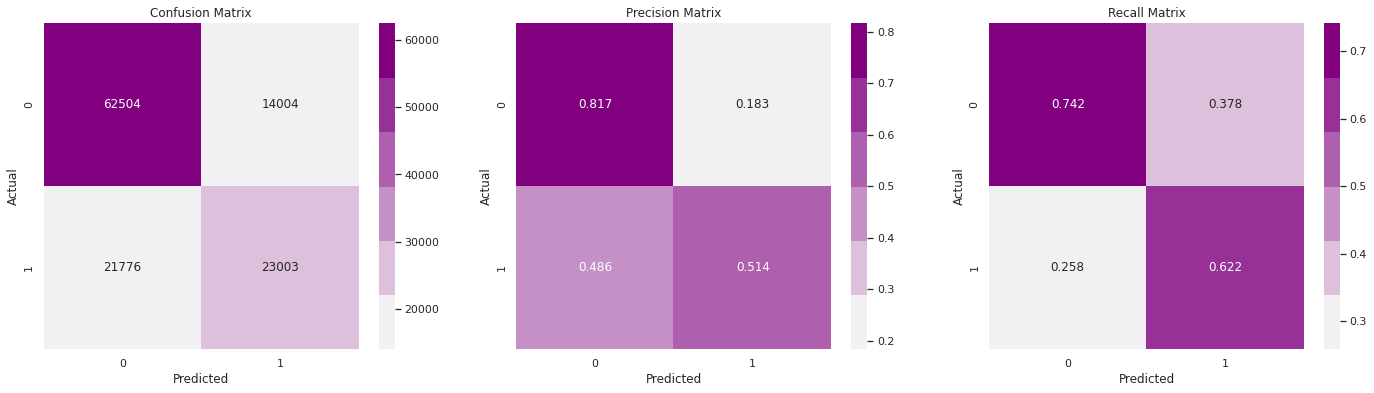

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_2_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_2_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_2_train)
predict_test = cal_clf.predict_proba(model_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### GDBT: XgBoost

#### Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_2_train, train_labels)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_2_train, train_labels)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_2_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Running at depth: 2, n_estimators: 100
Running at depth: 2, n_estimators: 500
Running at depth: 4, n_estimators: 10
Running at depth: 4, n_estimators: 100
Running at depth: 4, n_estimators: 500
Running at depth: 6, n_estimators: 10
Running at depth: 6, n_estimators: 100
Running at depth: 6, n_estimators: 500


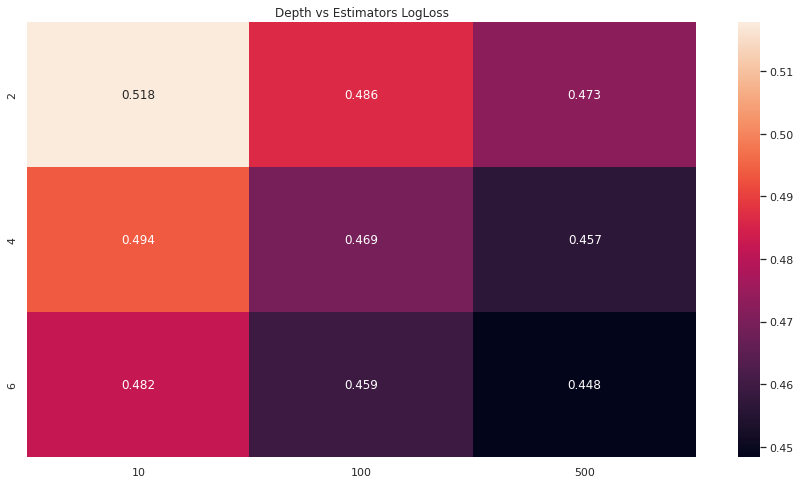

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.47088988245059293
Log loss for best alpha on test data: 0.47476060429293304




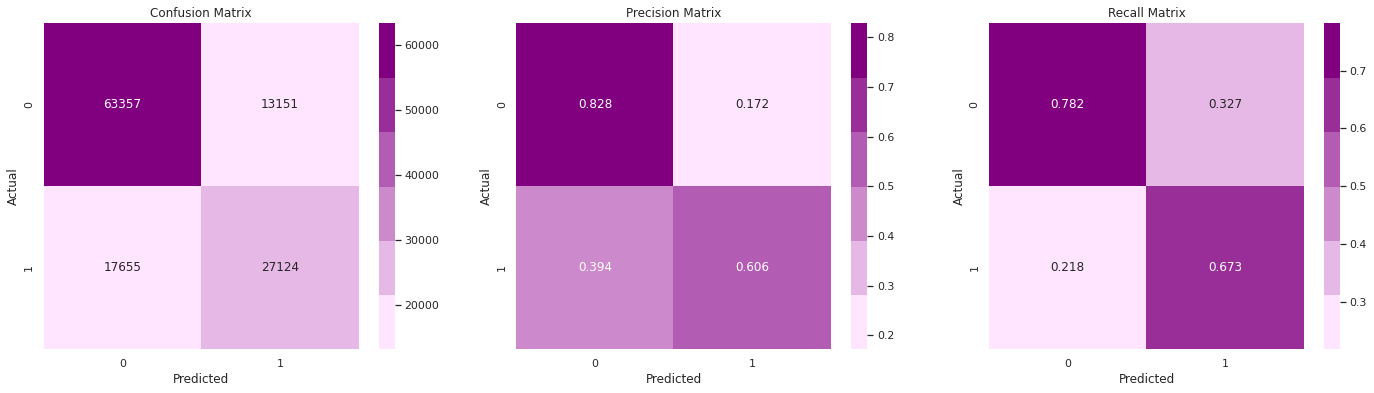

In [ ]:
# Setting best hyperparameters
n_estimators=100
max_depth=4 # Best is depth 6, use later for better results

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_2_train, train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_2_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_2_train)
predict_test = cal_clf.predict_proba(model_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Model 3.1: TF - IDF Vectors

### Creating data matrices

In [ ]:
# We already loaded the train and test question pair TF-IDF sparse matrices while computing TF-IDF vectors
# Let's horizontally stack them in q1q2 order
model_3_1_train = hstack((q1_vecs_tfidf_train, q2_vecs_tfidf_train))
model_3_1_test = hstack((q1_vecs_tfidf_test, q2_vecs_tfidf_test))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88285



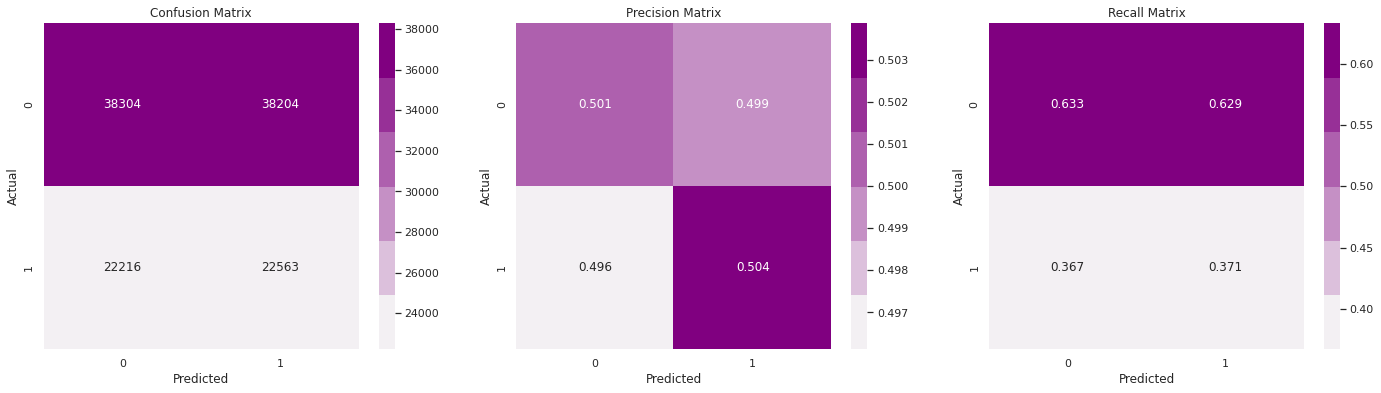

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5452338125766629
Regularization: L1	alpha = 0.0001	loss: 0.5848857185457131
Regularization: L1	alpha = 0.001	loss: 0.6388936289873705
Regularization: L1	alpha = 0.01	loss: 0.65852782563227
Regularization: L1	alpha = 0.1	loss: 0.6585278256322702
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322701

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5351261975204123
Regularization: L2	alpha = 0.0001	loss: 0.5511836488779773
Regularization: L2	alpha = 0.001	loss: 0.5759032480922311
Regularization: L2	alpha = 0.01	loss: 0.5896466517231969
Regularization: L2	alpha = 0.1	loss: 0.6087799603037058
Regularization: L2	alpha = 1	loss: 0.6187975627074206
Regularization: L2	alpha = 10	loss: 0.6199811054779858

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.53766820218915
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5627576771070835
Regularizatio

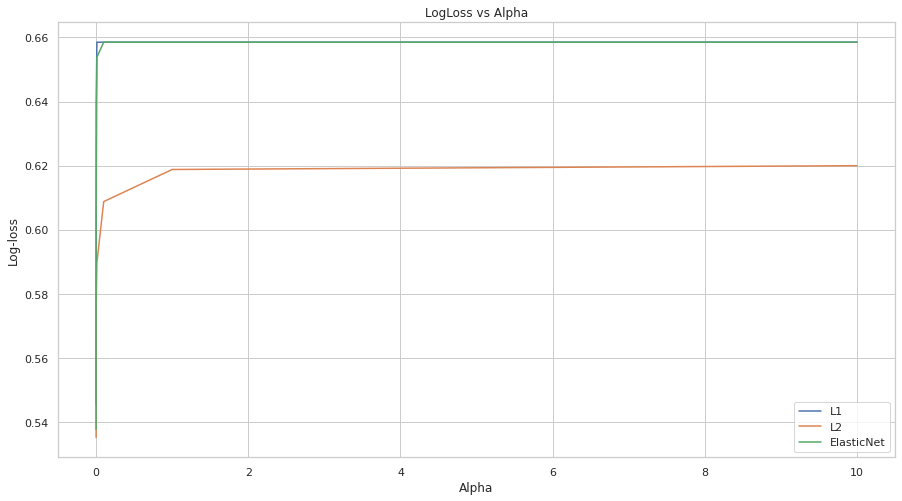

In [ ]:
# Note: Hyperparamter tuning is easier with GridSearchCV/RandomSearchCV but its more fun this way
# and is it even worth it if you're not having fun :)

# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from L2 with a loss of 0.535. This is higher than our previous two models. Nevertheless, in this case, we will go with the model which gives a lower loss and therefore proceed with the L2 model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.48036869994871034
Log loss for best alpha on test data: 0.5351261975204123




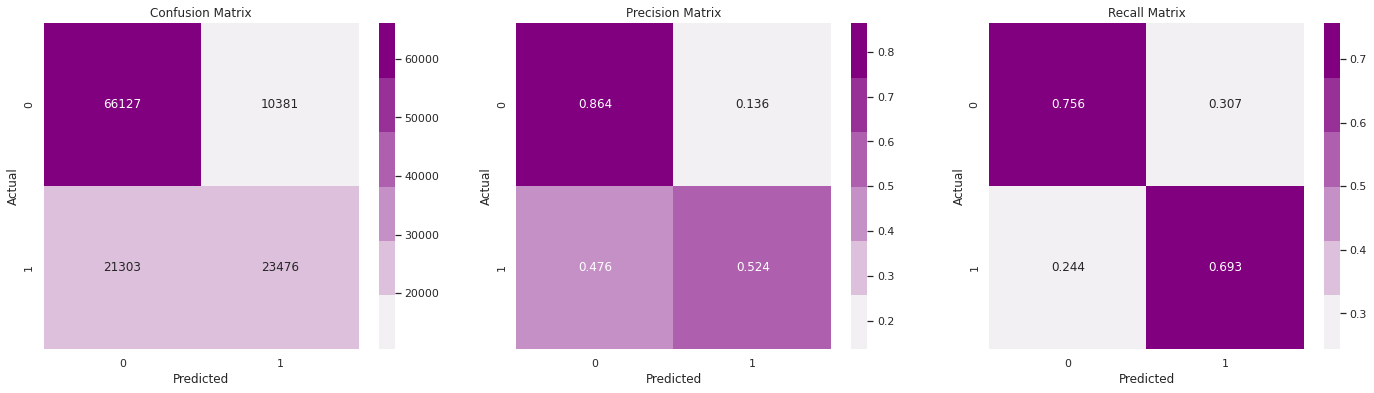

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_3_1_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_3_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_3_1_train)
predict_test = cal_clf.predict_proba(model_3_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Linear SVM

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5498302441126485
Regularization: L1	alpha = 0.0001	loss: 0.5975217589110134
Regularization: L1	alpha = 0.001	loss: 0.63828446691571
Regularization: L1	alpha = 0.01	loss: 0.6585278256322702
Regularization: L1	alpha = 0.1	loss: 0.65852782563227
Regularization: L1	alpha = 1	loss: 0.6585278256322701
Regularization: L1	alpha = 10	loss: 0.6585278256322702

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5397665632774569
Regularization: L2	alpha = 0.0001	loss: 0.5554360707654123
Regularization: L2	alpha = 0.001	loss: 0.5883636332227136
Regularization: L2	alpha = 0.01	loss: 0.6003882558931642
Regularization: L2	alpha = 0.1	loss: 0.6199679259648777
Regularization: L2	alpha = 1	loss: 0.61996792596384
Regularization: L2	alpha = 10	loss: 0.619967925966281

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5415905010834912
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5684691717379665
Regularization: 

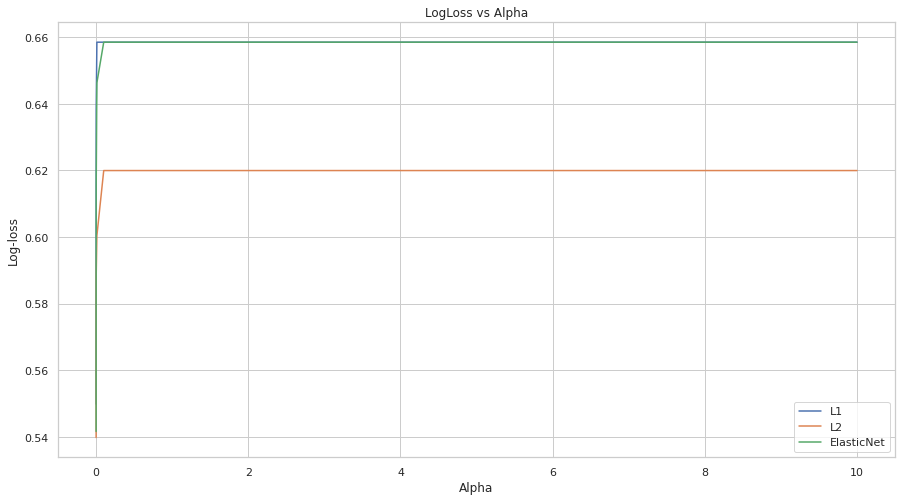

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_1_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_1_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_1_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from L2 with a loss of 0.539. In this case, we will go with the model which gives a lower loss and therefore proceed with the L2 model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4754510902149853
Log loss for best alpha on test data: 0.5397665632774569




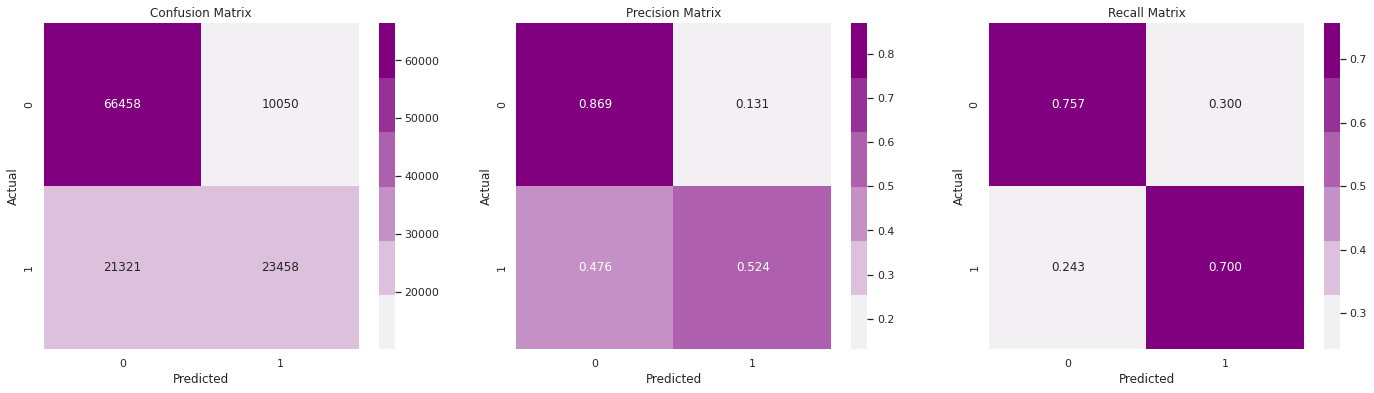

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_3_1_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_3_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_3_1_train)
predict_test = cal_clf.predict_proba(model_3_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### GDBT: XgBoost

#### Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_3_1_train, train_labels)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_3_1_train, train_labels)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_3_1_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Running at depth: 2, n_estimators: 100
Running at depth: 2, n_estimators: 500
Running at depth: 4, n_estimators: 10
Running at depth: 4, n_estimators: 100
Running at depth: 4, n_estimators: 500
Running at depth: 6, n_estimators: 10
Running at depth: 6, n_estimators: 100
Running at depth: 6, n_estimators: 500


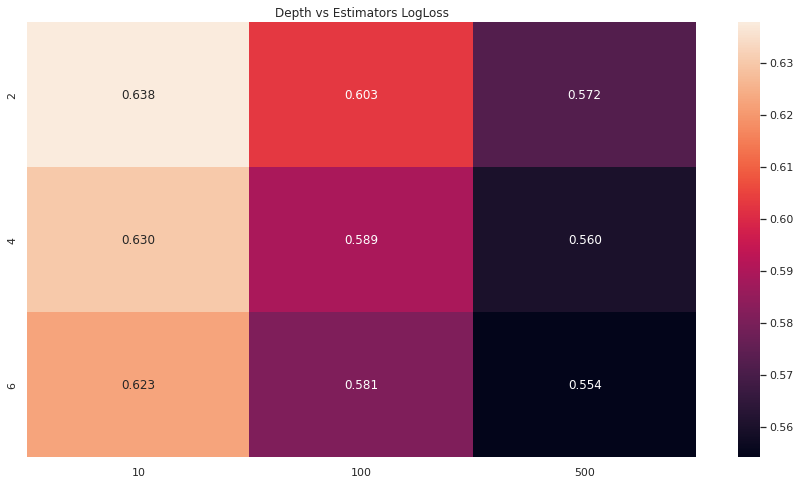

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.5591977947576942
Log loss for best alpha on test data: 0.5864721904820017




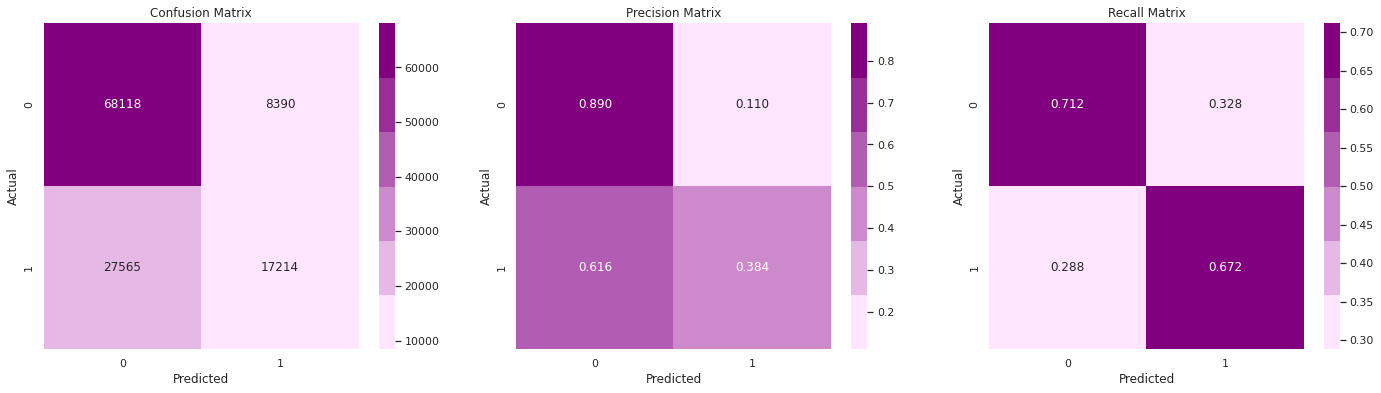

In [ ]:
# Setting best hyperparameters
n_estimators = 500 
max_depth = 6

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_3_1_train, train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_3_1_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_3_1_train)
predict_test = cal_clf.predict_proba(model_3_1_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Model 3.2: W2V Vectors

### Creating data matrices

In [ ]:
# # Reduce training set size if running into memory issues
# q1_w2v_train = q1_w2v_train[:150001]
# q2_w2v_train = q2_w2v_train[:150001]
# train_labels_truncated = train_labels[:150001]
train_labels_truncated = train_labels

In [ ]:
# We have the word vectors stored in a DataFrame
# Let's horizontally stack them in q1q2 order
model_3_2_train = np.hstack((q1_w2v_train.values, q2_w2v_train.values))
model_3_2_test = np.hstack((q1_w2v_test.values, q2_w2v_test.values))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88298



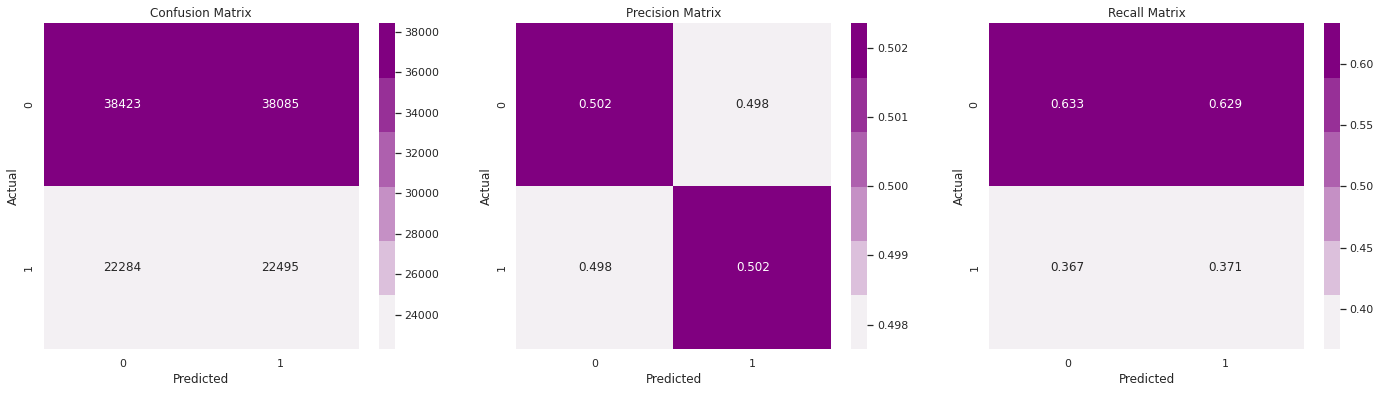

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.6340013891564382
Regularization: L1	alpha = 0.0001	loss: 0.6175009003418055
Regularization: L1	alpha = 0.001	loss: 0.6144226315589846
Regularization: L1	alpha = 0.01	loss: 0.6259235449457217
Regularization: L1	alpha = 0.1	loss: 0.6538800811695236
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322702

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.6289958028667092
Regularization: L2	alpha = 0.0001	loss: 0.6184338449447592
Regularization: L2	alpha = 0.001	loss: 0.6141855352405318
Regularization: L2	alpha = 0.01	loss: 0.6130805895078155
Regularization: L2	alpha = 0.1	loss: 0.6131448194088629
Regularization: L2	alpha = 1	loss: 0.6183596108861332
Regularization: L2	alpha = 10	loss: 0.6352293580713029

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.6308481297918389
Regularization: ElasticNet	alpha = 0.0001	loss: 0.618137042677011
Regulariza

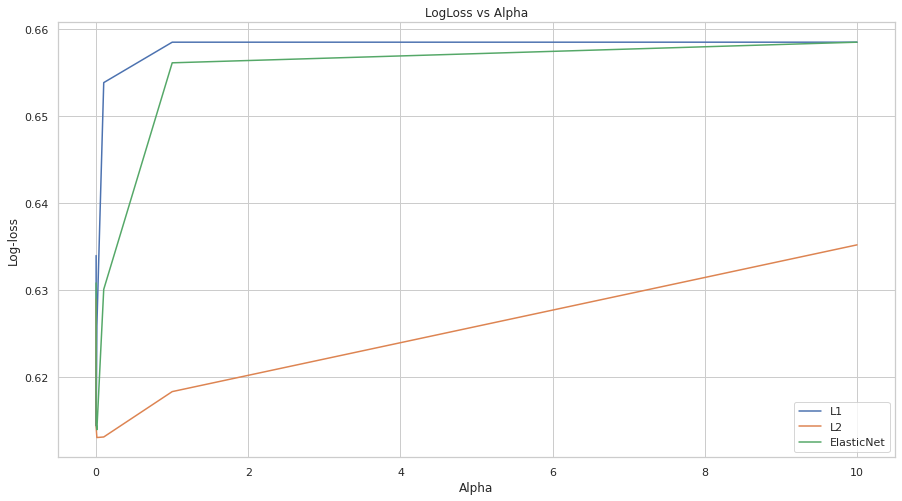

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_2_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_2_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_2_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_2_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_2_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_2_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

L2 regularization has the lowest log loss at 0.6130.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.6061862196497818
Log loss for best alpha on test data: 0.6130805895078155




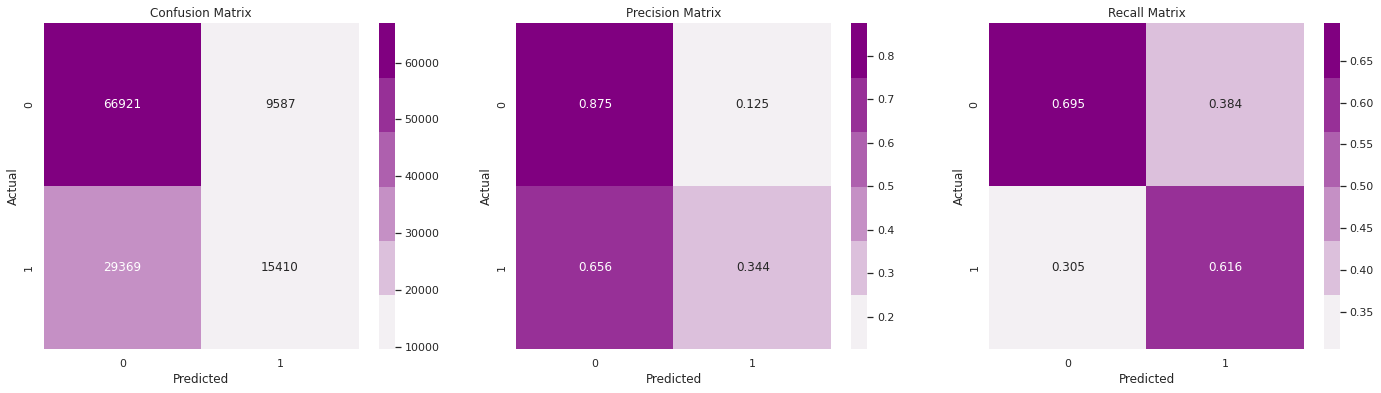

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_3_2_train, train_labels_truncated)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_3_2_train, train_labels_truncated)

# Predict
predict_train = cal_clf.predict_proba(model_3_2_train)
predict_test = cal_clf.predict_proba(model_3_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels_truncated, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Linear SVM

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.6310999310457135
Regularization: L1	alpha = 0.0001	loss: 0.6180591852069514
Regularization: L1	alpha = 0.001	loss: 0.6149041712233204
Regularization: L1	alpha = 0.01	loss: 0.622889448225721
Regularization: L1	alpha = 0.1	loss: 0.6565789650350615
Regularization: L1	alpha = 1	loss: 0.6585270918027908
Regularization: L1	alpha = 10	loss: 0.6585278256322625

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.6301386154067625
Regularization: L2	alpha = 0.0001	loss: 0.6182341148297185
Regularization: L2	alpha = 0.001	loss: 0.6141735945818164
Regularization: L2	alpha = 0.01	loss: 0.6149510277786304
Regularization: L2	alpha = 0.1	loss: 0.6156933498671744
Regularization: L2	alpha = 1	loss: 0.6238494006518853
Regularization: L2	alpha = 10	loss: 0.6466370668852196

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.6294346552834328
Regularization: ElasticNet	alpha = 0.0001	loss: 0.618080192267055
Regularizat

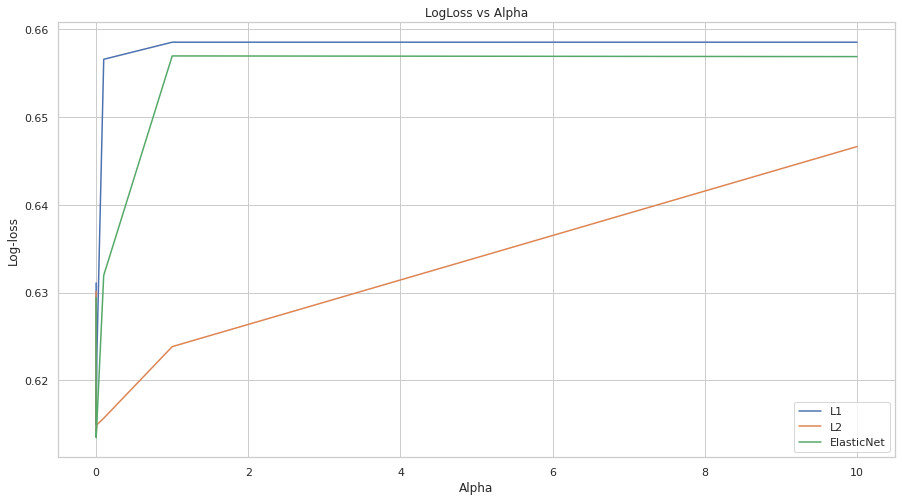

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_3_2_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_3_2_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_3_2_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from ElasticNet with a loss of 0.613. In this case, we will go with the model which gives a lower loss and therefore proceed with the L2 model.

#### Training and predicting using best hyperparameter

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elastic_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_3_2_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_3_2_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_3_2_train)
predict_test = cal_clf.predict_proba(model_3_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### GDBT: XgBoost

#### Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_3_2_train, train_labels_truncated)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_3_2_train, train_labels_truncated)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_3_2_test)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Running at depth: 2, n_estimators: 100
Running at depth: 2, n_estimators: 500
Running at depth: 4, n_estimators: 10
Running at depth: 4, n_estimators: 100
Running at depth: 4, n_estimators: 500


KeyboardInterrupt: ignored

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.5591977947576942
Log loss for best alpha on test data: 0.5864721904820017




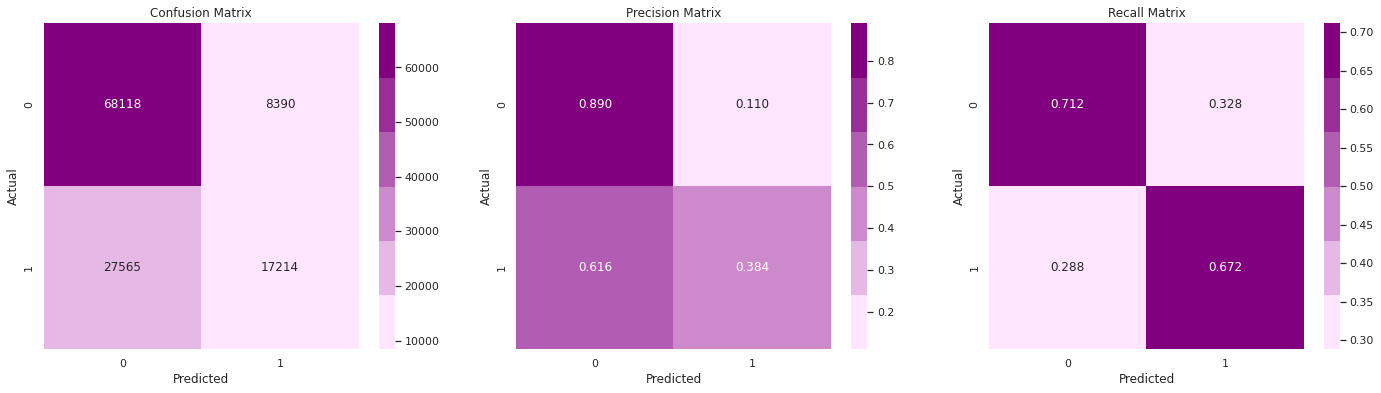

In [ ]:
# Setting best hyperparameters
n_estimators=100
max_depth=4 # Best is depth 6, use later for better results

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_3_2_train, train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_3_2_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_3_2_train)
predict_test = cal_clf.predict_proba(model_3_2_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Model 4: IDF weighted average W2V full model

### Creating data matrices

In [ ]:
# # Reduce training set size if running into memory issues
q1_w2v_train = q1_w2v_train[:150001]
q2_w2v_train = q2_w2v_train[:150001]
train_labels_truncated = train_labels[:150001]
train_data_truncated = train_data[:150001]
# train_labels_truncated = train_labels

In [ ]:
# Calculating cosine similarity
# Initialize arrays to store cosine values
train_cosine = np.zeros(len(train_labels_truncated))
test_cosine = np.zeros(len(test_labels))

# Set iteration counter
i = 0

# Iterating over each pair of training data questions
for q1, q2 in zip(q1_w2v_train.values, q2_w2v_train.values):
  # Computing and storing cosine similarity
  train_cosine[i] = cosine(q1, q2)
  i += 1

# Set iteration counter
i = 0

# Iterating over each pair of test data questions
for q1, q2 in zip(q1_w2v_test.values, q2_w2v_test.values):
  # Computing and storing cosine similarity
  test_cosine[i] = cosine(q1, q2)
  i += 1

# There may be some NaN values in our cosine similarities. This happens when the denominator is 0
# We replace NaN values with 0, indicating no relationship between vectors
train_cosine = np.where(np.isnan(train_cosine), 0, train_cosine)
test_cosine = np.where(np.isnan(test_cosine), 0, test_cosine)

In [ ]:
# Let's standardize our features. We won't be standardizing the 'last_word_eq' and 'first_word_eq'
# as these are more like a yes/no indicator
# I am not standardizing the main dataframe itself as I want to preserve the actual values if I need them later

# Initialize StandardScaler
scaler = StandardScaler()

# Train data
# Getting all columns except the two specified ones
scaled = train_data_truncated.loc[:, (train_data_truncated.columns != 'last_word_eq') & (train_data_truncated.columns != 'first_word_eq')]
scaled = scaler.fit_transform(scaled)

# We horizontally stack our standardized features, 'last_word_eq', 'first_word_eq' and cosine similarity of train_data_truncated
model_4_train = np.column_stack((scaled, train_data_truncated['last_word_eq'], train_data_truncated['first_word_eq'], train_cosine))

# Test data
scaled = test_data.loc[:, (test_data.columns != 'last_word_eq') & (test_data.columns != 'first_word_eq')]
scaled = scaler.transform(scaled)

# We horizontally stack our standardized features, 'last_word_eq', 'first_word_eq' and cosine similarity of test_data
model_4_test = np.column_stack((scaled, test_data['last_word_eq'], test_data['first_word_eq'], test_cosine))

In [ ]:
# Now let's add our word vectors to our data model
# We have the word vectors stored in a DataFrame
# Let's horizontally stack with our data matrix in q1q2 order 
model_4_train = np.hstack((model_4_train, q1_w2v_train.values, q2_w2v_train.values))
model_4_test = np.hstack((model_4_test, q1_w2v_test.values, q2_w2v_test.values))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88258



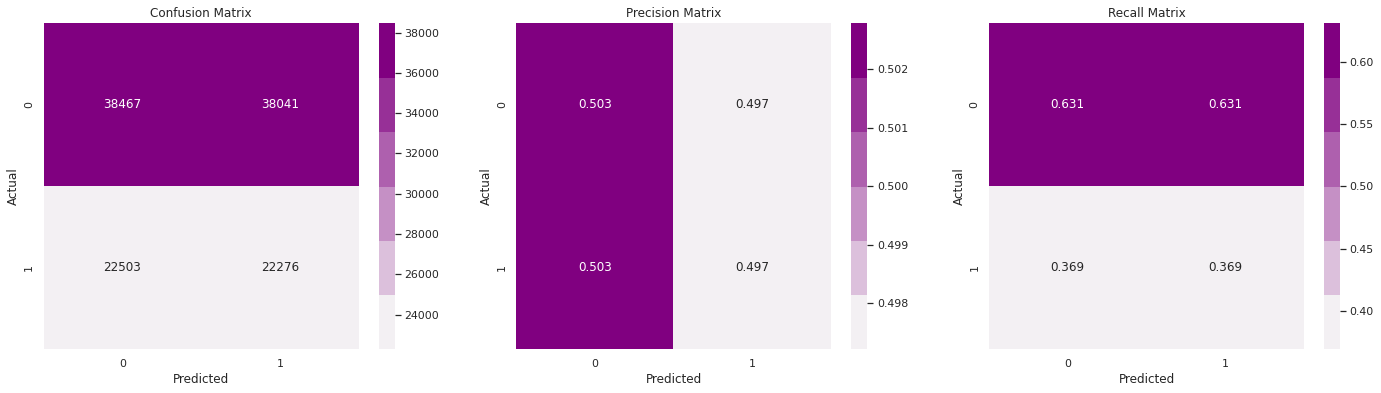

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5213769334006146
Regularization: L1	alpha = 0.0001	loss: 0.49551292221156046
Regularization: L1	alpha = 0.001	loss: 0.4979641638415586
Regularization: L1	alpha = 0.01	loss: 0.52267231299086
Regularization: L1	alpha = 0.1	loss: 0.5563271461722186
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322702

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5195731477250142
Regularization: L2	alpha = 0.0001	loss: 0.4955091741511214
Regularization: L2	alpha = 0.001	loss: 0.49183182279724424
Regularization: L2	alpha = 0.01	loss: 0.495018492965918
Regularization: L2	alpha = 0.1	loss: 0.5044826073017329
Regularization: L2	alpha = 1	loss: 0.5187247293775755
Regularization: L2	alpha = 10	loss: 0.5597203865019332

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.521565840819209
Regularization: ElasticNet	alpha = 0.0001	loss: 0.4952860773880384
Regularizat

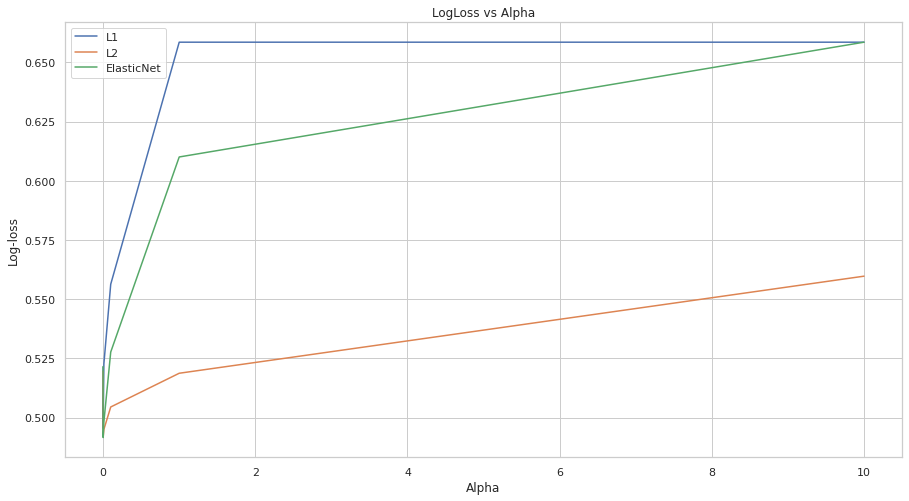

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_4_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_4_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_4_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_4_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_4_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_4_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_4_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_4_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_4_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

ElasticNet regularization has the lowest log loss at 0.4915. We will proceed with this.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4909963681756411
Log loss for best alpha on test data: 0.4915792716789212




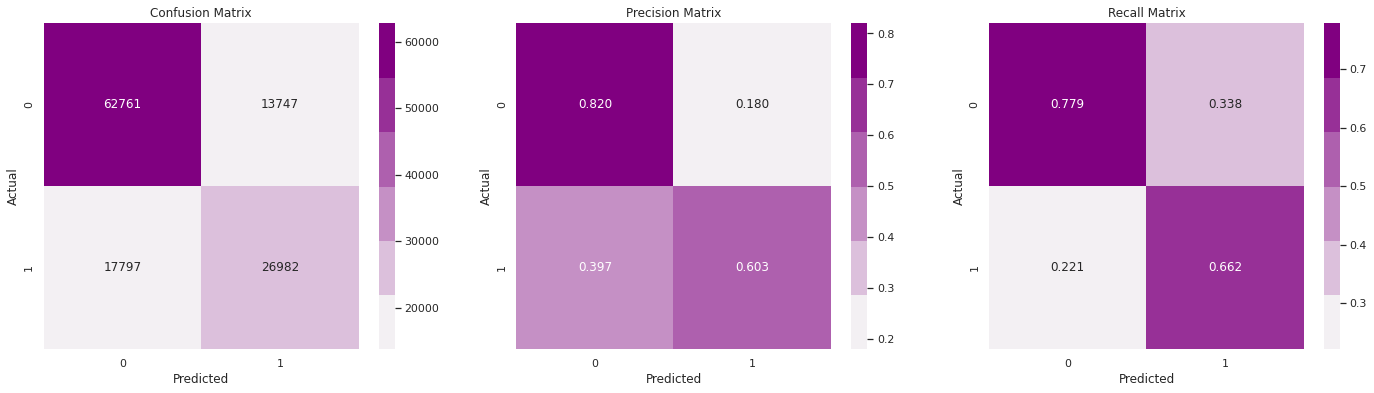

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='elasticnet', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_4_train, train_labels_truncated)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_4_train, train_labels_truncated)

# Predict
predict_train = cal_clf.predict_proba(model_4_train)
predict_test = cal_clf.predict_proba(model_4_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels_truncated, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Linear SVM

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.5248215867953567
Regularization: L1	alpha = 0.0001	loss: 0.5041162109563477
Regularization: L1	alpha = 0.001	loss: 0.4939383092665161
Regularization: L1	alpha = 0.01	loss: 0.5200066083265392
Regularization: L1	alpha = 0.1	loss: 0.5603297591722425
Regularization: L1	alpha = 1	loss: 0.6585077474541491
Regularization: L1	alpha = 10	loss: 0.6585278256322625

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.5229313718784627
Regularization: L2	alpha = 0.0001	loss: 0.5009076268066243
Regularization: L2	alpha = 0.001	loss: 0.49591599297687067
Regularization: L2	alpha = 0.01	loss: 0.4979269895981529
Regularization: L2	alpha = 0.1	loss: 0.5035124992017697
Regularization: L2	alpha = 1	loss: 0.5193489460583989
Regularization: L2	alpha = 10	loss: 0.5698377165150915

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.5260925542356167
Regularization: ElasticNet	alpha = 0.0001	loss: 0.5044846339275372
Regulari

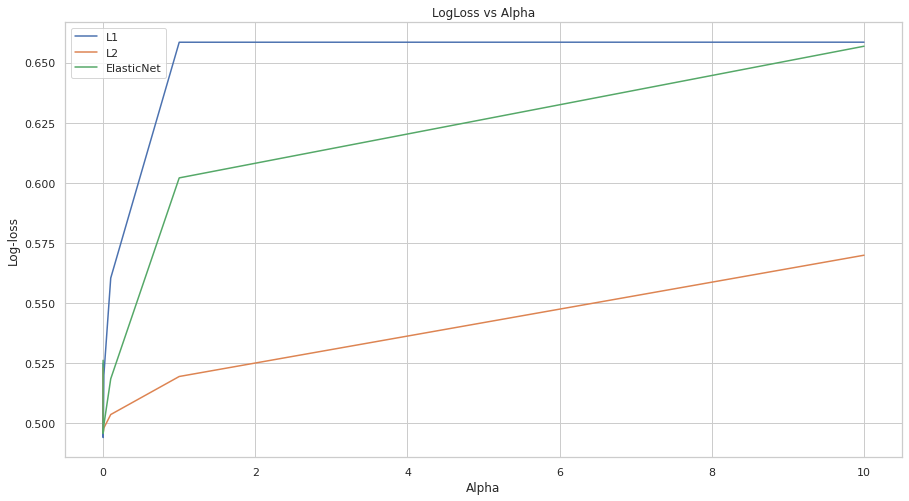

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_4_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_4_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_4_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_4_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_4_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_4_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_4_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_4_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_4_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from L1 regularization with a loss of 0.493. In this case, we will go with the model which gives a lower loss and therefore proceed with the L1 model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.4930042930136363
Log loss for best alpha on test data: 0.4977449940182821




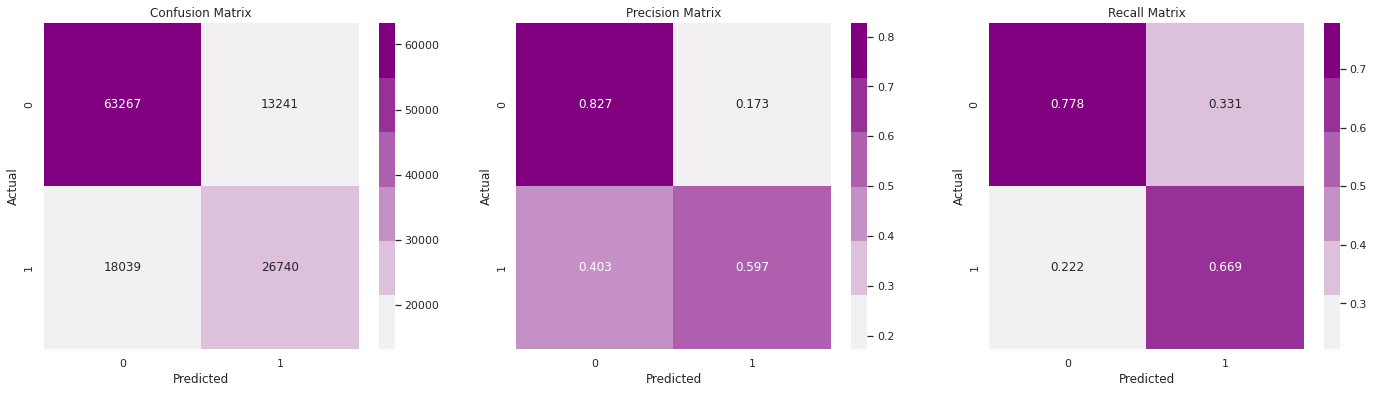

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(l1_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_4_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_4_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_4_train)
predict_test = cal_clf.predict_proba(model_4_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### GDBT: XgBoost

#### Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_4_train, train_labels_truncated)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_4_train, train_labels_truncated)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_4_test)

    # Get log loss on training data
    pred_prob_training = cal_clf.predict_proba(model_4_train)
    loss_training = log_loss(train_labels_truncated, pred_prob_training)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

    # Print training and test loss for this iteration
    print('Train loss: {0} \tTest loss: {1}\n'.format(loss_training, loss))

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Train loss: 0.5169303783797461 	Test loss: 0.5179199148956817

Running at depth: 2, n_estimators: 100
Train loss: 0.46510734413663446 	Test loss: 0.4674311329686984

Running at depth: 2, n_estimators: 500
Train loss: 0.4170165582292165 	Test loss: 0.42837006884959405

Running at depth: 4, n_estimators: 10
Train loss: 0.4909647976569225 	Test loss: 0.492654442892555

Running at depth: 4, n_estimators: 100
Train loss: 0.4151483237588987 	Test loss: 0.4282166464000691

Running at depth: 4, n_estimators: 500
Train loss: 0.3294584311855768 	Test loss: 0.38877337503453696

Running at depth: 6, n_estimators: 10
Train loss: 0.45886750140848725 	Test loss: 0.4669072579545717

Running at depth: 6, n_estimators: 100
Train loss: 0.3534826878881959 	Test loss: 0.4008831694843173

Running at depth: 6, n_estimators: 500
Train loss: 0.2047476039804304 	Test loss: 0.3615116641631261



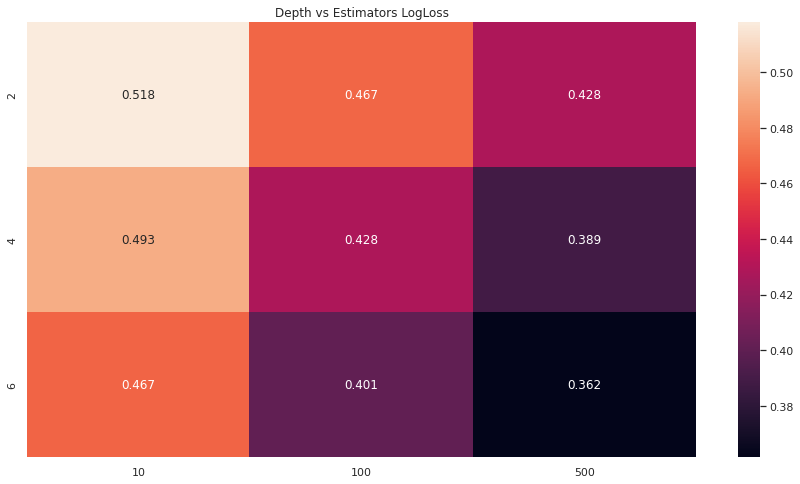

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

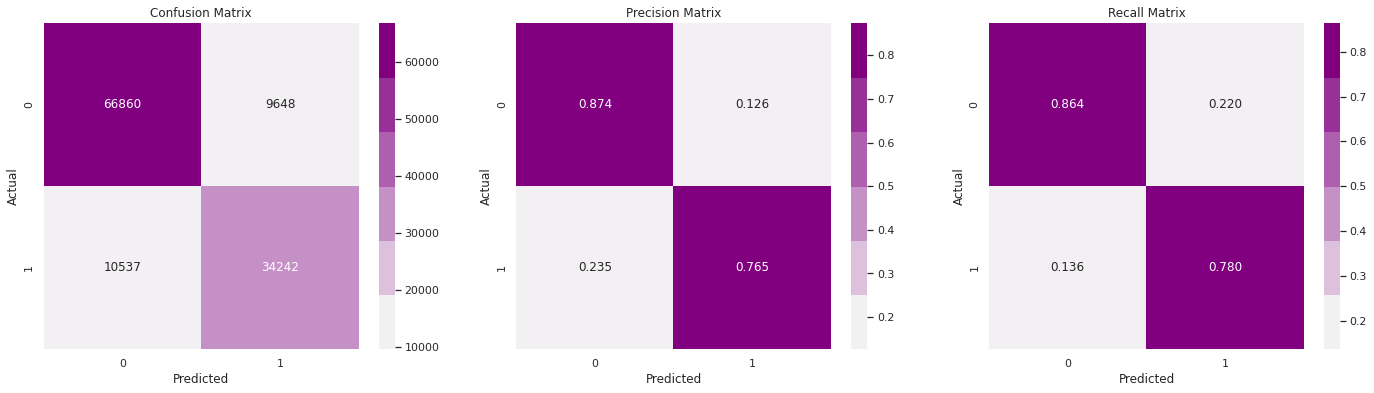

In [ ]:
# Setting best hyperparameters
n_estimators = 500
max_depth = 6 # Best is depth 6, use later for better results

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_4_train, train_labels_truncated)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_4_train, train_labels_truncated)

# Predict
predict_train = cal_clf.predict_proba(model_4_train)
predict_test = cal_clf.predict_proba(model_4_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels_truncated, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

## Model 5: TF - IDF vectors full model

### Creating data matrices

In [ ]:
# # Reduce training set size if running into memory issues
# q1_w2v_train = q1_w2v_train[:150001]
# q2_w2v_train = q2_w2v_train[:150001]
# train_labels_truncated = train_labels[:150001]
train_labels_truncated = train_labels

In [ ]:
# Let's standardize our features. We won't be standardizing the 'last_word_eq' and 'first_word_eq'
# as these are more like a yes/no indicator
# I am not standardizing the main dataframe itself as I want to preserve the actual values if I need them later

# Initialize StandardScaler
scaler = StandardScaler()

# Train data
# Getting all columns except the two specified ones
scaled = train_data.loc[:, (train_data.columns != 'last_word_eq') & (train_data.columns != 'first_word_eq')]
scaled = scaler.fit_transform(scaled)

# We horizontally stack our standardized features, 'last_word_eq' and 'first_word_eq'
model_5_train = np.column_stack((scaled, train_data['last_word_eq'], train_data['first_word_eq']))

# Test data
scaled = test_data.loc[:, (test_data.columns != 'last_word_eq') & (test_data.columns != 'first_word_eq')]
scaled = scaler.transform(scaled)

# We horizontally stack our standardized features, 'last_word_eq', 'first_word_eq
model_5_test = np.column_stack((scaled, test_data['last_word_eq'], test_data['first_word_eq']))

In [ ]:
# Now let's add our word vectors to our data model
# We have the word vectors stored in a DataFrame
# Let's horizontally stack with our data matrix in q1q2 order 
model_5_train = hstack((model_5_train, q1_vecs_tfidf_train, q2_vecs_tfidf_train))
model_5_test = hstack((model_5_test, q1_vecs_tfidf_test, q2_vecs_tfidf_test))

### Random model
Let's build a random model and check our log-loss and confusion matrices. This can be a baseline for our other models.

Log-loss for a random model is: 0.88308



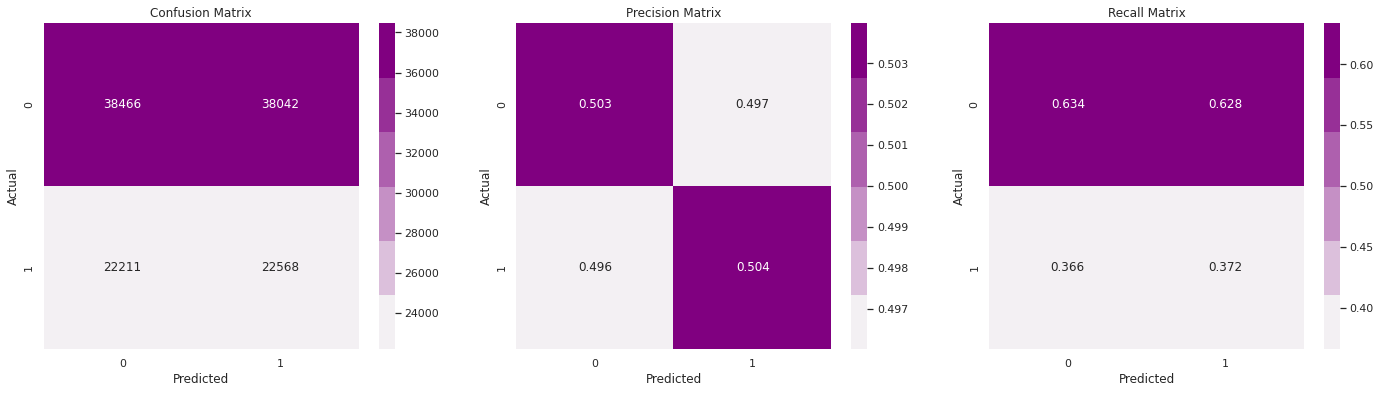

In [ ]:
# Initialzing data structure to hold predicted probabilities
predicted = np.zeros((len(test_labels), 2))

for i in range(len(test_labels)):
  # Getting 2 random values
  prob = np.random.rand(1, 2)

  # Making so that both the random values sum to 1
  predicted[i] = (prob / sum(sum(prob)))[0]

# Log-loss on the positive class label
random_logloss = log_loss(test_labels, predicted[:, 1])
print('Log-loss for a random model is: {:.5f}\n'.format(random_logloss))

# Now we assign class labels 0 or 1 depending on which has higher probabilities
# This way we can create confusion matrices
predicted = np.argmax(predicted, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Logistic Regression

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.43395302058823565
Regularization: L1	alpha = 0.0001	loss: 0.46780697430625773
Regularization: L1	alpha = 0.001	loss: 0.5292705459639073
Regularization: L1	alpha = 0.01	loss: 0.548096403075226
Regularization: L1	alpha = 0.1	loss: 0.5544424004230115
Regularization: L1	alpha = 1	loss: 0.6585278256322702
Regularization: L1	alpha = 10	loss: 0.6585278256322701

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.4120986960995297
Regularization: L2	alpha = 0.0001	loss: 0.4370646731264512
Regularization: L2	alpha = 0.001	loss: 0.48725726367262406
Regularization: L2	alpha = 0.01	loss: 0.5282828735794053
Regularization: L2	alpha = 0.1	loss: 0.5469082478761322
Regularization: L2	alpha = 1	loss: 0.554779519915326
Regularization: L2	alpha = 10	loss: 0.5566822488024431

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.4138888729684789
Regularization: ElasticNet	alpha = 0.0001	loss: 0.4490033587908996
Regulari

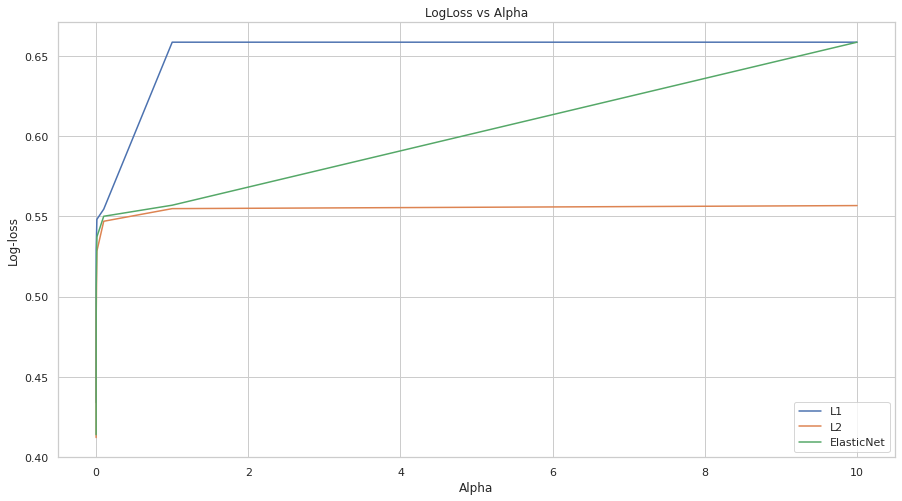

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_5_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_5_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_5_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_5_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_5_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_5_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='log', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_5_train, train_labels_truncated)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_5_train, train_labels_truncated)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_5_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

L2 regularization has the lowest log loss at 0.412. We will proceed with this.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.3836619973471893
Log loss for best alpha on test data: 0.4120986960995297




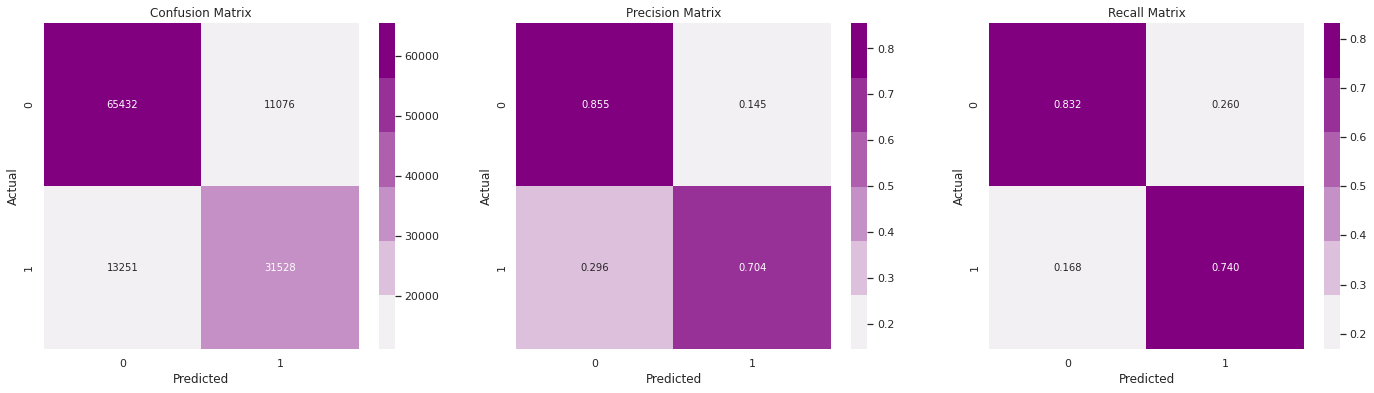

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(elasticnet_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_5_train, train_labels_truncated)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_5_train, train_labels_truncated)

# Predict
predict_train = cal_clf.predict_proba(model_5_train)
predict_test = cal_clf.predict_proba(model_5_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels_truncated, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### Linear SVM

#### Hyperparameter tuning

L1 Regularization
Regularization: L1	alpha = 1e-05	loss: 0.4369387338580937
Regularization: L1	alpha = 0.0001	loss: 0.4640658118224605
Regularization: L1	alpha = 0.001	loss: 0.5476530325092749
Regularization: L1	alpha = 0.01	loss: 0.5557313681644815
Regularization: L1	alpha = 0.1	loss: 0.5562529826565479
Regularization: L1	alpha = 1	loss: 0.6585278256322701
Regularization: L1	alpha = 10	loss: 0.6585278256322702

L2 Regularization
Regularization: L2	alpha = 1e-05	loss: 0.41569391772687564
Regularization: L2	alpha = 0.0001	loss: 0.4307291624995982
Regularization: L2	alpha = 0.001	loss: 0.47552781487894535
Regularization: L2	alpha = 0.01	loss: 0.5250924725050284
Regularization: L2	alpha = 0.1	loss: 0.5429090742338911
Regularization: L2	alpha = 1	loss: 0.5540856792173781
Regularization: L2	alpha = 10	loss: 0.5569505079794739

ElasticNet Regularization
Regularization: ElasticNet	alpha = 1e-05	loss: 0.4168010991186584
Regularization: ElasticNet	alpha = 0.0001	loss: 0.44106765512892565
Regula

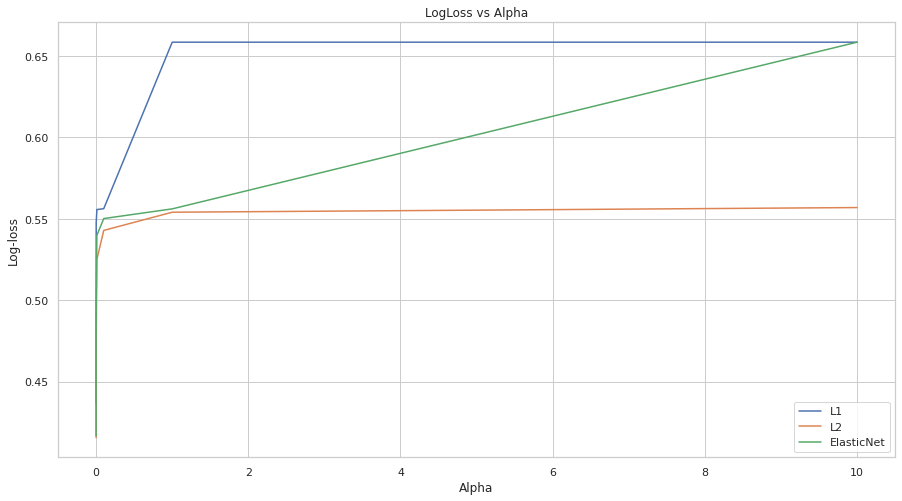

In [ ]:
# Set list of hyperparameter: alpha to iterate over
# We will use this list for both L1, L2 and elasticnet regularization
# alpha ranges from 0.00001 to 10 (7 values)
alpha = [10**x for x in range(-5, 2)]

# Create lists to hold values for log-loss for L1, L2 and ElasticNet
l1_logloss = []
l2_logloss = []
elasticnet_logloss = []

# We will also perform model calibration for better results
# L1 regularization
# Iterate over alphas
print('L1 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l1', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_5_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_5_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_5_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l1_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L1', a, loss))


# L2 regularization
# Iterate over alphas
print('\nL2 Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='l2', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_5_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_5_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_5_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  l2_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('L2', a, loss))

# elasticnet regularization
# Iterate over alphas
print('\nElasticNet Regularization')
for a in alpha:
  # Initialize SGDClassifier
  sgd_clf = SGDClassifier(loss='hinge', alpha=a, penalty='elasticnet', n_jobs=-1, random_state=42)
  
  # Fit/train model
  sgd_clf.fit(model_5_train, train_labels)

  # Initialize calibration model
  cal_clf = CalibratedClassifierCV(sgd_clf)
  
  # Fit calibration model
  cal_clf.fit(model_5_train, train_labels)

  # Predict on test data
  pred_prob = cal_clf.predict_proba(model_5_test)

  # Get log-loss on predictions
  loss = (log_loss(test_labels, pred_prob))
  elasticnet_logloss.append(loss)

  print('Regularization: {}\talpha = {}\tloss: {}'.format('ElasticNet', a, loss))

print('\n')

# Plotting hyperparamter tuning results
plt.figure(figsize=(15, 8))

# L1 plot
sns.lineplot(x=alpha, y=l1_logloss, label='L1')

# L2 plot
sns.lineplot(x=alpha, y=l2_logloss, label='L2')

# ElasticNet plot
sns.lineplot(x=alpha, y=elasticnet_logloss, label='ElasticNet')

# Setting plot title, axes labels and legend
plt.title('LogLoss vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Log-loss')
plt.legend()

plt.show()

The least logloss is from L2 regularization with a loss of 0.415. In this case, we will go with the model which gives a lower loss and therefore proceed with the L2 model.

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.3749777652764977
Log loss for best alpha on test data: 0.41569391772687564




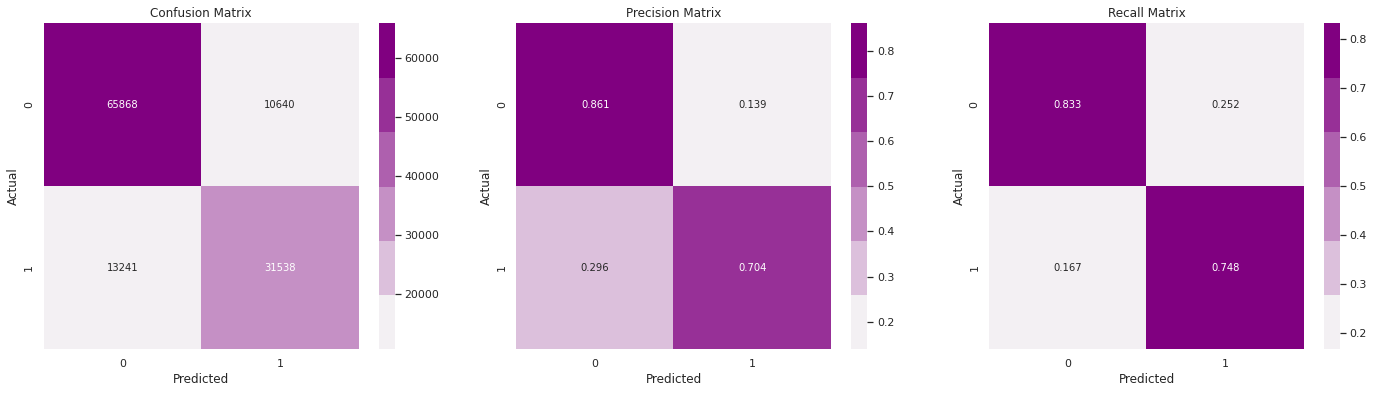

In [ ]:
# Finding best alpha
best_alpha = alpha[np.argmin(l2_logloss)]

# Now we train SGDClassifier with best alpha and regularization
sgd_clf = SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l2', n_jobs=-1, random_state=42)

# Train model
sgd_clf.fit(model_5_train, train_labels)

# Initialize calibration model
cal_clf = CalibratedClassifierCV(sgd_clf)

# Fit calibration model
cal_clf.fit(model_5_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_5_train)
predict_test = cal_clf.predict_proba(model_5_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

### GDBT: XgBoost

#### Hyperparameter tuning

In [ ]:
# First, we create the list of hyperparameters to iterate over
max_depth = [2, 4, 6]
n_estimators = [10, 100, 500]

# Initialize list to store log-loss results
result_logloss = []

# Iterating over max_depth
for depth in max_depth:
  # Initialize list to store log loss for this iteration
  logloss = []
  # Iterate over n_estimators
  for n in n_estimators:
    print('Running at depth: {}, n_estimators: {}'.format(depth, n))

    # Initialize model
    gbdt_clf = xgb.XGBClassifier(max_depth=depth, n_estimators=n, objective='binary:logistic', n_jobs=-1, random_state=42)

    # Fitting on train data
    gbdt_clf.fit(model_5_train, train_labels_truncated)

    # Initializing calibration model
    cal_clf = CalibratedClassifierCV(gbdt_clf) 

    # Fitting calibration model
    cal_clf.fit(model_5_train, train_labels_truncated)

    # Predict on test data
    pred_prob = cal_clf.predict_proba(model_5_test)

    # Get log loss on training data
    pred_prob_training = cal_clf.predict_proba(model_5_train)
    loss_training = log_loss(train_labels_truncated, pred_prob_training)

    # Get log-loss on predictions
    loss = (log_loss(test_labels, pred_prob))
    logloss.append(loss)

    # Print training and test loss for this iteration
    print('Train loss: {0} \tTest loss: {1}\n'.format(loss_training, loss))

  result_logloss.append(logloss)

Running at depth: 2, n_estimators: 10
Train loss: 0.5195114130088593 	Test loss: 0.5193222857653599

Running at depth: 2, n_estimators: 100
Train loss: 0.4751676867590033 	Test loss: 0.47486241809010316

Running at depth: 2, n_estimators: 500
Train loss: 0.434908224075069 	Test loss: 0.43678056506797325

Running at depth: 4, n_estimators: 10
Train loss: 0.48967427251038526 	Test loss: 0.49015189695891065

Running at depth: 4, n_estimators: 100
Train loss: 0.4452472840209462 	Test loss: 0.44740659175848585

Running at depth: 4, n_estimators: 500
Train loss: 0.397640901966631 	Test loss: 0.4086203733836905

Running at depth: 6, n_estimators: 10
Train loss: 0.47062196037499676 	Test loss: 0.47257379290526924

Running at depth: 6, n_estimators: 100
Train loss: 0.42099268787373395 	Test loss: 0.42811951826145456

Running at depth: 6, n_estimators: 500
Train loss: 0.368155586282011 	Test loss: 0.3922480915066254



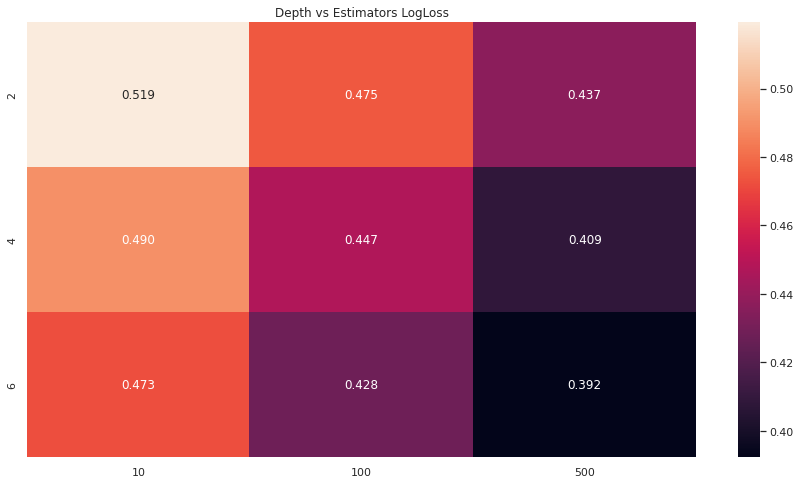

In [ ]:
# Plot log loss heatmap
plt.figure(figsize=(15,8))
sns.heatmap(result_logloss, annot=True, fmt='.3f', xticklabels=n_estimators, yticklabels=max_depth)
plt.title('Depth vs Estimators LogLoss')

plt.show()

#### Training and predicting using best hyperparameter

Log loss for best alpha on train data: 0.2456413179767291
Log loss for best alpha on test data: 0.3665712416302974




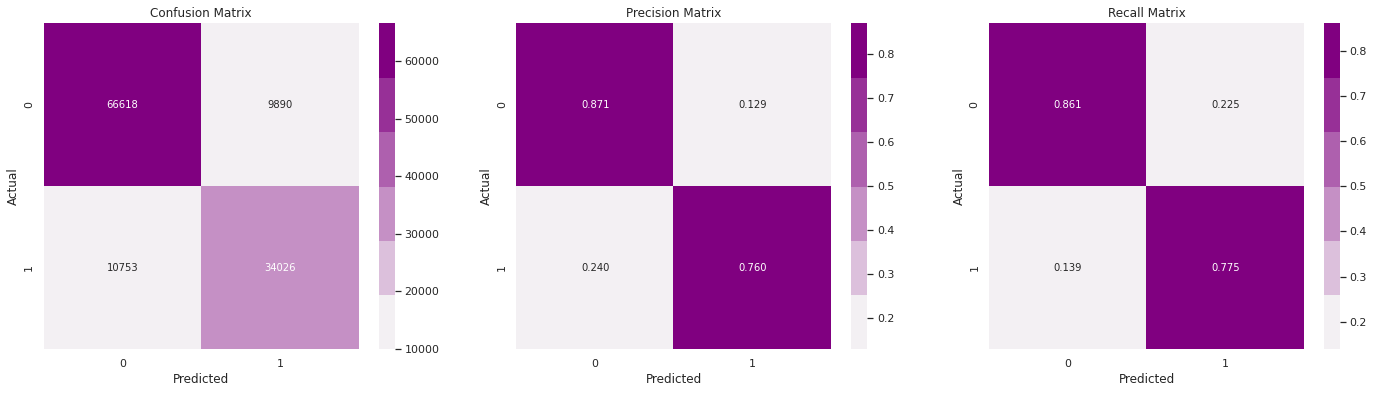

In [ ]:
# Setting best hyperparameters
n_estimators = 500
max_depth = 6

# Initialize model
gbdt_clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=n_estimators, objective='binary:logistic', n_jobs=-1, random_state=42)

# Fitting on train data
gbdt_clf.fit(model_5_train, train_labels)

# Initializing calibration model
cal_clf = CalibratedClassifierCV(gbdt_clf) 

# Fitting calibration model
cal_clf.fit(model_5_train, train_labels)

# Predict
predict_train = cal_clf.predict_proba(model_5_train)
predict_test = cal_clf.predict_proba(model_5_test)

print('Log loss for best alpha on train data: {}'.format(log_loss(train_labels, predict_train)))
print('Log loss for best alpha on test data: {}'.format(log_loss(test_labels, predict_test)))

print('\n')

# Convert probabilities to 0 or 1 and plot test confusion matrices
predicted = np.argmax(predict_test, axis=1)
plot_confusion_matrices(test_labels, predicted)

# Bert

In [ ]:
data.head(2)

id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0

[2 rows x 6 columns]

In [ ]:
data.drop(['id','qid1','qid2'],axis=1,inplace=True)

In [ ]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = [1,0]

In [ ]:
mask = np.random.rand(len(data)) < 0.8
train_df = data[mask]
not_train = data[~mask]

#create mask for val-test distribution
mask = np.random.rand(len(not_train)) < 0.5
test_df = not_train[mask]
val_df = not_train[~mask]
val_df.head(5)

question1  ... is_duplicate
6                                 Should I buy tiago?  ...            0
13        What was your first sexual experience like?  ...            1
14  What are the laws to change your status from a...  ...            0
16                       What does manipulation mean?  ...            1
33  Does the United States government still blackl...  ...            0

[5 rows x 3 columns]

In [ ]:
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {val_df.shape[0]}")
print(f"Total test samples: {test_df.shape[0]}")

Total train samples : 323367
Total validation samples: 40398
Total test samples: 40525


In [ ]:
print("Train Target Distribution")
print(train_df.is_duplicate.value_counts())

print("Validation Target Distribution")
print(val_df.is_duplicate.value_counts())

Train Target Distribution
0    203915
1    119452
Name: is_duplicate, dtype: int64
Validation Target Distribution
0    25559
1    14839
Name: is_duplicate, dtype: int64


In [ ]:
y_train = tf.keras.utils.to_categorical(train_df.is_duplicate, num_classes=2)#One hot encodding representation
print(f"y_train.shape:{y_train.shape}")

y_val = tf.keras.utils.to_categorical(val_df.is_duplicate, num_classes=2)
print(f"y_val.shape:{y_val.shape}")

y_test = tf.keras.utils.to_categorical(test_df.is_duplicate, num_classes=2)
print(f"y_test.shape:{y_test.shape}")

y_train.shape:(323367, 2)
y_val.shape:(40398, 2)
y_test.shape:(40525, 2)


In [ ]:
# Set parameters:
params = {'MAX_LENGTH': 128,
          'EPOCHS': 4,
          'LEARNING_RATE': 3e-4,
          'FT_EPOCHS': 4,
          'OPTIMIZER': 'adam',
          'FT_LEARNING_RATE': 2e-5,
          'BATCH_SIZE': 64,
          'BERT_DROPOUT': 0.2,
          'BERT_ATT_DROPOUT': 0.2,
          'LAYER_DROPOUT': 0.2,
          'KERNEL_INITIALIZER': 'GlorotNormal',
          'BIAS_INITIALIZER': 'zeros',
          'POS_PROBA_THRESHOLD': 0.5,          
          'ADDED_LAYERS': 'Dense 256, Dense 32, Dropout 0.2',
          'LR_SCHEDULE': '3e-4 for 4 epochs, Fine-tune w/ adam for 4 epochs @2e-5',
          'FREEZING': 'All DistilBERT layers frozen for 4 epochs, then unfrozen for 4',
          'CALLBACKS': '[early_stopping monitoring val_loss w/ patience=0]',
          'RANDOM_STATE':42
          }

In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [ ]:

strategy = tf.distribute.MirroredStrategy()# Create the model under a distribution strategy scope.

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    sequence_output, pooled_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
    
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7fa42b661090>
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
_______________________________________________________________________________________

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["question1", "question2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
val_data = BertSemanticDataGenerator(
    val_df[["question1", "question2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
     use_multiprocessing=True,
    workers=-1,
)

Epoch 1/2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
8850/8850 [==============================] - 3281s 366ms/step - loss: 0.4316 - acc: 0.7859 - val_loss: 0.3371 - val_acc: 0.8432
Epoch 2/2
8850/8850 [=

In [ ]:
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 128, 768), ( 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]        

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/2
8850/8850 [==============================] - 7739s 874ms/step - loss: 0.2853 - accuracy: 0.8741 - val_loss: 0.2712 - val_accuracy: 0.8832
Epoch 2/2
8850/8850 [==============================] - 7737s 874ms/step - loss: 0.2139 - accuracy: 0.9100 - val_loss: 0.2477 - val_accuracy: 0.8973


In [ ]:
test_data = BertSemanticDataGenerator(
    test_df[["question1", "question2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

1890/1890 [==============================] - 529s 280ms/step - loss: 0.2438 - accuracy: 0.9001


[0.24381373822689056, 0.9000826478004456]

In [ ]:
def check_similarity(sentence1, sentence2):
  sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
  test_data = BertSemanticDataGenerator(
      sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
  )

  proba = model.predict(test_data)[0]
  idx = np.argmax(proba)
  proba = f"{proba[idx]: .2f}%"
  pred = labels[idx]
  return pred, proba

#### Try the custom Questions

In [ ]:
ind = np.random.randint(0,500) 
#Duplicate Questions
q1 = test_df[test_df["is_duplicate"] == 1].iloc[ind]['question1']
q2 = test_df[test_df["is_duplicate"] == 1].iloc[ind]['question2']
print(q1+"\n"+q2)
check_similarity(q1,q2)

Why when I read an English article do I understand most of the words but I cannot understand the message of the article very well? How can I improve my reading comprehension?
I am very poor in English language and even struggle to understand while reading small article also. How can I improve it without attend class?


(0, ' 0.81%')

In [ ]:
ind = np.random.randint(0,500)
#Non-Duplicate Questions
q1 = test_df[test_df["is_duplicate"] == 0].iloc[ind]['question1']
q2 = test_df[test_df["is_duplicate"] == 0].iloc[ind]['question2']
print(q1+"\n"+q2)
check_similarity(q1,q2)

How many pullups can an average person do?
How many photos a day does an average person take with their phone.?


(1, ' 1.00%')

## Conclusion

Broadly, the approach can be divided into the following stages:

1. Preprocessing
1. Featurization
1. Vizualization and removing redundant features
1. Vectorization
1. Applying machine learning models

Before beginning the preprocessing step, we first split the data into train and test sets. A 70-30 split was performed.

Let's take a deeper look at what was done in each stage.

### Stage 1: Preprocessing

The preprocessing consists of the following steps:

* Convert to lowercase
* Remove punctuations
* Replace some numerical values with strings (Eg: 1,000,000 with 1m)
* Remove HTML tags
* Replace some characters with their string equivalents (Eg: $, % @ etc.)
* Decontract words
* Stop word removal

Stop word removal was not done in the proprocessing function as we needed to extract some information from stop words as well. It was performed in the featurization step.
After observing processed word clouds for q1 and q2, it was noticed that the word 'best' and 'different' were observed very frequently in non-duplicate pairs. This meant that this word had no value and was hence added to the stop word set.

Stemming and lemmatization were not performed as they threw off the word vectors, which were pre trained on proper, non stemmed and non lemmatized text.




### Stage 2: Featurization

The following features were extracted:

- **Token features**
  1. **q1_len**: Number of characters in question 1
  1. **q2_len**: Number of characters in question 2
  1. **q1_words**: Number of words in question 1
  1. **q2_words**: Number of words in question 2
  1. **words_total**: Sum of **q1_words** and **q2_words**
  1. **words_common**: Number of words which occur in question 1 and two, reapeated occurances are not counted
  1. **words_shared**: Fraction of **words_common** to **words_total**
  1. **cwc_min**: This is the ratio of the number of common words to the length of the smaller question
  1. **cwc_max**: This is the ratio of the number of common words to the length of the larger question
  1. **csc_min**: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
  1. **csc_max**: This is the ratio of the number of common stop words to the larger stop word count among the two questions
  1. **ctc_min**: This is the ratio of the number of common tokens to the smaller token count among the two questions
  1. **ctc_max**: This is the ratio of the number of common tokens to the larger token count among the two questions
  1. **last_word_eq**: 1 if the last word in the two questions is same, 0 otherwise
  1. **first_word_eq**: 1 if the first word in the two questions is same, 0 otherwise
  1. **num_common_adj**: This is the number of common adjectives in question1 and question2
  1. **num_common_prn**: This is the number of common proper nouns in question1 and question2
  1. **num_common_n**: This is the number of nouns (non-proper) common in question1 and question2

- **Fuzzy features**

  1. **fuzz_ratio**: fuzz_ratio score from fuzzywuzzy
  1. **fuzz_partial_ratio**: fuzz_partial_ratio from fuzzywuzzy
  1. **token_sort_ratio**: token_sort_ratio from fuzzywuzzy
  1. **token_set_ratio**: token_set_ratio from fuzzywuzzy



- **Length features**
  1. **mean_len**: Mean of the length of the two questions (number of words)
  1. **abs_len_diff**: Absolute difference between the length of the two questions (number of words)
  1. **longest_substr_ratio**: Ratio of the length of the longest substring among the two questions to the length of the smaller question

Off the shelf NLTK PoS tagger was used for PoS tagging.

### Stage 3: Vizualization and removing redundant features

After performing univariate and pair plot analysis, we concluded that the following features don't contribute to explaining the variance and were hence dropped:

*   ctc_min
*   ctc_max
*   fuzz_ratio

At this stage, we also take a look at word clouds to determine if there are common words in non-duplicate pairs. As mentioned earlier, this is where we determined that the words 'best' and 'different' were of no value.



### Stage 4: Vectorization

Two vectorization approaches were considered:

*   TF - IDF vectors (each question has a dimensionality of 73459)
*   IDF weighted average W2V vectors (each question has a dimensionality of 300)



### Stage 5: Applying machine learning models

There were various model approaches. They are as follows:

1. Model 1: Only token features, no word vector features. Very low dimensionality but limited semantic information.
1. Model 2: Token features along with cosine similarity of word vectors (W2V only). Very low dimensionality and incorporates some semantic information as well.
1. Model 3.1:  Just the TF - IDF word vectors themselves. Extremely high dimensionality,  incorporates a lot of semantic information but no token information.
1. Model 3.2:  Just the IDF weighted average W2V word vectors themselves. Very high dimensionality,  incorporates a lot of semantic information but no token information.
1. Model 4: Token information along with W2V vectors and cosine similarity. This really is all the information we have, put together and fed into a model.
1. Model 5: Token information along with TF - IDF vectors. 
The following machine learning algorithms were applied:


1. Logistic regression: Hyperparameter search over alpha and regularization method.
1. Linear SVM: Hyperparameter search over alpha and regularization method.
1. GBDT: Hyperparameter search over number of estimators (number of boosting rounds) and max depth of estimators.


7. Model 6: Bert Base was used for classification.


The results for each model is shown below.



In [2]:
!pip install PrettyTable

In [5]:
from prettytable import PrettyTable

In [8]:
# Initializing table
table = PrettyTable()

# Setting header names
print('Logistic Regression')
table.field_names = ['Model', 'Dimensionality', ' Alpha', 'Regularization', 'Train log-loss', 'Test log-loss']

# Setting rows
table.add_row(['Model 1', '22', '0.0001', 'ElasticNet', '0.531', '0.530'])
table.add_row(['Model 2', '23', '0.0001', 'ElasticNet', '0.525', '0.525'])
table.add_row(['Model 4', '623', '0.001', 'ElasticNet', '0.490', '0.491'])
table.add_row(['Model 5', '146940', '1e-05', 'L2', '0.383', '0.412'])

print(table)

# Initializing table
table = PrettyTable()

# Setting header names
print('\nLinear SVM')
table.field_names = ['Model', 'Dimensionality', 'Alpha', 'Regularization', 'Train log-loss', 'Test log-loss']

# Setting rows
table.add_row(['Model 1', '22', '1e-05', 'ElasticNet', '0.538', '0.537'])
table.add_row(['Model 2', '23', '1e-05', 'ElasticNet', '0.530', '0.530'])
table.add_row(['Model 4', '623', '0.001', 'ElasticNet', '0.493', '0.497'])
table.add_row(['Model 5', '146940', '1e-05', 'L2', '0.374', '0.415'])

print(table)

# Initializing table
table = PrettyTable()

# Setting header names
print('\nGBDT')
table.field_names = ['Model', 'Dimensionality', 'Boosting rounds', 'Max depth', 'Train log-loss', 'Test log-loss']

# Setting rows
table.add_row(['Model 1', '22', '1000', '6', '0.451', 'N/A'])
table.add_row(['Model 2', '23', '500', '6', '0.448', 'N/A'])
table.add_row(['Model 4', '623', '500', '6', '0.200', '0.361'])
table.add_row(['Model 5', '146940', '500', '6', '0.245', '0.366'])

print(table)

table = PrettyTable()

# Setting header names
print('\nBERT')
table.field_names = ['Model', 'Train log-loss', 'Test log-loss']

# Setting rows
table.add_row(['Bert-Base-Uncased', '0.2139', '0.2438'])

print(table)


Logistic Regression
+---------+----------------+--------+----------------+----------------+---------------+
|  Model  | Dimensionality |  Alpha | Regularization | Train log-loss | Test log-loss |
+---------+----------------+--------+----------------+----------------+---------------+
| Model 1 |       22       | 0.0001 |   ElasticNet   |     0.531      |     0.530     |
| Model 2 |       23       | 0.0001 |   ElasticNet   |     0.525      |     0.525     |
| Model 4 |      623       | 0.001  |   ElasticNet   |     0.490      |     0.491     |
| Model 5 |     146940     | 1e-05  |       L2       |     0.383      |     0.412     |
+---------+----------------+--------+----------------+----------------+---------------+

Linear SVM
+---------+----------------+-------+----------------+----------------+---------------+
|  Model  | Dimensionality | Alpha | Regularization | Train log-loss | Test log-loss |
+---------+----------------+-------+----------------+----------------+---------------+
| M

In conclusion, Bert outperforms all other models by a great margin